# Hotel Customer Segmentation - Business Case 1
### What are the different customer segments of this hotel?


> Carolina Costa, number: 20220715
>
> João Gameiro, number: 20221364 
>
> Martim Santos, number: 20220540 
>
> Rodrigo Silva, number: 20221360 
>
> Rúben Serpa, number: 20221284 

## 1. Import the needed libraries

In [1]:
#!pip install kneed
#!pip install geopandas
#!pip install data-science-utils
#!pip install kmodes

In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
from math import ceil
from scipy.stats import chi2_contingency
from collections import Counter
from sklearn.preprocessing import MinMaxScaler, StandardScaler,RobustScaler, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import AgglomerativeClustering,KMeans,estimate_bandwidth,MeanShift,DBSCAN
from kmodes.kprototypes import KPrototypes
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import pairwise_distances,silhouette_score, silhouette_samples
import matplotlib.pyplot as plt
from matplotlib import cm, colorbar
from matplotlib.patches import RegularPolygon
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colors as mpl_colors
from matplotlib.lines import Line2D
from matplotlib import __version__ as mplver
import matplotlib.font_manager
from matplotlib import ticker
import seaborn as sns
from kneed import KneeLocator
from collections import Counter
from ds_utils.unsupervised import plot_cluster_cardinality, plot_cluster_magnitude, plot_magnitude_vs_cardinality
from scipy.spatial.distance import euclidean
import sklearn.metrics as metrics
import matplotlib.patches as mpatches

import warnings
warnings.filterwarnings('ignore')

**Colours**

In [3]:
main_colour= 'darkcyan'

In [4]:
palette= 'BrBG'

**Functions**

In [5]:
def hist_box_maker(df,titl, figx, figy):
    num_of_rows = len(df.columns)
    fig, axes = plt.subplots(num_of_rows, ceil((len(df.columns)*2)/num_of_rows), figsize=(figx, figy))
    temp = (list(df.columns)*2)
    temp.sort()
    # Plot data
    # Iterate across axes objects and associate each histogram:
    i = 0 
    for ax, feat in zip(axes.flatten(), temp):
        if i%2 == 0:
            ax.hist(df[feat], bins = 50,color=main_colour)
            ax.set_title(feat,y=0.4,x=2.5)
            pltiswork=feat
        else:
            sns.boxplot(x=df[pltiswork], ax = ax,color=main_colour)
        i+=1    
    title = titl
    plt.suptitle(title,y=0.90)
    plt.show()

In [6]:
def categ_abs_freq (nr_columns, nr_rows, features):
    sns.set()

    fig, axes = plt.subplots(nr_rows, nr_columns, figsize=(20, 5))


    for ax, feat in zip(axes.flatten(), features):
        sns.countplot(x=df[feat].astype(object), ax=ax, color=main_colour)

    title = "Categorical Variables' Absolute Frequencies"
    plt.suptitle(title, fontsize= '20', y=1.05)

    plt.show()
    return 

In [7]:
def scaler (df, scalling_method, metric_features):
    
    '''
    Pass a dataframe, a scalling method and the dataframe metric features,
    and applies the corresponding scaling method to the dataframe.

    Arguments:
        df (dataframe): dataframe
        scalling_method (str): name of the scaler (for example, MinMax)
        metric_features (list): df metric features
        
    Returns:
        df (dataframe): scaled version of the original df
        
    '''
    
    df_scaled = scalling_method.fit(df.loc[:, metric_features])
    
    df.loc[:, metric_features] = df_scaled.transform(df.loc[:, metric_features])
    
    return df

In [8]:
def plot_boxplot (df, metric_features):
    
    '''
    Pass a dataframe and the dataframe metric features,
    and plots boxplots of the correspondent metric features.

    Arguments:
        df (dataframe): dataframe
        metric_features (list): df metric features
        
    '''
    
    sns.set()
    
    fig, axes = plt.subplots(2, ceil(len(metric_features) / 2), figsize=(20, 11))

    for ax, feat in zip(axes.flatten(), metric_features): 
        sns.boxplot(x=df[feat], ax=ax, color=main_colour)

    title = "Numeric Features' Box Plots"

    plt.suptitle(title, fontsize='20', y=.95)

    plt.show()
    
    return

In [9]:
#Adapted from https://seaborn.pydata.org/examples/many_pairwise_correlations.html

def correlation_matrix (df, metric_features):
    
    '''
    Pass a dataframe and the dataframe metric features,
    and plots the correlation matrix (all the correlations 
    between the correspondent metric features).

    Arguments:
        df (dataframe): dataframe
        metric_features (list): df metric features
        
    '''
    
    mask = np.triu(np.ones_like(df[metric_features].corr(method='kendall'), dtype=bool))


    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(19, 17))


    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)


    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(df[metric_features].corr(method='kendall'), annot = True, mask=mask, cmap=palette, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

    plt.title('Correlation Between Variables', size=20)
    
    return

In [10]:
def pca_analysis(dataframe):
    pca = PCA()
    pca_feat = pca.fit_transform(dataframe)
    pca_analysis = pd.DataFrame(
        {
         "PC": range(1, pca.n_components_ + 1),
         "Eigenvalue": pca.explained_variance_,
         "Difference": np.insert(np.diff(pca.explained_variance_), 0, 0),
         "Proportion": pca.explained_variance_ratio_,
         "Cumulative": np.cumsum(pca.explained_variance_ratio_)}
    ).round(4)
    fig = plt.figure(figsize=(8,5))
    ax1 = fig.add_subplot(121)
    ax1.plot(pca.explained_variance_ratio_, marker=".", markersize=12, label="Proportion")
    ax1.plot(np.cumsum(pca.explained_variance_ratio_), marker=".", markersize=12, linestyle="--", label="Cumulative")
    ax1.legend()
    ax1.set(title='Variance Explained', xlabel='Components', ylabel='Proportion',\
            xticks= range(0, pca.n_components_, 1),xticklabels=range(1, pca.n_components_ + 1, 1))
    ax2 = fig.add_subplot(122)
    font_size=10
    bbox=[0, 0, 2, 1]
    ax2.axis('off')
    mpl_table = ax2.table(cellText = pca_analysis.values,colWidths=[1,2,2,2,2], bbox=bbox, colLabels=pca_analysis.columns)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(10)
    return pca_feat;

In [11]:
def violinplot_categ_num (df, categorical_var_name):
    sns.set(style = "ticks")

    fig, axes = plt.subplots(3, 2, figsize=(15, 20),sharex='col')

    for ax, feat in zip(axes.flatten(), metric_features):
        sns.violinplot(x = df[categorical_var_name], y = df[feat], ax = ax, palette=palette)
        ax.set_xticklabels(labels= df[categorical_var_name].unique().tolist(), rotation=45, horizontalalignment='right')
    
    plt.show()
    return

In [12]:
def plot_inertia(df, max_number_clusters):
    #df with metric features only
    
    '''
    Pass a dataframe and maximum number of clusters,
    and plots the enertia to determine the right number of clusters 
    to use with K-Means (automatically starts plotting from 1 cluster forward)
    
    Arguments: 
        df (dataframe): dataframe
        max_number_clusters (int): maximum number of clusters to include in the plot
     
     '''
    inertia = []
    for i in range(1, max_number_clusters+1):  # iterate over desired ncluster range
        k_means = KMeans(n_clusters=i, init='k-means++', n_init=15, random_state=5)
        k_means.fit(df)
        inertia.append(k_means.inertia_)
        print(f"For n_clusters = {i}, the inertia is : {k_means.inertia_}")
        
    fig, ax = plt.subplots(figsize=(7, 4))
    plt.plot(inertia, color= main_colour, marker="o")
    plt.ylabel("Inertia: SSw")
    plt.xlabel("Number of clusters")
    plt.title("Inertia plot over clusters", size=15)
    ax.xaxis.set_ticks(range(0, max_number_clusters))
    ax.set_xticklabels(range(1, max_number_clusters+1))
    

    plt.show()
    
    return

In [13]:
def plot_silhouette(df, max_number_clusters):
    #df with only metric features
    
    '''
    Pass a dataframe and maximum number of clusters,
    and plots the silhouette score for all the clusters  
    (automatically starts plotting from 2 clusters forward)
    
    Arguments: 
        df (dataframe): dataframe
        max_number_clusters (int): maximum number of clusters to include in the plot
     
     '''
        
    avg_silhouette = []
    for i in range(1, max_number_clusters ):
    # Skip nclus == 1
        if i == 1:
            continue

    # Initialize the KMeans object with n_clusters value and a random generator
        kmclust = KMeans(n_clusters=i, init='k-means++', n_init=15, random_state=5)
        cluster_labels = kmclust.fit_predict(df)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
        silhouette_avg = silhouette_score(df, cluster_labels)
        avg_silhouette.append(silhouette_avg)
        print(f"For n_clusters = {i}, the average silhouette_score is : {silhouette_avg}")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df, cluster_labels)
    
    fig, ax = plt.subplots(figsize=(7, 4))
    plt.plot(avg_silhouette, color= main_colour, marker="o")
    plt.ylabel("Average silhouette")
    plt.xlabel("Number of clusters")
    plt.title("Average silhouette plot over clusters", size=15)
    ax.xaxis.set_ticks(range(0, max_number_clusters-2))
    ax.set_xticklabels(range(2, max_number_clusters))
    
    plt.show()
    
    return   

In [14]:
#Source: https://towardsdatascience.com/best-practices-for-visualizing-your-cluster-results-20a3baac7426

cluster_colors = ['#003c30','#e2c787','#b4e2db']

def cluster_diagnosis (df, labels_name, estimator_labels, estimator_centroids):
    
    '''
    This function receives a daframe, the labels resulting from a clustering solution,
    the estimator labels and centroids and returns a plot with
    the cluster magnitude and cluster cardinality for each cluster,
    as well as the relationship between the cluster magnitude and cardinality. 
    
    '''
    
    #df without the column with labels 
    df_without_labels= df.drop(labels_name,axis=1).copy()
    fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(12,4))

    plot_cluster_cardinality(estimator_labels,
                             ax=ax1, 
                             color= cluster_colors,
                             title='Cluster Cardinality')

    plot_cluster_magnitude(df_without_labels, 
                           estimator_labels,
                           estimator_centroids, 
                           euclidean, 
                           ax=ax2,
                           color=cluster_colors,
                           title='Cluster Magnitude' 
                          )

    plot_magnitude_vs_cardinality(df_without_labels, 
                                  estimator_labels, 
                                  estimator_centroids, 
                                  euclidean,
                                  ax=ax3,
                                  color=cluster_colors[:len(np.unique(estimator_labels))],
                                  title= 'Cluster Cardinality vs Magnitude'
                                 )

    fig.autofmt_xdate(rotation=0)
    plt.tight_layout()
    plt.show()
    return 

In [15]:
def get_ss(df):
    
    '''
    Takes a dataframe and returns the sum of squares for all variables,
    '''
    
    #df with only metric features
    SS = np.sum(df.var() * (df.count() - 1))
    return SS  

def R2 (df, labels_name):
    
    '''
    Pass a dataframe and the resulting labels from the clustering,
    and computes the R2 for a set of cluster solutions given by a clustering method.
    The R-squared measures the overall proportion of variance explained by the cluster means.
    
    '''
    
    #Drop the column labels in the dataframe
    df_aux= df.drop(labels_name,axis=1).copy()
    
    # Get total sum of squares
    SST= get_ss(df_aux)
    
    # Get within clusters sum of squares
    SSW = np.sum(df.groupby(labels_name).apply(get_ss))

    # Get Between cluster sum of squares
    SSB= SST-SSW

    #Get R-squared 
    R2= SSB / SST

    return R2

In [16]:
def cluster_scores (df,labels_name):
    
    '''
    Takes a dataframe and the results from a clustering algorithm (labels) , 
    and returns the Silhouette, Calinski-Harabaz, and Davies-Bouldin scores
    '''
    
    labels_array= df[labels_name].tolist()  
    df_without_labels= df.drop(labels_name,axis=1).copy()  #PRECISO DF SEM LABELS
    
    silhouette= metrics.silhouette_score(df_without_labels, labels_array)
    chs= metrics.calinski_harabasz_score(df_without_labels, labels_array)
    dbs= metrics.davies_bouldin_score(df_without_labels, labels_array)
    
    print(
        f"Silhouette score: {round(silhouette, 2)}\n"
        f"Davies-Bouldin score: {round(dbs, 2)}\n"
        f"Calinski-Harabasz score: {round(chs, 2)}\n"
        f"R2 score: {round(R2(df,labels_name),2)}"
    )

    return   

In [17]:
def cluster_overview (df):
    
    '''
    Takes a dataframe and returns a dataframe with the 
    number of observations per cluster, as well as the respective percentage
    '''
    
    ctr= Counter (df)
    clusters_size= pd.DataFrame({"Number of Obs": ctr})
    clusters_size['% of Obs']= round(clusters_size['Number of Obs']/ clusters_size['Number of Obs'].sum()*100,1)
    return clusters_size

In [18]:
def plot_dendrogram (df,y_threshold,link):
        
    '''
    Pass a dataframe, and a y_threshold, and plots a dendrogram
    
    Arguments: 
        df (dataframe): dataframe
        y_threshold (int): horizontal cut which defined the optimal number of clusters
     
     '''

    #Comes form the function that does hierarchical_clustering
    #Set distance_threshold=0 and n_clusters=None to compute the full tree
    
    labels, linkage_matrix = hierarchical_clustering (df, nr_clusters=None,linkage=link,dist=0)

    # Plot the corresponding dendrogram
    sns.set()
    fig = plt.figure(figsize=(10,5))
    
    # Tunning Dendrogram Hyperparameters
    dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color=main_colour)
    
    plt.hlines(y_threshold, 0, 1000, linestyles="dashed")
    plt.title('Dendrogram: Finding the optimal number of clusters', fontsize=15)
    plt.xlabel('Number of points in node')
    plt.ylabel('Distance', fontsize=13)
    plt.show()
    
    return

In [19]:
def hierarchical_clustering (df, nr_clusters, linkage = "ward", affinity = "euclidean", dist=None):
    
    '''
    Pass a dataframe, a number of clusters, a linkage method and an affinity method , and assigns each 
    observation to a cluster based on the Hierarchical Clustering algorithm. 
    
    Arguments: 
        df (dataframe): dataframe
        nr_clusters (int): number of clusters 
        linkage (str): method to calculate the distance between the clusters 
        affinity (str): metric to calculate the linkage
     
    Returns:
        labels (ndarray): label of each row indicating the cluster it was assigned to
        linkage matrix ()
     
     '''
    
    #Get the labels using Agglomerative Clustering 
    clusters= AgglomerativeClustering(
        n_clusters=nr_clusters,
        linkage=linkage,
        affinity=affinity,
        distance_threshold=dist, 
        compute_distances=True,
    ).fit(df)
      
    labels= clusters.labels_
    
    
    #Create a linkage matrix 
    counts = np.zeros(clusters.children_.shape[0])  #Returns an array of 0s
    n_samples = len(clusters.labels_)  

    for i, merge in enumerate(clusters.children_):
        current_count = 0
        for child_idx in merge:
            
            #Values less than n_samples correspond to leaves of the tree which are the original samples
            if child_idx < n_samples:    
                current_count += 1
                
            else:
                #A node i greater than or equal to n_samples is a non-leaf node and has children children_[i - n_samples]
                current_count += counts[child_idx - n_samples]  
                
        counts[i] = current_count

 
    linkage_matrix = np.column_stack([clusters.children_, clusters.distances_, counts]).astype(float)
    
    return labels, linkage_matrix

## 2. Data Importing

In [20]:
#Import dataset 
train_hotel = pd.read_csv('Case1_HotelCustomerSegmentation.csv',sep=";")

Checking how many rows and columns are in the dataset.

In [21]:
print('The dataset has', train_hotel.shape[0], 'rows, and', train_hotel.shape[1], 'columns')

The dataset has 111733 rows, and 29 columns


## 3. Data Exploration and Understanding

In [22]:
train_hotel.head()

ID Nationality   Age  DaysSinceCreation  \
0   1         PRT  52.0                440   
1   2         PRT   NaN               1385   
2   3         DEU  32.0               1385   
3   4         FRA  61.0               1385   
4   5         FRA  52.0               1385   

                                            NameHash  \
0  0x2C371FD6CE12936774A139FD7430C624F1C4D5109CE6...   
1  0x198CDB98BF37B6E23F9548C56A88B00912D65A9AA0D6...   
2  0xDA46E62F66936284DF2844EC4FC542D0DAD780C0EE0C...   
3  0xC45D4CD22C58FDC5FD0F95315F6EFA5A6E7149187D49...   
4  0xD2E3D5BFCA141865669F98D64CDA85AD04DEFF47F8A0...   

                                           DocIDHash  AverageLeadTime  \
0  0x434FD3D59469C73AFEA087017FAF8CA2296493AEABDE...               59   
1  0xE3B0C44298FC1C149AFBF4C8996FB92427AE41E4649B...               61   
2  0x27F5DF762CCDA622C752CCDA45794923BED9F1B66300...                0   
3  0x8E59572913BB9B1E6CAA12FA2C8B7BF387B1D1F3432E...               93   
4  0x42BDEE0E05A9441C94147076EDDCC47E604DA5447DD4...                0   

   LodgingRevenue  OtherRevenue  BookingsCanceled  ...  SRMediumFloor  \
0           292.0          82.3                 1  ...              0   
1           280.0          53.0                 0  ...              0   
2             0.0           0.0                 0  ...              0   
3           240.0          60.0                 0  ...              0   
4             0.0           0.0                 0  ...              0   

   SRBathtub  SRShower  SRCrib SRKingSizeBed SRTwinBed  SRNearElevator  \
0          0         0       0             0         0               0   
1          0         0       0             0         0               0   
2          0         0       0             0         0               0   
3          0         0       0             0         0               0   
4          0         0       0             0         0               0   

   SRAwayFromElevator  SRNoAlcoholInMiniBar  SRQuietRoom  
0                   0                     0            0  
1                   0                     0            0  
2                   0                     0            0  
3                   0                     0            0  
4                   0                     0            0  

[5 rows x 29 columns]

Defining ___ID___ as the index of the DataFrame.

In [23]:
train_hotel.set_index('ID',inplace=True)

### 3.1 Data Overview

In [24]:
#data is copied from train_hotel to a new DataFrame to maintain the original version unchanged.

df = train_hotel.copy()

In [25]:
#Replacing empty cells by NaN 

df.replace("",np.nan,inplace=True)

**Checking the dataset data types**

In [26]:
df.dtypes

Nationality              object
Age                     float64
DaysSinceCreation         int64
NameHash                 object
DocIDHash                object
AverageLeadTime           int64
LodgingRevenue          float64
OtherRevenue            float64
BookingsCanceled          int64
BookingsNoShowed          int64
BookingsCheckedIn         int64
PersonsNights             int64
RoomNights                int64
DistributionChannel      object
MarketSegment            object
SRHighFloor               int64
SRLowFloor                int64
SRAccessibleRoom          int64
SRMediumFloor             int64
SRBathtub                 int64
SRShower                  int64
SRCrib                    int64
SRKingSizeBed             int64
SRTwinBed                 int64
SRNearElevator            int64
SRAwayFromElevator        int64
SRNoAlcoholInMiniBar      int64
SRQuietRoom               int64
dtype: object

**Checking for missing values**

In [27]:
df.isna().sum()

Nationality                0
Age                     4172
DaysSinceCreation          0
NameHash                   0
DocIDHash               1001
AverageLeadTime            0
LodgingRevenue             0
OtherRevenue               0
BookingsCanceled           0
BookingsNoShowed           0
BookingsCheckedIn          0
PersonsNights              0
RoomNights                 0
DistributionChannel        0
MarketSegment              0
SRHighFloor                0
SRLowFloor                 0
SRAccessibleRoom           0
SRMediumFloor              0
SRBathtub                  0
SRShower                   0
SRCrib                     0
SRKingSizeBed              0
SRTwinBed                  0
SRNearElevator             0
SRAwayFromElevator         0
SRNoAlcoholInMiniBar       0
SRQuietRoom                0
dtype: int64

> Only the Age and DocIDHash variables have missing values which will be filled in later on **Data Preprocessing**.

**Checking for duplicated observations**

In [28]:
df.duplicated().sum() 

111

> There are **111** duplicated values on the dataset.

In [29]:
df.duplicated(subset='DocIDHash').sum()

8252

> There are **8252** DocIDHash which are repeated. 

In [30]:
df[df.duplicated(subset='DocIDHash')]

Nationality   Age  DaysSinceCreation  \
ID                                            
39             PRT   NaN               1385   
40             PRT   NaN               1385   
56             PRT   NaN               1385   
60             PRT   NaN               1385   
66             PRT   NaN               1385   
...            ...   ...                ...   
111572         PRT  35.0                 38   
111631         PRT   NaN                 37   
111634         PRT   NaN                 37   
111635         PRT   NaN                 37   
111718         NLD  56.0                 37   

                                                 NameHash  \
ID                                                          
39      0xF365E1EC454A18DB722D1DBD8886E027CD4B1234B8A9...   
40      0x581FBBDFCA174BB597E096E3A9CBED5E1A9FD615844B...   
56      0xD27550946D0D4D9A2C8ACABC25F3EB2E71340638AB58...   
60      0xDB729ABCD594E05BE66D31E3E7A89CF84A107E637368...   
66      0x3E9698E7C95793528DF6AFE454C1D7D1B6E70B5AB13A...   
...                                                   ...   
111572  0x87E907A2D43E25D3E3D56D7016D9447D4D646CCD7CFE...   
111631  0xC3B0C105F99A992FAC2D08EC52356248A665821468CF...   
111634  0x32E38284BCC52BC1953CC30E2E18A673C42D38F7A2E0...   
111635  0x5841391089D0B9BCAE551C29A73484EE643542DB6881...   
111718  0x3509CDB2095FA9E2DE9E28316176130A69C2DE970EA8...   

                                                DocIDHash  AverageLeadTime  \
ID                                                                           
39      0xE3B0C44298FC1C149AFBF4C8996FB92427AE41E4649B...                0   
40      0xE3B0C44298FC1C149AFBF4C8996FB92427AE41E4649B...                0   
56      0xE3B0C44298FC1C149AFBF4C8996FB92427AE41E4649B...               97   
60      0xE3B0C44298FC1C149AFBF4C8996FB92427AE41E4649B...                1   
66      0xE3B0C44298FC1C149AFBF4C8996FB92427AE41E4649B...                6   
...                                                   ...              ...   
111572  0x4AAF782C86F1B4F015C85E005271AF3FAF25AEA6DFF6...                2   
111631                                                NaN                0   
111634                                                NaN                0   
111635                                                NaN                0   
111718  0x311C32AFC5B4F0815FAAE98F45D37CB26E16E43B51BF...               65   

        LodgingRevenue  OtherRevenue  BookingsCanceled  BookingsNoShowed  ...  \
ID                                                                        ...   
39                0.00          0.00                 0                 0  ...   
40                0.00          0.00                 0                 0  ...   
56              213.52         11.50                 0                 0  ...   
60              123.00         12.00                 0                 0  ...   
66              141.50         13.50                 0                 0  ...   
...                ...           ...               ...               ...  ...   
111572          113.00         12.00                 0                 0  ...   
111631            0.00          0.00                 0                 0  ...   
111634            0.00          0.00                 0                 0  ...   
111635            0.00          0.00                 0                 0  ...   
111718          665.80        124.65                 0                 0  ...   

        SRMediumFloor  SRBathtub  SRShower SRCrib SRKingSizeBed  SRTwinBed  \
ID                                                                           
39                  0          0         0      0             0          0   
40                  0          0         0      0             0          0   
56                  0          0         0      0             0          0   
60                  0          0         0      0             0          0   
66                  0          0         0      0             0 

> From the **8252** duplicate values, we want to know which ones have the same Age, NameHash and DocIDHash.

**Descriptive Statistics**

In [31]:
df.describe(include ='all').T

count  unique  \
Nationality             111733     199   
Age                   107561.0     NaN   
DaysSinceCreation     111733.0     NaN   
NameHash                111733  107584   
DocIDHash               110732  103480   
AverageLeadTime       111733.0     NaN   
LodgingRevenue        111733.0     NaN   
OtherRevenue          111733.0     NaN   
BookingsCanceled      111733.0     NaN   
BookingsNoShowed      111733.0     NaN   
BookingsCheckedIn     111733.0     NaN   
PersonsNights         111733.0     NaN   
RoomNights            111733.0     NaN   
DistributionChannel     111733       4   
MarketSegment           111733       7   
SRHighFloor           111733.0     NaN   
SRLowFloor            111733.0     NaN   
SRAccessibleRoom      111733.0     NaN   
SRMediumFloor         111733.0     NaN   
SRBathtub             111733.0     NaN   
SRShower              111733.0     NaN   
SRCrib                111733.0     NaN   
SRKingSizeBed         111733.0     NaN   
SRTwinBed             111733.0     NaN   
SRNearElevator        111733.0     NaN   
SRAwayFromElevator    111733.0     NaN   
SRNoAlcoholInMiniBar  111733.0     NaN   
SRQuietRoom           111733.0     NaN   

                                                                    top  \
Nationality                                                         FRA   
Age                                                                 NaN   
DaysSinceCreation                                                   NaN   
NameHash              0x15A713CE687991691A18F6CDC56ABE24979C73CF5D51...   
DocIDHash             0xE3B0C44298FC1C149AFBF4C8996FB92427AE41E4649B...   
AverageLeadTime                                                     NaN   
LodgingRevenue                                                      NaN   
OtherRevenue                                                        NaN   
BookingsCanceled                                                    NaN   
BookingsNoShowed                                                    NaN   
BookingsCheckedIn                                                   NaN   
PersonsNights                                                       NaN   
RoomNights                                                          NaN   
DistributionChannel                               Travel Agent/Operator   
MarketSegment                                                     Other   
SRHighFloor                                                         NaN   
SRLowFloor                                                          NaN   
SRAccessibleRoom                                                    NaN   
SRMediumFloor                                                       NaN   
SRBathtub                                                           NaN   
SRShower                                                            NaN   
SRCrib                                                              NaN   
SRKingSizeBed                                                       NaN   
SRTwinBed                                                           NaN   
SRNearElevator                                                      NaN   
SRAwayFromElevator                                                  NaN   
SRNoAlcoholInMiniBar                                                NaN   
SRQuietRoom                                                         NaN   

                       freq        mean         std   min    25%    50%  \
Nationality           16516         NaN         NaN   NaN    NaN    NaN   
Age                     NaN   45.639191   17.244952 -10.0   33.0   47.0   
DaysSinceCreation       NaN  595.026599  374.657382  36.0  288.0  522.0   
NameHash                 75         NaN         NaN   NaN    NaN    NaN   
DocIDHash              3032         NaN         NaN   NaN    NaN    NaN   
AverageLeadTime         NaN   60.833147    85.11532  -1.0    0.0   21.0   
LodgingRevenue          NaN  283.851283  379.131556   0.0    0.0  208.0   
OtherRevenue            NaN   

>**Analysis of the describe method:**
>
> 1. The Age variable need to be greater than 0 and it has negative values. Also, it has customers with age greather then 100, which is doubtful.
> 2. Regarding the DaysSinceCreation variable, we can verify a high standard deviation. Moreover, the difference between the minimum and the 25th percentile and the maximum and the 75th percentile on the DaysSinceCreation variable are noticeable. Therefore, a deeper analysis of outliers is needed.
> 3. The DocIDHash variable has only 103480 unique values, which means that we might have repetead customers.
> 4. The AverageLeadTime needs to be greater than 0 and it has negative values. Besides this,  we can verify a high standard deviation and the difference between the  75th percentile and the maximum is high as well (493).
> 5. Concerning the LodgingRevenue and OtherRevenue variables, we can evidence a high standard deviation.
> 6. Furthermore, the difference between the 75th percentile and the maximum on the LodgingRevenue, OtherRevenue and BookingsCheckedIn variables are noticeable.
> 7. All the other variables that need to be greater than 0 (DaysSinceCreation, LodgingRevenue, OtherRevenue, BookingsCanceled, BookingsNoShowed, BookingsCheckedIn, PersonNights, RoomNights,) have no negative values.
>8. For the categorical variables, it is possible to verify the correspondent number of classes. 

**Checking unique values for inconsistences in Categorical Data**

In [32]:
print(np.unique(df['Nationality']).tolist())

['ABW', 'AFG', 'AGO', 'AIA', 'ALB', 'AND', 'ARE', 'ARG', 'ARM', 'ASM', 'ATA', 'ATF', 'ATG', 'AUS', 'AUT', 'AZE', 'BDI', 'BEL', 'BEN', 'BFA', 'BGD', 'BGR', 'BHR', 'BHS', 'BIH', 'BLR', 'BMU', 'BOL', 'BRA', 'BRB', 'BWA', 'CAF', 'CAN', 'CHE', 'CHL', 'CHN', 'CIV', 'CMR', 'COD', 'COK', 'COL', 'COM', 'CPV', 'CRI', 'CUB', 'CYM', 'CYP', 'CZE', 'DEU', 'DMA', 'DNK', 'DOM', 'DZA', 'ECU', 'EGY', 'ERI', 'ESP', 'EST', 'ETH', 'FIN', 'FJI', 'FLK', 'FRA', 'FRO', 'FSM', 'GAB', 'GBR', 'GEO', 'GHA', 'GIB', 'GIN', 'GNB', 'GNQ', 'GRC', 'GRD', 'GTM', 'GUF', 'GUY', 'HKG', 'HND', 'HRV', 'HTI', 'HUN', 'IDN', 'IND', 'IOT', 'IRL', 'IRN', 'IRQ', 'ISL', 'ISR', 'ITA', 'JAM', 'JEY', 'JOR', 'JPN', 'KAZ', 'KEN', 'KGZ', 'KIR', 'KNA', 'KOR', 'KWT', 'LAO', 'LBN', 'LBY', 'LCA', 'LIE', 'LKA', 'LTU', 'LUX', 'LVA', 'MAR', 'MCO', 'MDG', 'MDV', 'MEX', 'MKD', 'MLI', 'MLT', 'MMR', 'MNE', 'MOZ', 'MRT', 'MUS', 'MWI', 'MYS', 'NAM', 'NCL', 'NER', 'NGA', 'NIC', 'NLD', 'NOR', 'NPL', 'NRU', 'NZL', 'OMN', 'PAK', 'PAN', 'PCN', 'PER', 'PHL'

### 3.2 Visual Exploration

**Defining metric and non-metric features**

In [33]:
non_metric_features = ['NameHash','DocIDHash',"Nationality","DistributionChannel","MarketSegment","SRHighFloor","SRLowFloor","SRAccessibleRoom","SRMediumFloor","SRBathtub","SRShower","SRCrib","SRKingSizeBed","SRTwinBed","SRNearElevator","SRAwayFromElevator","SRNoAlcoholInMiniBar","SRQuietRoom"]
metric_features = df.columns.drop(non_metric_features).to_list()

**Numeric Variables' Univariate Distribution**

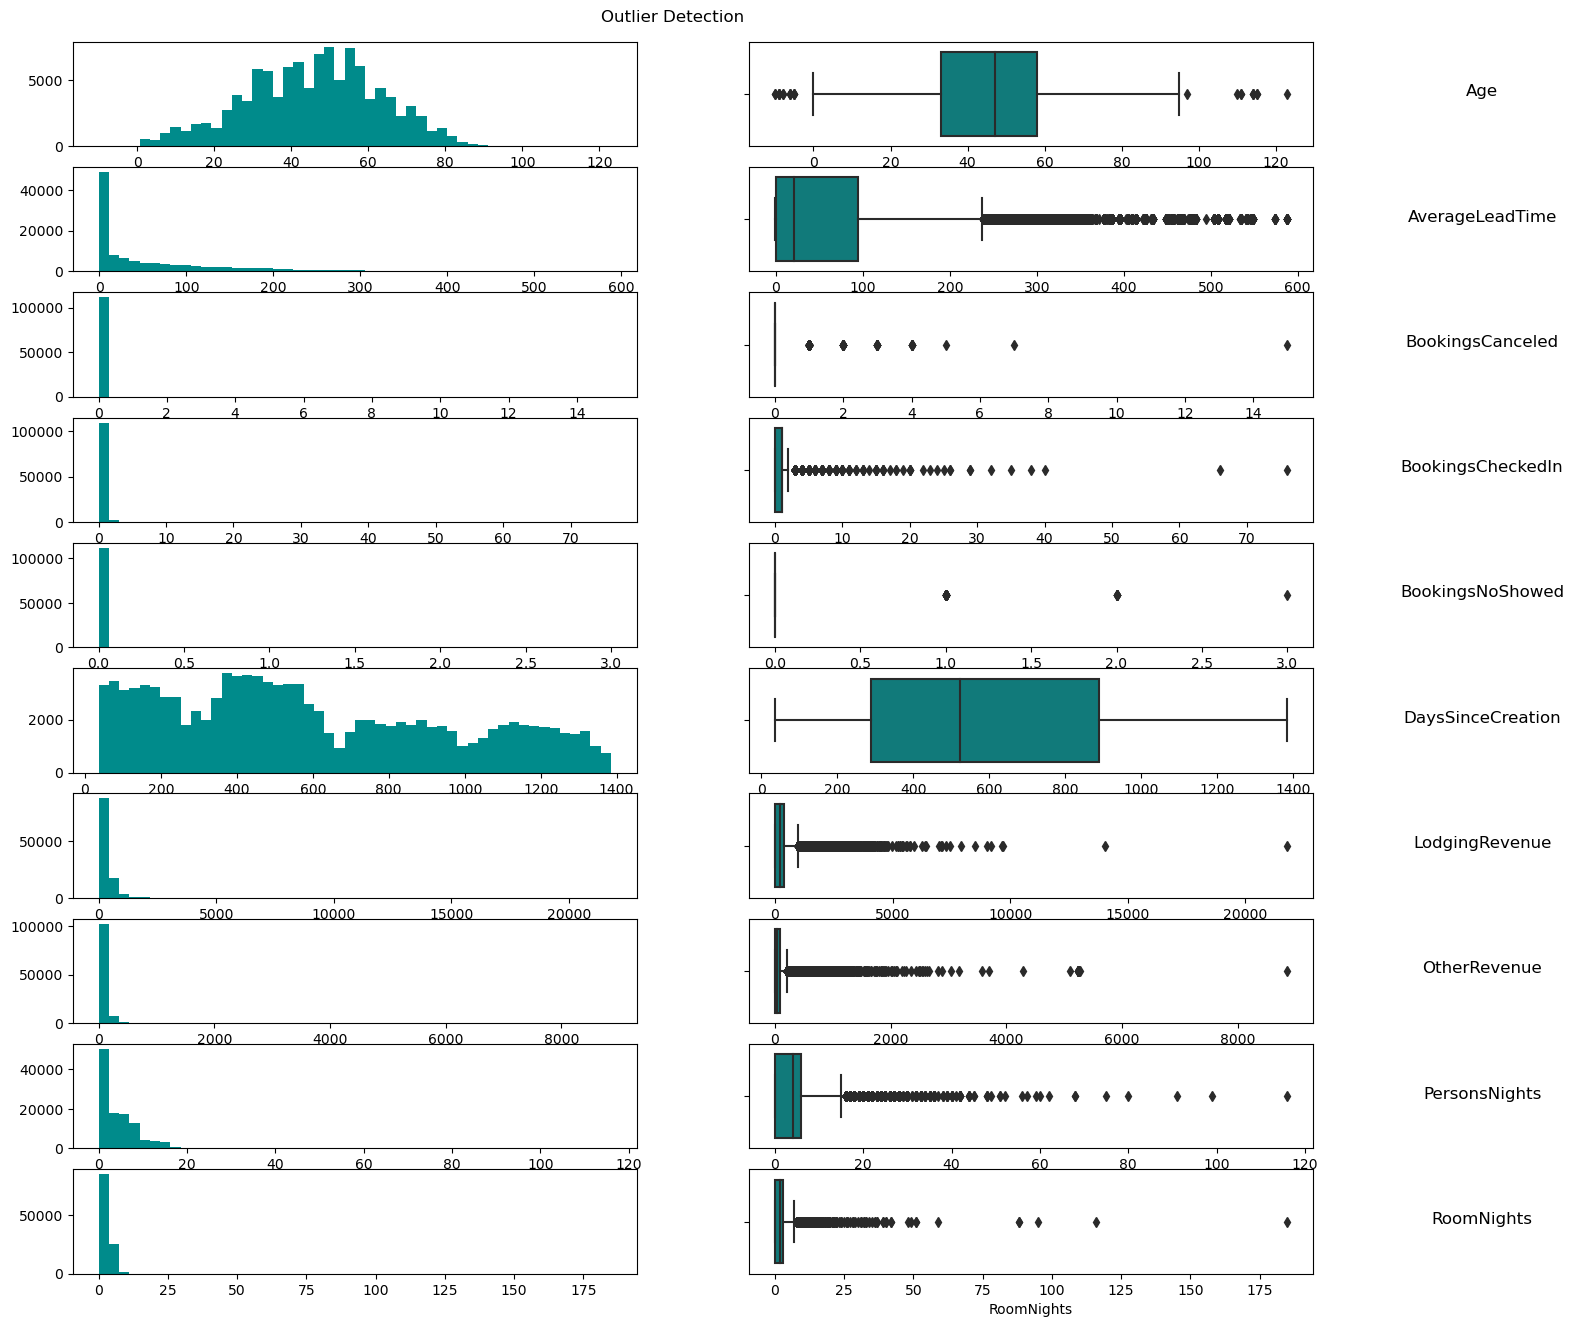

In [34]:
hist_box_maker(df[metric_features],"Outlier Detection",16,16)

>**Analysis of the distributions:**
>
>- Age appearsto have outliers on the lower and higher side. 
>- All other variables except the DaysSinceCreation variable seem to have outliers on the higher side.

**Categorical Variables' Absolute Frequencies**

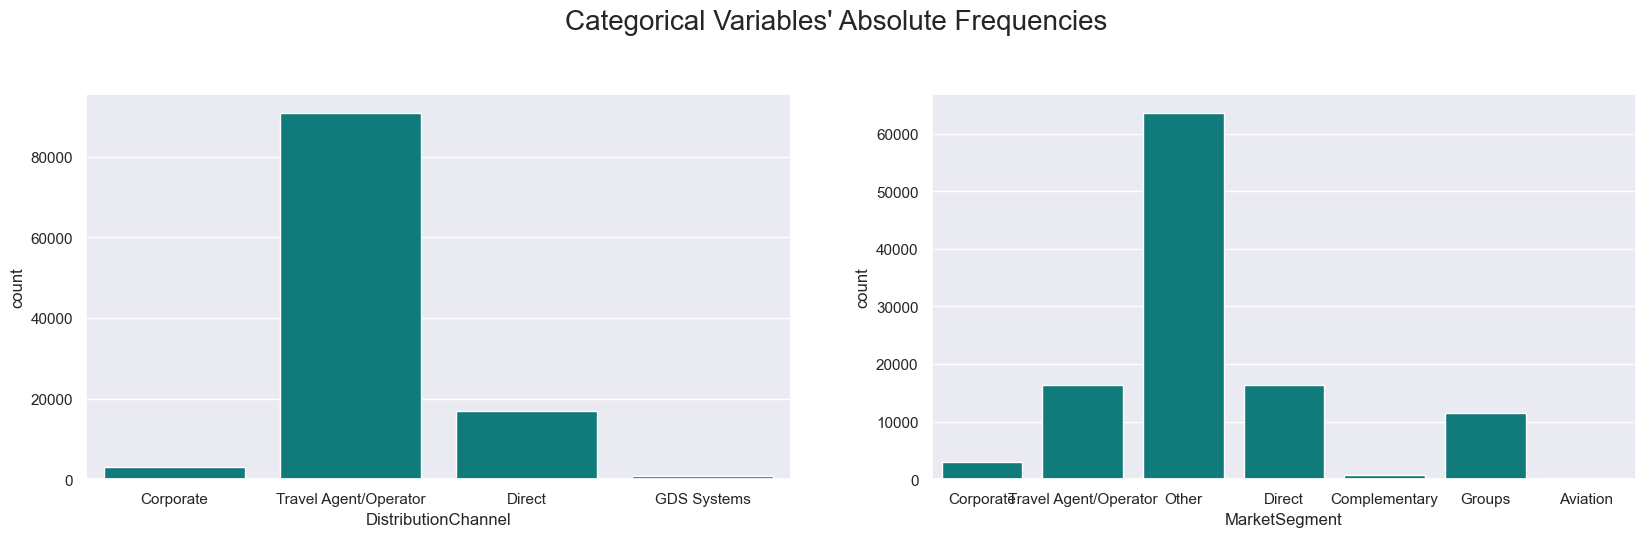

In [35]:
feat_1= ['DistributionChannel','MarketSegment']
categ_abs_freq(2,1,feat_1)

> The main Distribution Channel is distinctly TravelAgent/Operator. 
>
> According to the previous Market Segmentation, large part of the customers was classified as Other, followed by Direct and Travel Agent/Operator.

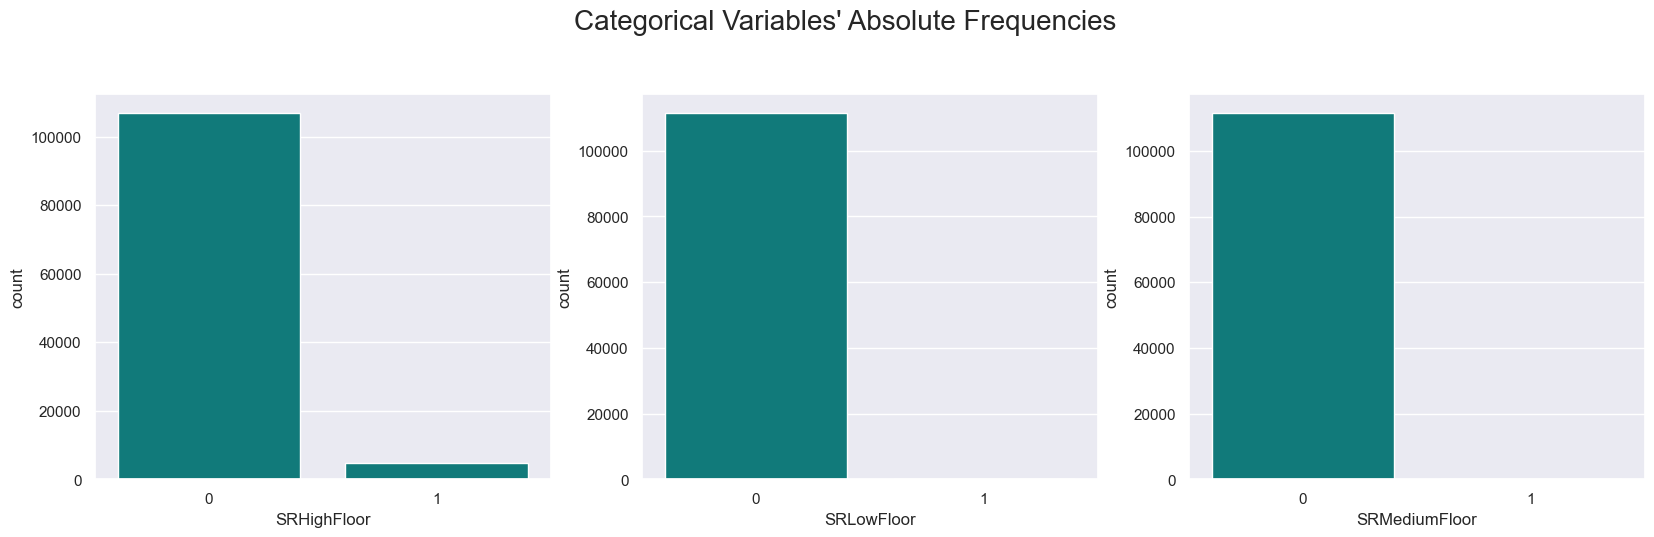

In [36]:
feat_2= ['SRHighFloor','SRLowFloor','SRMediumFloor']
categ_abs_freq(3,1,feat_2)

> In general, customers do not have any preference for the Hotel Floor.

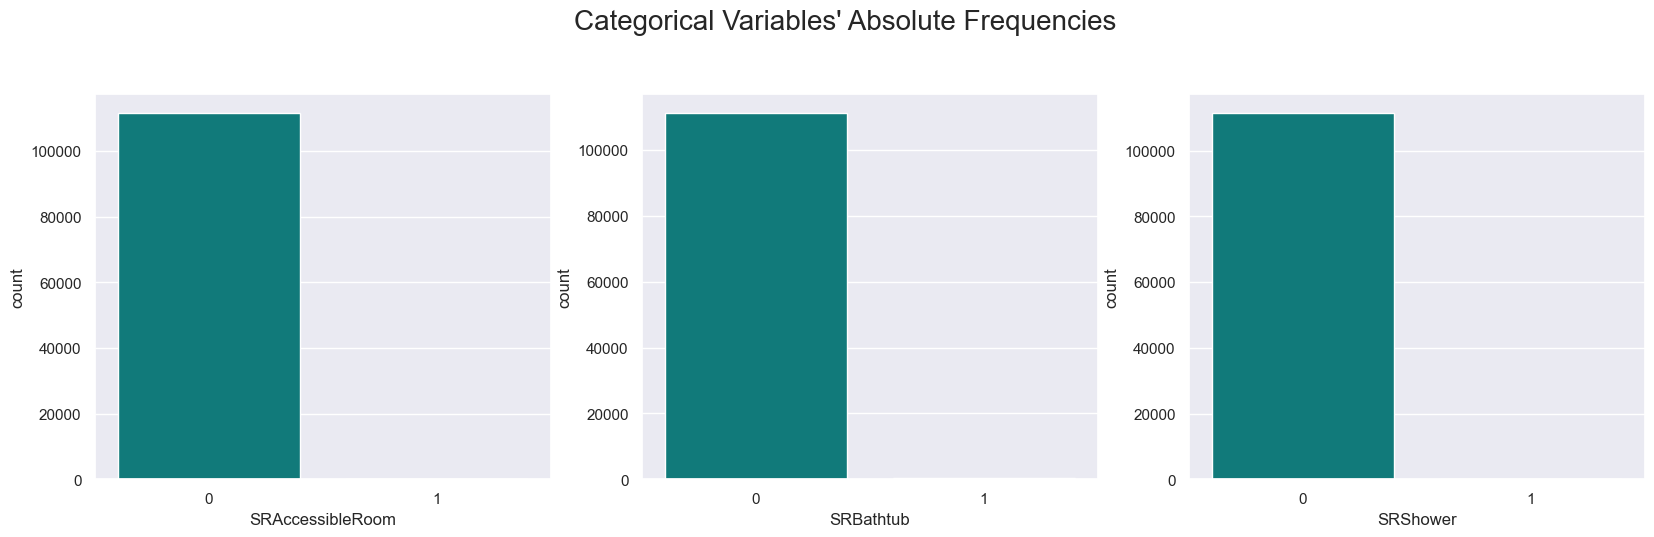

In [37]:
feat_3= ['SRAccessibleRoom','SRBathtub','SRShower']
categ_abs_freq(3,1,feat_3)

> In general, customers do not have any preference regarding room characteristics. 

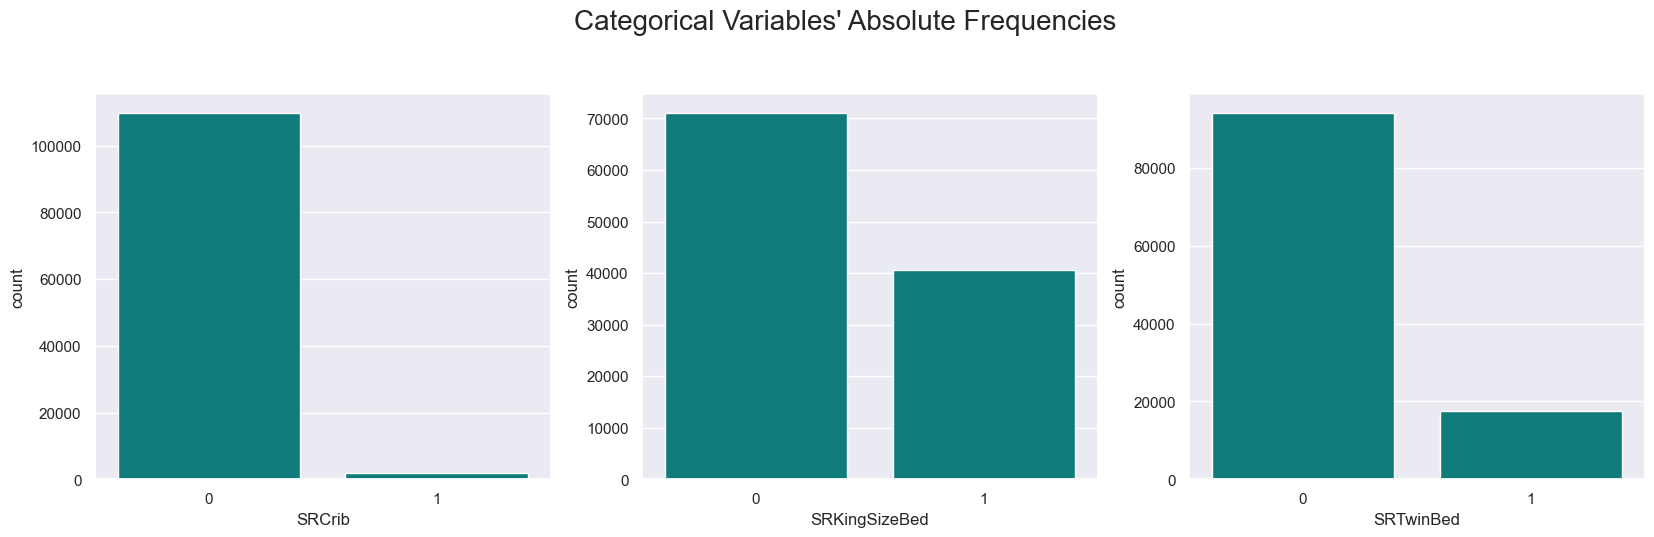

In [38]:
feat_4= ['SRCrib','SRKingSizeBed', 'SRTwinBed']
categ_abs_freq(3,1,feat_4)

> In general, customers do not have any preference regarding bed characteristics. 

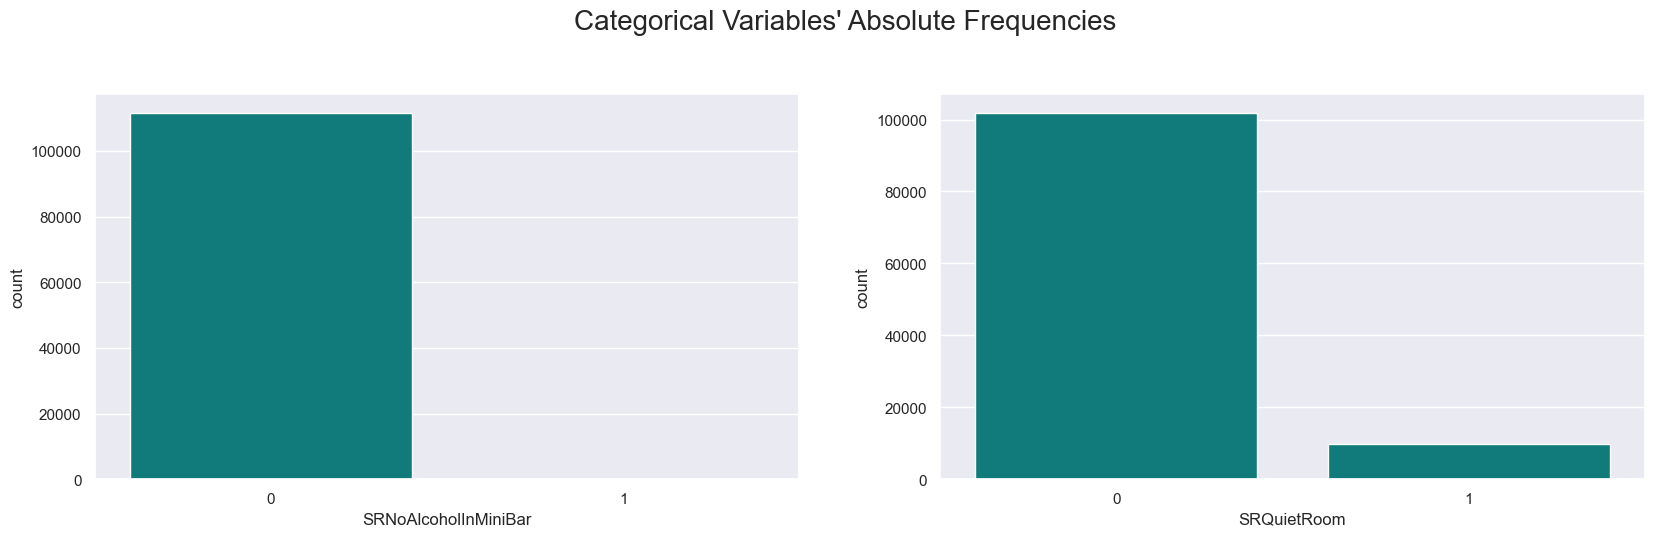

In [39]:
feat_5= ['SRNoAlcoholInMiniBar','SRQuietRoom']
categ_abs_freq(2,1,feat_5)

> In general, customers do not have any preference regarding MiniBar and quietness. 

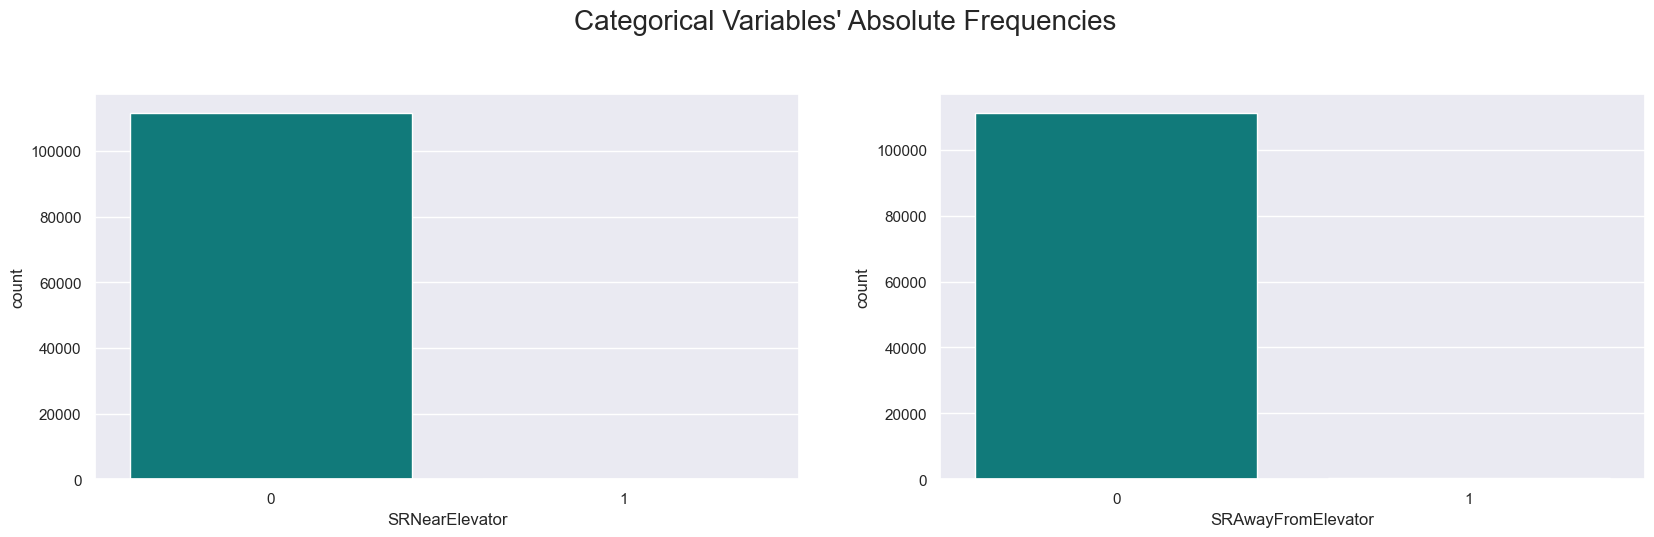

In [40]:
feat_6= ['SRNearElevator','SRAwayFromElevator']
categ_abs_freq(2,1,feat_6)

> In general, customers do not have any preference regarding distance to the Elevator. 

**Metric Features Correlation Matrix** 

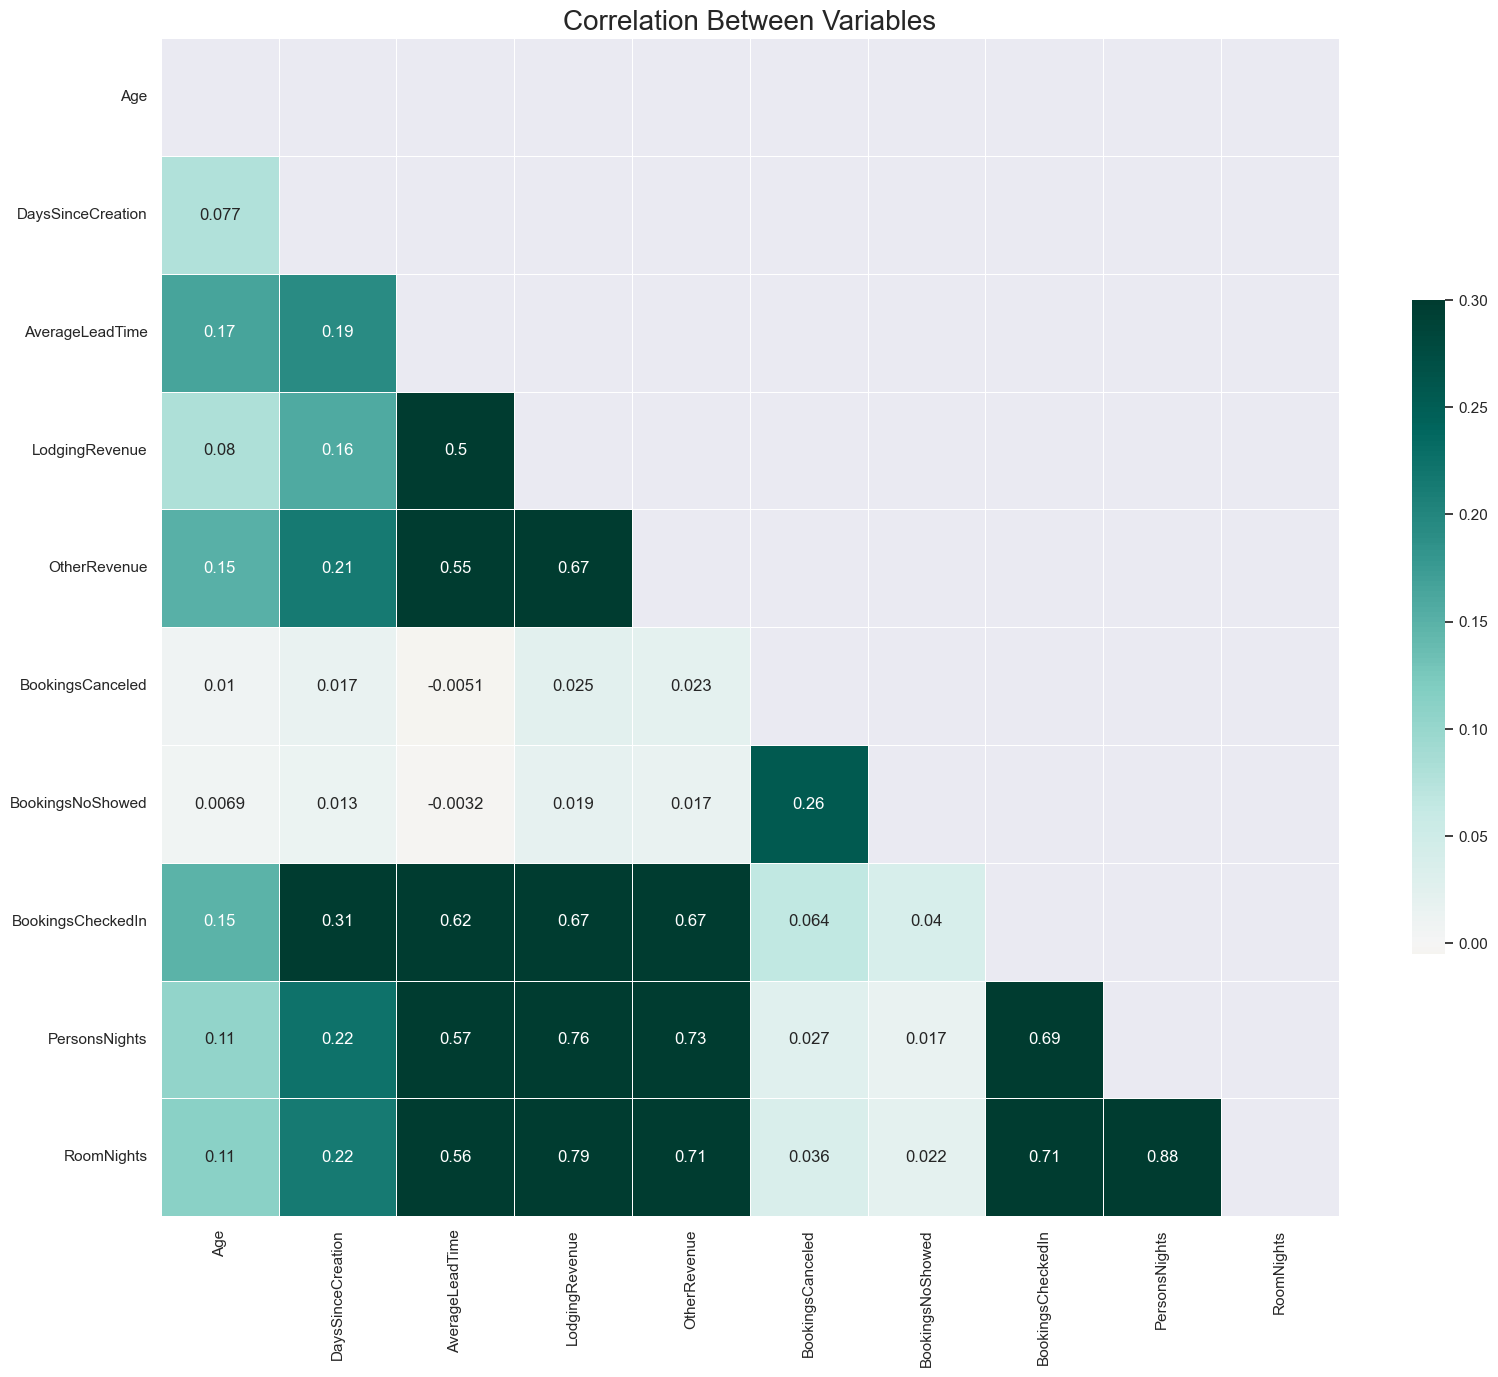

In [41]:
correlation_matrix(df,metric_features)

It appears that there is a strong correlation between the variables **PersonsNights** and **RoomNights**. However, it is important to note that after performing Data Preprocessing, such as Cleaning and Feature Engineering, these correlation values may change.

## 4. Data Preprocessing

### 4.1 Treating Inconsistencies 

In [42]:
df_inc=df.copy()

**1)** Check if there are clients with no Bookings.

In [43]:
((df_inc['BookingsCheckedIn'] == 0) & (df_inc['BookingsCanceled'] == 0) &(df_inc['BookingsNoShowed'] == 0)).value_counts()

False    78536
True     33197
dtype: int64

> This is the list of customers that have not done  a reservations yet, but they are registered in the database. Therefore, they are potential clients. Particularly, we will keep the clients which are registered for less than 1 year in a separate database.

In [44]:
#Saving the list of potential clients 

potential_clients= df_inc[
    (df_inc['BookingsCheckedIn'] == 0) 
    &(df_inc['BookingsCanceled'] == 0) 
    &(df_inc['BookingsNoShowed'] == 0)]

potential_clients=potential_clients[(potential_clients['DaysSinceCreation']<365)]

In [45]:
potential_clients['DistributionChannel'].value_counts()

Travel Agent/Operator    13233
Direct                    2933
Corporate                  120
GDS Systems                 28
Name: DistributionChannel, dtype: int64

> The clients who have never done a reservation in the hotel seem to have as distribution channel the travel agent. This can be explained by partnerships of travel agencies with hotels. 

In [46]:
#Eliminating clients without bookings from the dataframe for clustering 

df_inc= df_inc[~(df_inc['BookingsCheckedIn'] == 0) & (df_inc['BookingsCanceled'] == 0) &(df_inc['BookingsNoShowed'] == 0)]

**2)** Check if there are customers with a value of Age lower than 0: 

In [47]:
pd.DataFrame((df_inc['Age'] <0).value_counts())

Age
False  78326
True      12

> After analysing the 12 clients with negative Age, the majority of customers was registered a long time ago, therefore, one may assume that it was an error in the database changes, therefore the age variable will be substituted by NaN, and in the following steps it will be imputed. 

In [48]:
df_inc.loc[df_inc.Age < 0 , 'Age'] = np.nan

**3)** Check if there clients in which DaysSinceCreation is higher than Age

In [49]:
#Transform the variable DaysSinceCreation to years
df_inc["YearsSinceCreation"] = df_inc["DaysSinceCreation"] / 365.25

#Compare Age with YearsSinceCreation
df_inc[(df_inc["Age"] < df_inc["YearsSinceCreation"])][metric_features]

Age  DaysSinceCreation  AverageLeadTime  LodgingRevenue  OtherRevenue  \
ID                                                                             
4317   2.0               1285               79          335.10          79.0   
11321  2.0               1172              301          128.00          54.0   
14688  0.0               1122              159          330.00         131.0   
16976  0.0               1089               80          466.80         116.5   
20330  0.0               1023               74          366.93         210.0   
25096  2.0                932              158          166.00          28.0   
37419  2.0                751                7          494.00         156.0   
59278  1.0                494              193          288.00          12.0   

       BookingsCanceled  BookingsNoShowed  BookingsCheckedIn  PersonsNights  \
ID                                                                            
4317                  0                 0                  1             12   
11321                 0                 0                  1              2   
14688                 0                 0                  1              6   
16976                 0                 0                  1              8   
20330                 0                 0                  1              6   
25096                 0                 0                  1              4   
37419                 0                 0                  1              6   
59278                 0                 0                  1              2   

       RoomNights  
ID                 
4317            6  
11321           2  
14688           3  
16976           4  
20330           3  
25096           2  
37419           3  
59278           2

> By analysing the clients in which YearsSinceCreation is higher than Age, it is possible to conclude that it was probably a mistake in the database, since these are old clients. Therefore, it was decided to substitute the Age by NaN, and later on the value will be imputed. 

In [50]:
df_inc.loc[df_inc.Age < df_inc.YearsSinceCreation , 'Age'] = np.nan

**4)** Check if there are cases in which the BookingsCheckedIN is higher than RoomNights and PersonNights. 

> It is unrealistic to have a larger number of Check-In than the lenght of the stay. At least, these are equal. 

In [51]:
pd.DataFrame((df_inc['BookingsCheckedIn'] > df_inc['RoomNights']).value_counts())

0
False  78333
True       5

> Since there is only 5 cases, it was decided to delete it.

In [52]:
df_inc=df_inc[~(df_inc['BookingsCheckedIn'] > df_inc['RoomNights'])]

In [53]:
print('Number of rows removed until now:', df.shape[0]-df_inc.shape[0])
print('Percentage of data kept after removing missing values:', np.round(df_inc.shape[0] / df.shape[0], 4))

Number of rows removed until now: 33400
Percentage of data kept after removing missing values: 0.7011


In [54]:
pd.DataFrame((df_inc['BookingsCheckedIn'] > df_inc['PersonsNights']).value_counts())

0
False  78327
True       6

> Since it is impossible to have more Check-in than PersonNights, we decide to remove those cases. Moreover, some cases do not appear to have any PersonNights 

In [55]:
df_inc=df_inc[~(df_inc['BookingsCheckedIn'] > df_inc['PersonsNights'])]

print('Number of rows removed until now:', df.shape[0]-df_inc.shape[0])
print('Percentage of data kept after removing missing values:', np.round(df_inc.shape[0] / df.shape[0], 4))

Number of rows removed until now: 33406
Percentage of data kept after removing missing values: 0.701


**5)** Check if there are PersonNights equal to 0 with Check-in 

In [56]:
((df_inc['PersonsNights']==0) & (df_inc['BookingsCheckedIn']>0)).value_counts()

False    78327
dtype: int64

**6)** Check if there are RoomNights equal to 0 with Check-in 

In [57]:
((df_inc['RoomNights']==0) & (df_inc['BookingsCheckedIn']>0)).value_counts()

False    78327
dtype: int64

**7)** Check if RoomNights is higher than PersonNights 

> Considering that each Room can have one or more persons, it means that RoomNights can never be higher than PersonNights. Because it is unreasonable to book a room and no one is staying there. 

In [58]:
(df_inc['RoomNights'] > df_inc['PersonsNights']).value_counts()

False    78313
True        14
dtype: int64

> The decision is to switch the columns in these observations. 

In [59]:
df_inc.loc[df_inc['RoomNights'] > df_inc['PersonsNights'], ['RoomNights', 'PersonsNights']] = df_inc.loc[df_inc['RoomNights'] > df_inc['PersonsNights'], ['PersonsNights', 'RoomNights']].values

**8)** Check cases where LodgingRevenue is null but RoomNights or PersonsNights is higher than 0 

In [60]:
((df_inc['LodgingRevenue']==0) & ((df_inc['RoomNights']>0) | (df_inc['PersonsNights']>0))).value_counts()

False    77773
True       554
dtype: int64

> The cases in which the LogdingRevenue is 0 might be related with staff nights offered by the Hotel, therefore, these are not useful for clustering. Hence, the observations will be eliminated.

In [61]:
df_inc= df_inc[~((df_inc['LodgingRevenue']==0) & ((df_inc['RoomNights']>0) | (df_inc['PersonsNights']>0)))]

print('Number of rows removed until now:', df.shape[0]-df_inc.shape[0])
print('Percentage of data kept after removing missing values:', np.round(df_inc.shape[0] / df.shape[0], 4))

Number of rows removed until now: 33960
Percentage of data kept after removing missing values: 0.6961


**9)** Check cases where AverageLeadTime is negative

In [62]:
((df_inc['AverageLeadTime']<0)).value_counts()

False    77760
True        13
Name: AverageLeadTime, dtype: int64

>The decision is to drop these observations.

In [63]:
df_inc= df_inc[~(df_inc['AverageLeadTime']<0)]

print('Number of rows removed until now:', df.shape[0]-df_inc.shape[0])
print('Percentage of data kept after removing missing values:', np.round(df_inc.shape[0] / df.shape[0], 4))

Number of rows removed until now: 33973
Percentage of data kept after removing missing values: 0.6959


In [64]:
#Updating the original datafame 

df=df_inc

### 4.2 Treating Duplicates

In [65]:
df_dup=df.copy()

In [66]:
df_dup.duplicated().sum() 


15

> First, the 15 observations which are exactly the same (repeated rows), we will drop the duplicates.

In [67]:
df_dup.drop_duplicates(inplace=True)

> Second, the cases in which there are repeated DocIDHash are also incorrect, since these variable is a unique identifier of each client.

In [68]:
df_dup[(df_dup.duplicated(subset='DocIDHash'))]

Nationality   Age  DaysSinceCreation  \
ID                                            
56             PRT   NaN               1385   
60             PRT   NaN               1385   
66             PRT   NaN               1385   
70             PRT   NaN               1385   
114            PRT   NaN               1384   
...            ...   ...                ...   
111351         FRA  53.0                 39   
111402         DEU  73.0                 39   
111553         PRT   NaN                 38   
111572         PRT  35.0                 38   
111718         NLD  56.0                 37   

                                                 NameHash  \
ID                                                          
56      0xD27550946D0D4D9A2C8ACABC25F3EB2E71340638AB58...   
60      0xDB729ABCD594E05BE66D31E3E7A89CF84A107E637368...   
66      0x3E9698E7C95793528DF6AFE454C1D7D1B6E70B5AB13A...   
70      0x9ECF917572A3CA3BAFC5C7189CC7B31B04F5E87D4BE0...   
114     0x05B7147430D7434C6E95478A423CF6C1664B6051E70B...   
...                                                   ...   
111351  0x5A19B8585FAE583B6F76EC19B1BD53217ABB0B4765DE...   
111402  0x888CAD43BCBFEDF1D30759717E1B244A7BD81D55FF81...   
111553  0xBC66C5A2A0C25C38CF99F5BF605A913382C4FF3B7960...   
111572  0x87E907A2D43E25D3E3D56D7016D9447D4D646CCD7CFE...   
111718  0x3509CDB2095FA9E2DE9E28316176130A69C2DE970EA8...   

                                                DocIDHash  AverageLeadTime  \
ID                                                                           
56      0xE3B0C44298FC1C149AFBF4C8996FB92427AE41E4649B...               97   
60      0xE3B0C44298FC1C149AFBF4C8996FB92427AE41E4649B...                1   
66      0xE3B0C44298FC1C149AFBF4C8996FB92427AE41E4649B...                6   
70      0xE3B0C44298FC1C149AFBF4C8996FB92427AE41E4649B...               58   
114     0xE3B0C44298FC1C149AFBF4C8996FB92427AE41E4649B...               89   
...                                                   ...              ...   
111351  0xB76B13D00B2EACE3286BD04EB765F97FDC2C1A54FF53...               64   
111402  0x5C663955C031CD8956B82C3105C2AF0D8DDA97677FC3...              304   
111553  0xE3B0C44298FC1C149AFBF4C8996FB92427AE41E4649B...              204   
111572  0x4AAF782C86F1B4F015C85E005271AF3FAF25AEA6DFF6...                2   
111718  0x311C32AFC5B4F0815FAAE98F45D37CB26E16E43B51BF...               65   

        LodgingRevenue  OtherRevenue  BookingsCanceled  BookingsNoShowed  ...  \
ID                                                                        ...   
56              213.52         11.50                 0                 0  ...   
60              123.00         12.00                 0                 0  ...   
66              141.50         13.50                 0                 0  ...   
70              294.00         77.70                 0                 0  ...   
114             201.46         48.50                 0                 0  ...   
...                ...           ...               ...               ...  ...   
111351          223.00         16.00                 0                 0  ...   
111402          168.00         66.00                 0                 0  ...   
111553          381.60         91.20                 0                 0  ...   
111572          113.00         12.00                 0                 0  ...   
111718          665.80        124.65                 0                 0  ...   

        SRBathtub  SRShower  SRCrib SRKingSizeBed SRTwinBed  SRNearElevator  \
ID                                                                            
56              0         0       0             0         0               0   
60              0         0       0             0         0               0   
66              0         0       0             0         0               0   
70              0         0       0             0         0               0   
114             0         0       0             0         

In [69]:
count_duplicates= df_dup.loc[(df_dup.duplicated(subset='DocIDHash')),'DocIDHash'].value_counts()
count_duplicates

0xE3B0C44298FC1C149AFBF4C8996FB92427AE41E4649B934CA495991B7852B855    2742
0xA486FBACF4B4E5537B026743E3FDFE571D716839E758236F42950A61FE6B922B      21
0x2B17E9D2CCEF2EA0FE752EE345BEDFB06741FFC8ECECF45D6BBDBAF9A274FF52      17
0x2A14D03A4827C67E0D39408F103DB417AD496DCE6158F8309E6281185C042003      13
0x469CF1F9CF8C790FFA5AD3F484F2938CBEFF6435BCFD734F687EC6D1E968F076      13
                                                                      ... 
0x165221E3C1BCA203BE5D4B3E7C59A71D6515057212B938916086BA1AAA9E5A2A       1
0x8A5082243A08CCA490E7F03C9884661200DA1C72C474CB40A332F69C5A47CFBC       1
0x74E42E07A5D8D3657E5FCD7DB9EFF76DABED93BB5951D60EDF5541923F232383       1
0x68FE27EF2DC0C9777AB1B2B6040E6FCA2CCF5007B6B209D6C079380C14F2B1F2       1
0x311C32AFC5B4F0815FAAE98F45D37CB26E16E43B51BFCCE1753B5A42471153E0       1
Name: DocIDHash, Length: 2046, dtype: int64

> It is important to understand how many times each DocIDHash is repeated, for instance, one DocIDHash is repeated 2742 times, therefore, this should be treated separately from the other cases, as it is an absurd value. 

In [70]:
#Creating a dataframe with the atypical case of duplicates
atypical_duplicate= df_dup[df_dup.DocIDHash== '0xE3B0C44298FC1C149AFBF4C8996FB92427AE41E4649B934CA495991B7852B855']

#Removing the atypical case from the original dataframe
df_dup= df_dup[df_dup['DocIDHash']!= '0xE3B0C44298FC1C149AFBF4C8996FB92427AE41E4649B934CA495991B7852B855']



#Aggregating the duplicates
atypical_duplicate= atypical_duplicate.groupby(['DocIDHash'], as_index=False).agg({'Nationality': 'last',
                                                                                    'Age': 'max',
                                                                                    'DaysSinceCreation': 'max', 
                                                                                    'YearsSinceCreation':'max',
                                                                                    'NameHash': 'first',
                                                                                    'AverageLeadTime': 'mean',
                                                                                    'LodgingRevenue': 'max',
                                                                                    'OtherRevenue': 'max',
                                                                                    'BookingsCanceled': 'max',
                                                                                    'BookingsNoShowed': 'max',
                                                                                    'BookingsCheckedIn': 'max',
                                                                                    'PersonsNights': 'max',
                                                                                    'RoomNights': 'max',
                                                                                    'DistributionChannel': 'last',
                                                                                    'MarketSegment': 'last',
                                                                                    'SRHighFloor': 'max',
                                                                                    'SRLowFloor': 'max',
                                                                                    'SRAccessibleRoom': 'max',
                                                                                    'SRMediumFloor': 'max',
                                                                                    'SRBathtub': 'max',
                                                                                    'SRShower': 'max',
                                                                                    'SRCrib': 'max',
                                                                                    'SRKingSizeBed': 'max',
                                                                                    'SRTwinBed': 'max',
                                                                                    'SRNearElevator': 'max',
                                                                                    'SRAwayFromElevator': 'max',
                                                                                    'SRNoAlcoholInMiniBar': 'max',
                                                                                    'SRQuietRoom': 'max'})




> In the remaining cases, an aggregation was perfomed following some conditions: 
> - Nationality, DistributionChannel, MarketSegment: the last value registered, since it must be the updated one 
> - Booking, Revenue, and Nights related: sum the different registers, as they correspond to the same person in different stays/no stays in the hotel
> - Age, Days Since Creation: the maximum value was kept, because it might be the most recent registered 
> - SR: maintain the maximum to keep to perserve the preference of the customers.

In [71]:
#Creating a data frame with the duplicates separated 

filter_duplicates= df_dup[(df_dup.duplicated(subset='DocIDHash'))]

In [72]:
#Remove the duplicates from the origal dataframe 

df_dup=df_dup[~df_dup.duplicated(subset='DocIDHash', keep=False)]

In [73]:
#Aggregating the duplicates
filter_duplicates= filter_duplicates.groupby(['DocIDHash'], as_index=False).agg({'Nationality': 'last',
                                                                                    'Age': 'max',
                                                                                    'DaysSinceCreation': 'max', 
                                                                                    'YearsSinceCreation':'max',
                                                                                    'NameHash': 'first',
                                                                                    'AverageLeadTime': 'mean',
                                                                                    'LodgingRevenue': 'sum',
                                                                                    'OtherRevenue': 'sum',
                                                                                    'BookingsCanceled': 'sum',
                                                                                    'BookingsNoShowed': 'sum',
                                                                                    'BookingsCheckedIn': 'max',
                                                                                    'PersonsNights': 'sum',
                                                                                    'RoomNights': 'sum',
                                                                                    'DistributionChannel': 'last',
                                                                                    'MarketSegment': 'last',
                                                                                    'SRHighFloor': 'max',
                                                                                    'SRLowFloor': 'max',
                                                                                    'SRAccessibleRoom': 'max',
                                                                                    'SRMediumFloor': 'max',
                                                                                    'SRBathtub': 'max',
                                                                                    'SRShower': 'max',
                                                                                    'SRCrib': 'max',
                                                                                    'SRKingSizeBed': 'max',
                                                                                    'SRTwinBed': 'max',
                                                                                    'SRNearElevator': 'max',
                                                                                    'SRAwayFromElevator': 'max',
                                                                                    'SRNoAlcoholInMiniBar': 'max',
                                                                                    'SRQuietRoom': 'max'})



In [74]:
#Add the observations with the duplicates solved to the original dataset

df_dup=pd.concat([df_dup,filter_duplicates,atypical_duplicate])

In [75]:
#Updating the original dataframe 

df=df_dup.copy()

### 4.3 Treating Missing Values

In [76]:
df_mv = df.copy()

In [77]:
df_mv.isna().sum()

Nationality               0
Age                     232
DaysSinceCreation         0
NameHash                  0
DocIDHash                 0
AverageLeadTime           0
LodgingRevenue            0
OtherRevenue              0
BookingsCanceled          0
BookingsNoShowed          0
BookingsCheckedIn         0
PersonsNights             0
RoomNights                0
DistributionChannel       0
MarketSegment             0
SRHighFloor               0
SRLowFloor                0
SRAccessibleRoom          0
SRMediumFloor             0
SRBathtub                 0
SRShower                  0
SRCrib                    0
SRKingSizeBed             0
SRTwinBed                 0
SRNearElevator            0
SRAwayFromElevator        0
SRNoAlcoholInMiniBar      0
SRQuietRoom               0
YearsSinceCreation        0
dtype: int64

> Regarding the variable Age, the NaN will be filled in with the median

In [78]:
df_mv.fillna(df_mv.median(numeric_only=True), inplace=True)

In [79]:
#Update the original dataframe 
df=df_mv

### 4.3. Fixing Data types 

As the goal is to report age on groups, we decided it would be best to round up to the nearest whole number and then potentially later to bin.

In [80]:
df.Age= df.Age.astype('int')

### 4.3 Outlier Treatment

In [81]:
df_out = df.copy()

*Methods Used*: 

1. DBSCAN 
2. Manual Filtering

In [82]:
df_out= df_out[(df_out['Age']>17)&(df_out['Age']<90)]

print('Number of rows removed until now:', train_hotel.shape[0]-df_out.shape[0])
print('Percentage of data kept after removing missing values:', np.round(df_out.shape[0] / train_hotel.shape[0], 4))

Number of rows removed until now: 40653
Percentage of data kept after removing missing values: 0.6362


> **DBSCAN**

x:  70628
y:  0.15511009116001875


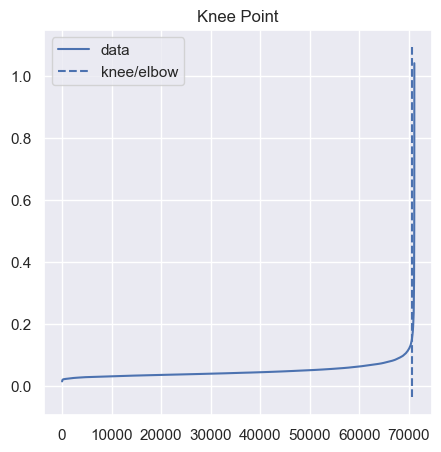

In [83]:
#Code in adapted from:
#https://medium.com/@tarammullin/dbscan-parameter-estimation-ff8330e3a3bd#:~:text=Generally%2C%20MinPts%20should%20be%20greater,et%20al.%2C%201998).

#Creating an auxiliary dataframe with the metric features
df_dbscan = df_out.copy()
aux = df_dbscan[metric_features].copy()

#Scale the data to apply DBSCAN
scaler(aux, MinMaxScaler(), metric_features)

#The number of neighbors should be two times the number of dimensions of aux 
min_points = 2*aux.shape[1]

#Find the number of 'eps'
neighbors = NearestNeighbors(n_neighbors = 20)
neighbors.fit(aux)
distances, _ = neighbors.kneighbors(aux)
distances = np.sort(distances[:,-1])

#Source: https://kneed.readthedocs.io/en/stable/index.html
x=range(len(distances))
y=distances


kn = KneeLocator(x, y, curve='convex', direction='increasing')

knee_x = kn.knee
knee_y = kn.knee_y

kn.plot_knee(figsize=(5,5))

print('x: ', knee_x)
print('y: ', knee_y)

#Define the number of 'eps'
radius = knee_y

> The ideal number for 'eps' will be the elbow of the curve, which corresponds to the value of 0.16, approximately. 
>
> The minimum of points in the neighbourhood should be 2*dimension of the data set aux

In [84]:
#Apply DBSCAN 
model = DBSCAN(eps=radius, min_samples=min_points)
model.fit(aux)
cluster_labels = model.labels_
aux['labels'] = cluster_labels

In [85]:
#Remove the outliers identified by DBSCAN from the original dataframe 

filter_dbscan = (aux['labels'] != -1)

df_out=df_out[filter_dbscan]

print('Number of rows removed until now:', train_hotel.shape[0]-df_out.shape[0])
print('Percentage of data kept after removing missing values:', np.round(df_out.shape[0] / train_hotel.shape[0], 4))

Number of rows removed until now: 40838
Percentage of data kept after removing missing values: 0.6345


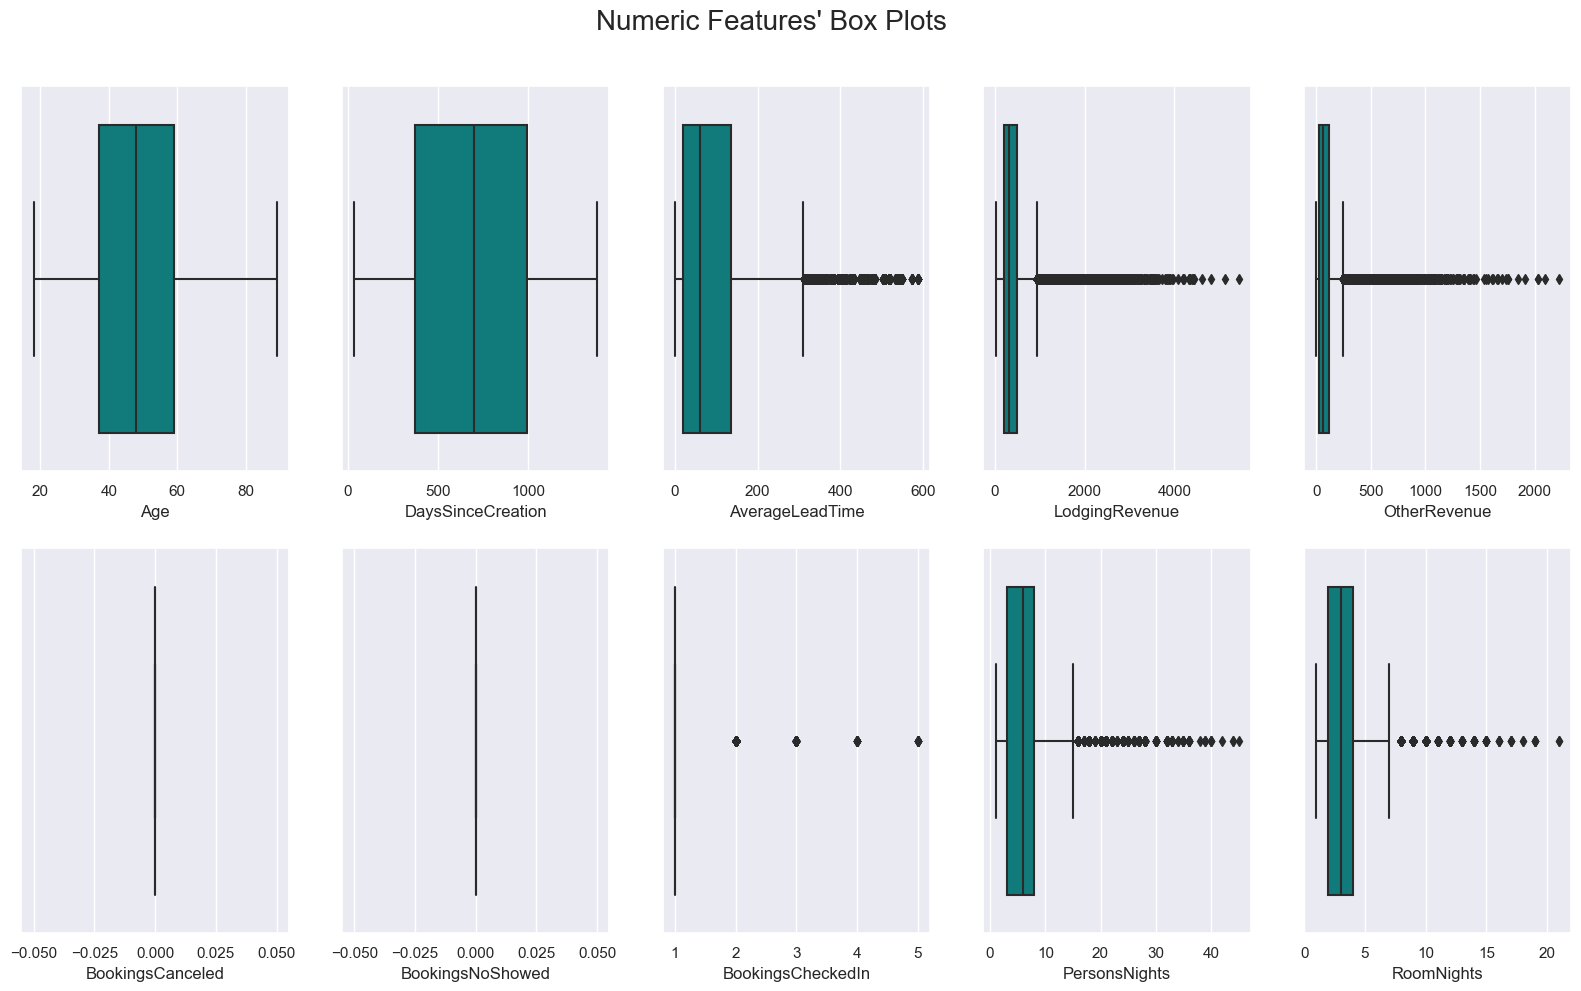

In [86]:
plot_boxplot (df_out, metric_features)

> **Manual Filtering**

In [87]:
filter_manual=(
(df_out['LodgingRevenue']<4000)
    &
(df_out['OtherRevenue']<1400)
    &
(df_out['PersonsNights']<29)
    &
(df_out['RoomNights']<15)
)


df_out=df_out[filter_manual]

print('Number of rows removed until now:', train_hotel.shape[0]-df_out.shape[0])
print('Percentage of data kept after removing missing values:', np.round(df_out.shape[0] / train_hotel.shape[0], 4))

Number of rows removed until now: 41006
Percentage of data kept after removing missing values: 0.633


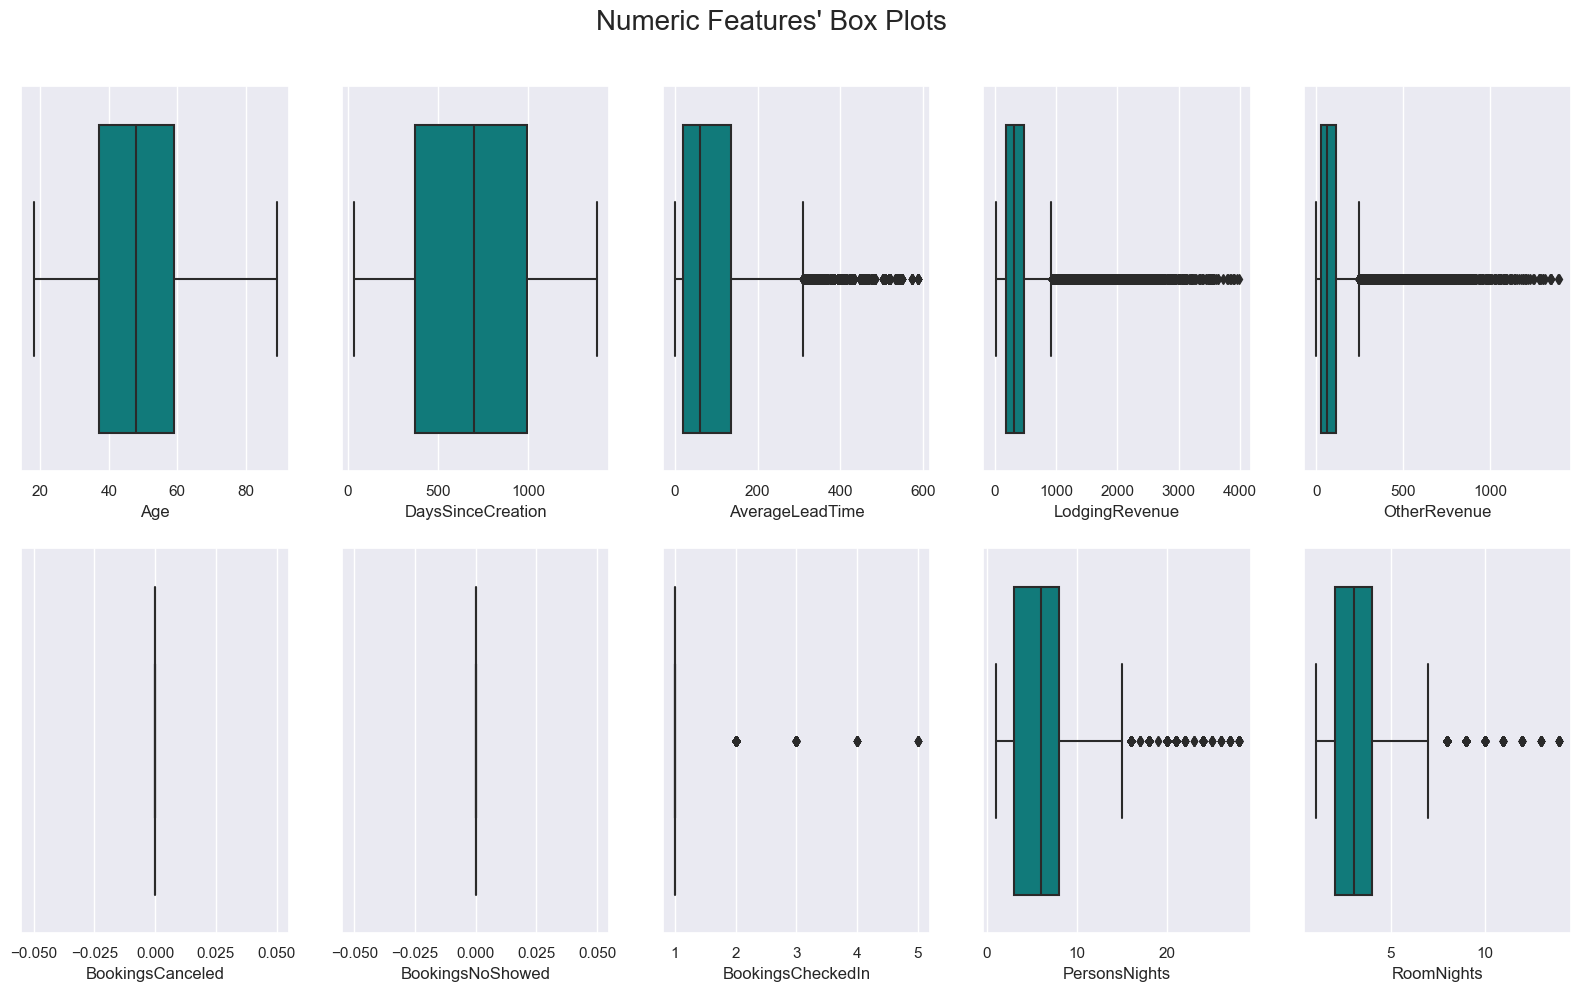

In [88]:
plot_boxplot (df_out, metric_features)

In [89]:
#Updating the original dataframe 
df=df_out

### 4.4 Feature Engineering

In [90]:
df_feat= df.copy()

**Total Revenue** 

- Combines LodgingRevenue and OtherRevenue to get the total revenue generated by each customer.

In [91]:
df_feat['TotalRevenue'] = df_feat['LodgingRevenue'] + df_feat['OtherRevenue']

**Booking Rate** 

- Percentage of bookings that were not canceled or no-showed.

- Sum of BookingsCheckedIn by the sum of (BookingsCanceled + BookingsNoShowed + BookingsCheckedIn)

In [92]:
df_feat['BookingRate'] = df_feat['BookingsCheckedIn']/ (df_feat['BookingsCanceled'] + df_feat['BookingsNoShowed']+df_feat['BookingsCheckedIn'])

In [93]:
not_full_bookings = df_feat[df_feat['BookingRate'] != 1] #0 cases

**Revenue per Person** 

- Divides the total revenue generated by the number of PersonsNights to get the revenue per person.

In [94]:
df_feat['RevenuePerson'] = df_feat['TotalRevenue'] / df_feat['PersonsNights']

**Room Rate per customer**

- Divides the total revenue by the number of RoomNights to get the average rate per customer

In [95]:
df_feat['RoomRate']= df_feat['TotalRevenue'] / df_feat['RoomNights']

**Revenue Per Stay** 

- Average revenue per stay for each customer

In [96]:
df_feat['RevenuePerStay'] = (df_feat['LodgingRevenue'] + df_feat['OtherRevenue'])/ (df_feat['BookingsCheckedIn'])

**Room Type** 

- Combines all the features related to the type of room booked

In [97]:
def room_type(row):
    room_types = []
    if row['SRTwinBed'] == 1: 
        room_types.append('Twin') #append if the value in that column is 1
    if row['SRKingSizeBed'] == 1:
        room_types.append('King')
    if row['SRCrib'] == 1:
        room_types.append('Crib')

    if len(room_types) > 0:
        return '/'.join(room_types) #if the customer booked more than one room type
    else:
        return 'Unknown'

df_feat['RoomType'] = df_feat.apply(room_type, axis=1) #apply this function to each row

In [98]:
df_feat[df_feat['RoomType'] == "Unknown"] # 34612

Nationality  Age  DaysSinceCreation  \
4            FRA   61               1385   
6            JPN   55               1385   
10           IRL   26               1385   
12           FRA   59               1385   
14           ESP   43               1385   
...          ...  ...                ...   
2033         USA   45                847   
2038         BRA   45                543   
2039         FRA   54                948   
2042         ESP   46               1323   
2043         NLD   43                630   

                                               NameHash  \
4     0xC45D4CD22C58FDC5FD0F95315F6EFA5A6E7149187D49...   
6     0xA3CF1A4692BE0A17CFD3BFD9C07653556BDADF5F4BE7...   
10    0x9BEECEE0C18B0957C7424443643948E99A0EC8326EF9...   
12    0x9773ECFA3572DCCFE097CC5805ECE3AEEDBD1B66BA1B...   
14    0x22CB5B109DC9801904205B8262ADEE0331BF6DAFB62C...   
...                                                 ...   
2033  0xB87379CEFD744775B5A1BB015AF73520363D2BC2D58B...   
2038  0x9FFF143B3DA18031834E600881192C013199D8078340...   
2039  0x605AC74985E7C6F034282DC43745C94E738D1E5C6AA8...   
2042  0x9A6D4033D479DB80B1EE58A38193FC1481E0943A249B...   
2043  0xC031D142FB99F0722FE4DFD4298AA57CC67C89C68E62...   

                                              DocIDHash  AverageLeadTime  \
4     0x8E59572913BB9B1E6CAA12FA2C8B7BF387B1D1F3432E...             93.0   
6     0x506065FBCE220DCEA4465C7310A84F04165BCB5906DC...             58.0   
10    0x199C61A5442D08987001E170B74D244DF6AF1FC9AE92...             96.0   
12    0x12F12B83127CC791501A7CA3A4639083297467BB8641...             60.0   
14    0x7ECC2FE7D7953C6903AF4418A122C998F2ED706D029E...             87.0   
...                                                 ...              ...   
2033  0xFEC582396EFA899A05C551058CFEAA8B10B3AB683784...            196.0   
2038  0xFF427A7BC55D1006BAA9272A11816C3BAB7E4014C565...             22.0   
2039  0xFF7D139D7D9A51725FED697A81E4C4BA84DF7B9CBAAB...             30.0   
2042  0xFFC8E8CE49A4A882225B210B488EB8959153A1CDD538...              0.0   
2043  0xFFD0ED500662142AB2E236798F4E5772353C5CA89DF3...             75.0   

      LodgingRevenue  OtherRevenue  BookingsCanceled  BookingsNoShowed  ...  \
4              240.0          60.0                 0                 0  ...   
6              230.0          24.0                 0                 0  ...   
10             174.0          69.0                 0                 0  ...   
12             292.0          81.0                 0                 0  ...   
14             327.7          48.0                 0                 0  ...   
...              ...           ...               ...               ...  ...   
2033           171.0          37.0                 0                 0  ...   
2038           232.0          20.0                 0                 0  ...   
2039           116.0          29.0                 0                 0  ...   
2042           261.0          38.0                 0                 0  ...   
2043           519.0         245.0                 0                 0  ...   

      SRAwayFromElevator  SRNoAlcoholInMiniBar  SRQuietRoom  \
4                      0                     0            0   
6                      0                     0            0   
10                     0                     0            0   
12                     0                     0            0   
14                     0                     0            0   
...                  ...                   ...          ...   
2033                   0                     0            1   
2038                   0                     0            1   
2039                   0                     0            0   
2042                   0                     0            0   
2043                   0                     0            0   

     YearsSinceCreation TotalRevenue  BookingRate  RevenuePerson    RoomRate  \
4              3.791923        300.0          1.0        30.0000   6

**FloorPreference** 

- Combines SRHighFloor, SRLowFloor and SRMediumFloor.

In [99]:
def floor_preference(row):
    floors = []
    if row['SRHighFloor'] == 1:
        floors.append('High')
    if row['SRLowFloor'] == 1:
        floors.append('Low')
    if row['SRMediumFloor'] == 1:
        floors.append('Middle')

    if len(floors) > 0:
        return max(floors) #return the highest floor preference for each customer
    else:
        return 'Unknown'

df_feat['FloorPreference'] = df_feat.apply(floor_preference, axis=1)

In [100]:
df_feat[df_feat['FloorPreference'] == "Unknown"] # 67584

Nationality  Age  DaysSinceCreation  \
4            FRA   61               1385   
6            JPN   55               1385   
8            FRA   33               1385   
10           IRL   26               1385   
12           FRA   59               1385   
...          ...  ...                ...   
2040         PRT   49                205   
2041         PRT   57               1119   
2042         ESP   46               1323   
2043         NLD   43                630   
2044         USA   39                887   

                                               NameHash  \
4     0xC45D4CD22C58FDC5FD0F95315F6EFA5A6E7149187D49...   
6     0xA3CF1A4692BE0A17CFD3BFD9C07653556BDADF5F4BE7...   
8     0x165B609162C92BF563E96DB03539363F07E784C219A8...   
10    0x9BEECEE0C18B0957C7424443643948E99A0EC8326EF9...   
12    0x9773ECFA3572DCCFE097CC5805ECE3AEEDBD1B66BA1B...   
...                                                 ...   
2040  0x8D0E0C2D2FF051C5B35637AA0D3EC07EB921FC5FB29B...   
2041  0x0A2B8DA5B59919CC06FE27D049E3ED6EB0CDD8223134...   
2042  0x9A6D4033D479DB80B1EE58A38193FC1481E0943A249B...   
2043  0xC031D142FB99F0722FE4DFD4298AA57CC67C89C68E62...   
2044  0x57FA8ECFDD8904600648B133E19EBA7C82549714E294...   

                                              DocIDHash  AverageLeadTime  \
4     0x8E59572913BB9B1E6CAA12FA2C8B7BF387B1D1F3432E...             93.0   
6     0x506065FBCE220DCEA4465C7310A84F04165BCB5906DC...             58.0   
8     0x6BB66BA80C726B9967988A889D83699B609D11C65AD7...             38.0   
10    0x199C61A5442D08987001E170B74D244DF6AF1FC9AE92...             96.0   
12    0x12F12B83127CC791501A7CA3A4639083297467BB8641...             60.0   
...                                                 ...              ...   
2040  0xFF91D161864F72F305F302EC7838C11B4A1691E02F0F...             17.0   
2041  0xFF9675AE80F23755648A49A81175B285AC7A9BFBB9DD...              3.0   
2042  0xFFC8E8CE49A4A882225B210B488EB8959153A1CDD538...              0.0   
2043  0xFFD0ED500662142AB2E236798F4E5772353C5CA89DF3...             75.0   
2044  0xFFF7DCF7FE679FB88D0A3D8AB4204A933D00C4A35660...             34.0   

      LodgingRevenue  OtherRevenue  BookingsCanceled  BookingsNoShowed  ...  \
4             240.00          60.0                 0                 0  ...   
6             230.00          24.0                 0                 0  ...   
8             535.00          94.0                 0                 0  ...   
10            174.00          69.0                 0                 0  ...   
12            292.00          81.0                 0                 0  ...   
...              ...           ...               ...               ...  ...   
2040          276.00          52.0                 0                 0  ...   
2041          458.05          15.0                 0                 0  ...   
2042          261.00          38.0                 0                 0  ...   
2043          519.00         245.0                 0                 0  ...   
2044          180.00          54.2                 0                 0  ...   

      SRNoAlcoholInMiniBar  SRQuietRoom  YearsSinceCreation TotalRevenue  \
4                        0            0            3.791923       300.00   
6                        0            0            3.791923       254.00   
8                        0            0            3.791923       629.00   
10                       0            0            3.791923       243.00   
12                       0            0            3.791923       373.00   
...                    ...          ...                 ...          ...   
2040                     0            0            0.561259       328.00   
2041                     0            1            3.063655       473.05   
2042                     0            0            3.622177       299.00   
2043                     0            0            1.724846       764.00   
2044                     0            0            2.428474       234

**RoomPreferences** 

- Combines SRBathtub, SRShower, SRNearElevator, SRAwayFromElevator, SRNoAlcoholInMiniBar and SRQuietRoom.

In [101]:
def room_preference(row):
    preferences = []
    if row['SRBathtub'] == 1:
        preferences.append('Bathtub')
    if row['SRShower'] == 1:
        preferences.append('Shower')
    if row['SRNearElevator'] == 1:
        preferences.append('Near Elevator')
    if row['SRAwayFromElevator'] == 1:
        preferences.append('Away From Elevator')
    if row['SRNoAlcoholInMiniBar'] == 1:
        preferences.append('No Alcohol in MiniBar')
    if row['SRQuietRoom'] == 1:
        preferences.append('Quiet Room')
    if len(preferences) > 0:
        return '/'.join(preferences)
    else:
        return 'Unknown'

df_feat['RoomPreferences'] = df_feat.apply(room_preference, axis=1)

In [102]:
df_feat[df_feat['RoomPreferences'] == "Unknown"] # 63973

Nationality  Age  DaysSinceCreation  \
4            FRA   61               1385   
6            JPN   55               1385   
8            FRA   33               1385   
10           IRL   26               1385   
12           FRA   59               1385   
...          ...  ...                ...   
2039         FRA   54                948   
2040         PRT   49                205   
2042         ESP   46               1323   
2043         NLD   43                630   
2044         USA   39                887   

                                               NameHash  \
4     0xC45D4CD22C58FDC5FD0F95315F6EFA5A6E7149187D49...   
6     0xA3CF1A4692BE0A17CFD3BFD9C07653556BDADF5F4BE7...   
8     0x165B609162C92BF563E96DB03539363F07E784C219A8...   
10    0x9BEECEE0C18B0957C7424443643948E99A0EC8326EF9...   
12    0x9773ECFA3572DCCFE097CC5805ECE3AEEDBD1B66BA1B...   
...                                                 ...   
2039  0x605AC74985E7C6F034282DC43745C94E738D1E5C6AA8...   
2040  0x8D0E0C2D2FF051C5B35637AA0D3EC07EB921FC5FB29B...   
2042  0x9A6D4033D479DB80B1EE58A38193FC1481E0943A249B...   
2043  0xC031D142FB99F0722FE4DFD4298AA57CC67C89C68E62...   
2044  0x57FA8ECFDD8904600648B133E19EBA7C82549714E294...   

                                              DocIDHash  AverageLeadTime  \
4     0x8E59572913BB9B1E6CAA12FA2C8B7BF387B1D1F3432E...             93.0   
6     0x506065FBCE220DCEA4465C7310A84F04165BCB5906DC...             58.0   
8     0x6BB66BA80C726B9967988A889D83699B609D11C65AD7...             38.0   
10    0x199C61A5442D08987001E170B74D244DF6AF1FC9AE92...             96.0   
12    0x12F12B83127CC791501A7CA3A4639083297467BB8641...             60.0   
...                                                 ...              ...   
2039  0xFF7D139D7D9A51725FED697A81E4C4BA84DF7B9CBAAB...             30.0   
2040  0xFF91D161864F72F305F302EC7838C11B4A1691E02F0F...             17.0   
2042  0xFFC8E8CE49A4A882225B210B488EB8959153A1CDD538...              0.0   
2043  0xFFD0ED500662142AB2E236798F4E5772353C5CA89DF3...             75.0   
2044  0xFFF7DCF7FE679FB88D0A3D8AB4204A933D00C4A35660...             34.0   

      LodgingRevenue  OtherRevenue  BookingsCanceled  BookingsNoShowed  ...  \
4              240.0          60.0                 0                 0  ...   
6              230.0          24.0                 0                 0  ...   
8              535.0          94.0                 0                 0  ...   
10             174.0          69.0                 0                 0  ...   
12             292.0          81.0                 0                 0  ...   
...              ...           ...               ...               ...  ...   
2039           116.0          29.0                 0                 0  ...   
2040           276.0          52.0                 0                 0  ...   
2042           261.0          38.0                 0                 0  ...   
2043           519.0         245.0                 0                 0  ...   
2044           180.0          54.2                 0                 0  ...   

      SRQuietRoom  YearsSinceCreation  TotalRevenue BookingRate RevenuePerson  \
4               0            3.791923         300.0         1.0         30.00   
6               0            3.791923         254.0         1.0         63.50   
8               0            3.791923         629.0         1.0         62.90   
10              0            3.791923         243.0         1.0         40.50   
12              0            3.791923         373.0         1.0         37.30   
...           ...                 ...           ...         ...           ...   
2039            0            2.595483         145.0         1.0         36.25   
2040            0            0.561259         328.0         1.0         82.00   
2042            0            3.622177         299.0         1.0        149.50   
2043            0            1.724846         764.0         1.0         76.40   
2044          

**Lead Time Preference**

In [103]:
def lead_time_preference(row):
    if row['AverageLeadTime'] < 20:
        return 'Very Short Lead Time'
    elif row['AverageLeadTime'] < 62:
        return 'Short Lead Time'
    elif row['AverageLeadTime'] < 137:
        return 'Medium Lead Time'
    elif row['AverageLeadTime'] < 589:
        return 'Long Lead Time'
    else:
        return 'Very Long Lead Time'

df_feat['LeadTimePreference'] = df_feat.apply(lead_time_preference, axis=1)

**Region**

In [104]:
regions = {
"Western Europe": ['MCO',"AUT", "BEL", "FRA", "DEU", "LIE", "LUX", "NLD", "CHE"],
"Northern Europe ": ['SJM', 'JEY','SPM','FRO',"DNK", "EST", "FIN", "ISL", "IRL", "LVA", "LTU", "NOR", "SWE", "GBR"],
"Southern Europe": [ 'SMR','GIB','AND',"BGR", "HRV", "CYP", "CZE", "GRC", "HUN", "ITA", "MLT", "POL", "PRT", "ROU", "SVK", "SVN", "ESP"],
"America": ['UMI', "CAN", "MEX", "USA",'GRD','BMU','HND','GUF', 'VIR','HTI','FLK','ATG', 'CYM','NIC','KNA','PRI','SUR','GTM','LCA','GUY','DOM','CUB','DMA','SLV','AIA','ABW','BRB','PRY','JAM','BOL','PAN', 'CRI',"ARG", "BRA", "CHL", "COL", "ECU", "PER", "URY", "VEN"],
"Asia": ['TMP','MDV', "AFG", "ARE", "ARM", "AZE", "BGD", "BHR", "BRN", "BTN", "CHN", "GEO", "HKG", "IND", "IDN", "IRN", "IRQ", "ISR", "JPN", "JOR", "KAZ", "KGZ", "KOR", "KWT", "LAO", "LBN", "LKA", "MAC", "MYS", "MMR", "MNG", "NPL", "OMN", "PAK", "PHL", "QAT", "SAU", "SGP", "SYR", "THA", "TJK", "TKM", "TLS", "TWN", "UZB", "VNM", "YEM"],
"Other": ['MNE','MKD','ALB','BLR','SRB', 'RUS', 'TUR', 'UKR','BIH','FSM','PCN','WSM','WLF','ASM', 'PYF',"AUS", "FJI", "GUM", "KIR", "MNP", "NCL", "NZL", "PNG", "SLB", "VUT",'ATA', 'ATF','ZWE', 'RWA','COD',"DZA", "AGO", "BEN", "BWA", "BFA", "BDI", "CMR", "CPV", "CAF", "TCD", "COM", "COG", "CIV", "DJI", "EGY", "GNQ", "ERI", "ETH", "GAB", "GMB", "GHA", "GIN", "GNB", "KEN", "LSO", "LBR", "LBY", "MDG", "MWI", "MLI", "MRT", "MUS", "MAR", "MOZ", "NAM", "NER", "NGA", "STP", "SEN", "SYC", "SLE", "SOM", "ZAF", "SSD", "SDN", "SWZ", "TZA", "TGO", "TUN", "UGA"],
}

def get_region(country):
    for region, countries in regions.items():
        if country in countries:
            return region
    return np.nan

df_feat['Region'] = df_feat['Nationality'].apply(get_region)

**Age Binning**


In [105]:
df_feat['age_bins'] = pd.cut(x=df_feat['Age'], bins = [0,35, 50, 65, 90], labels = ['18-35', '36-50', '51-65', '65+'])

In [106]:
#Updating dataframe 
df=df_feat

#Updating metric and non_metric features
new_metric_features=['YearsSinceCreation',
                     'TotalRevenue', 
                     'BookingRate', 
                     'RevenuePerson', 
                     'RoomRate',
                     'RevenuePerStay'
                    ]

new_non_metric_features =['RoomType', 
                          'FloorPreference', 
                          'RoomPreferences',
                          'LeadTimePreference', 
                          'Region', 
                          'age_bins']

metric_features = metric_features+new_metric_features
non_metric_features = non_metric_features + new_non_metric_features

> After performing the necessary data transformations, the modeling dataset has been expanded to include a total of **40** columns.

### 4.5 Feature Selection

In [107]:
df_all_variables= df.copy()
df_feature_selection = df.copy()

**Kendall Correlation Between Numerical Features**

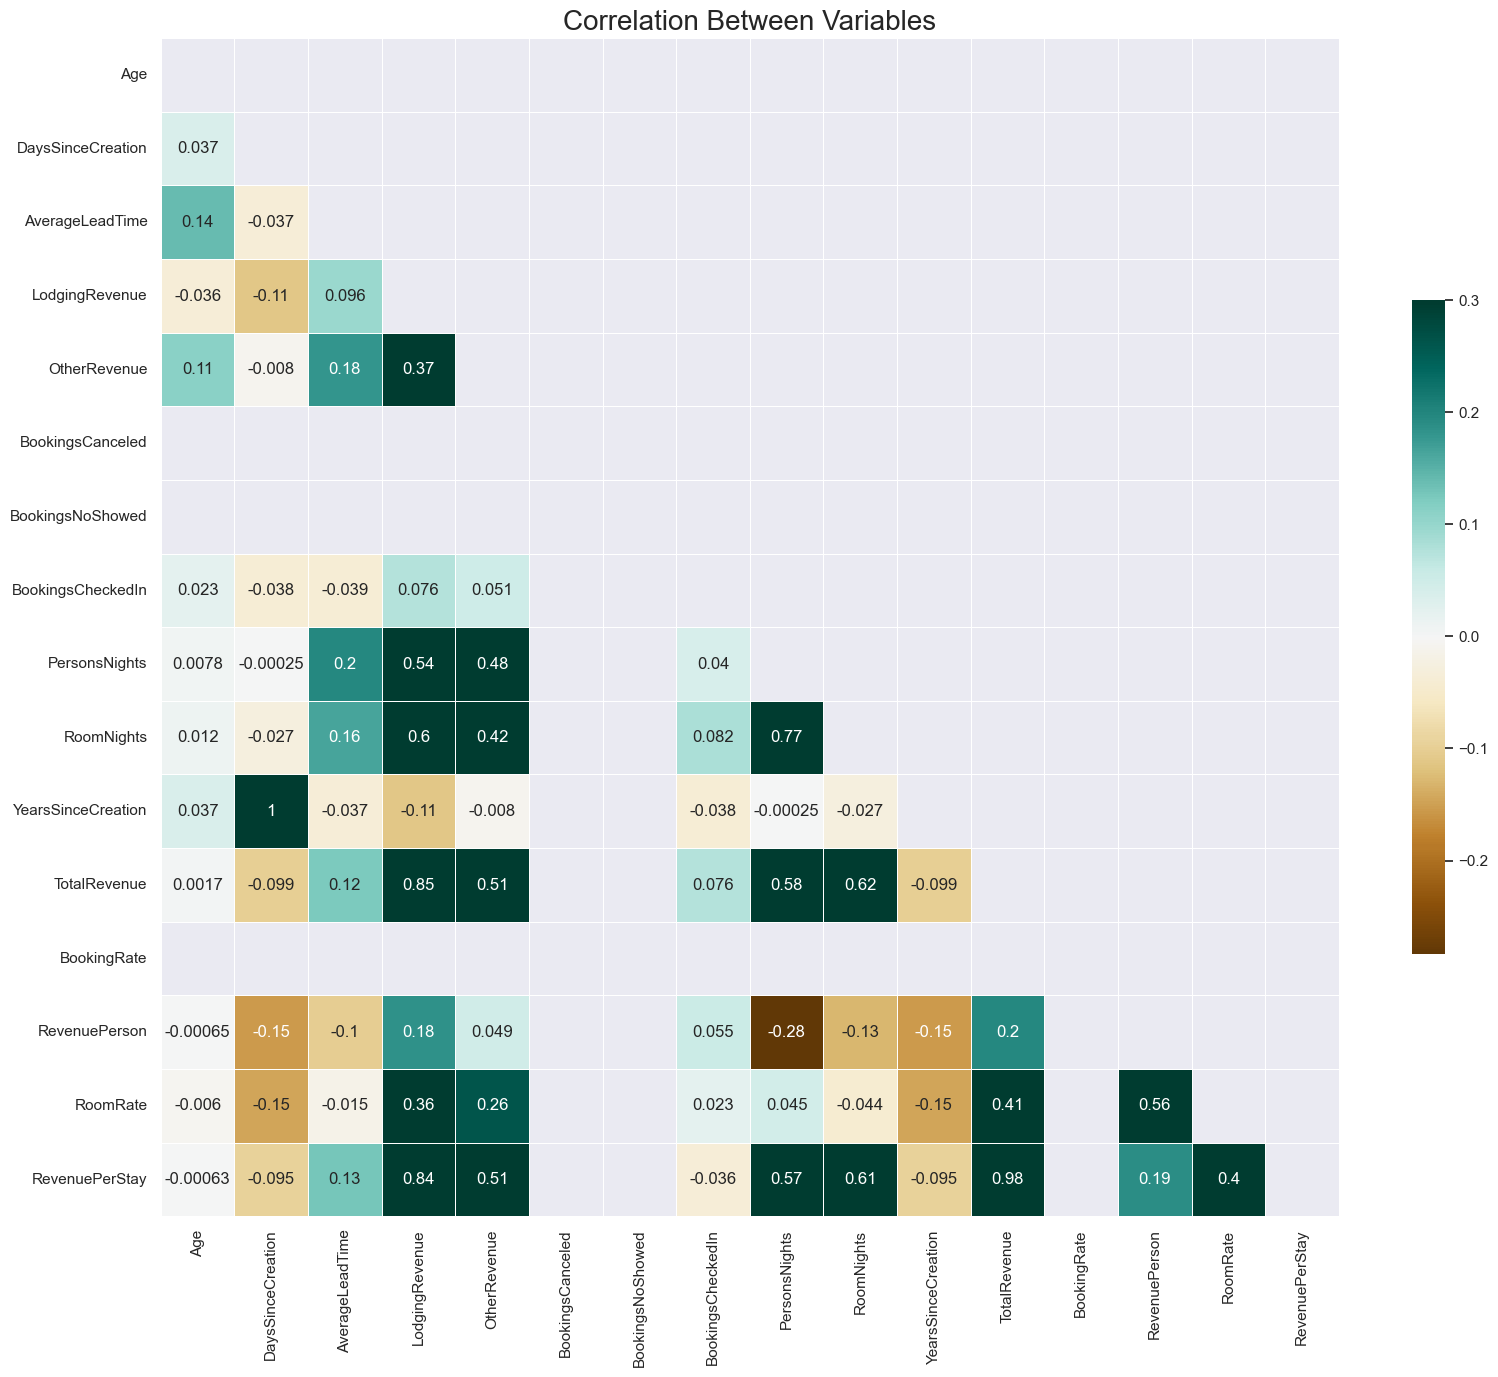

In [108]:
# Metric Variables Correlation Matrix
correlation_matrix(df_feature_selection,metric_features)

>**Analysis of the correlation matrix:**
>
> 1. BookingsCanceled,BookingsNoShowed, Booking Rate do not  have any correlation with other features. Therefore, these variables will be deleted.
>
> 2. Age and BookingsCheckedIn do not have a relevant correlation with other features, so it will be deleted.
>
> 3. YearsSinceCreation and DaysSinceCreation, and TotalRevenue and RevenuePerStay are perfectly correlated: YearsSinceCreation and RevenuePerStay will be maintain do to better interpretability.
>
> 4. Additionaly TotalRevenue will be kept instead of RevenuePerStay since it is more correlated with the remaining variables.
>
> 5. PersonNights and RoomNights have a high correlation, therefore, only one will be selected. Altough the correlation with the remaining variables is similar, RoomNights appears to have better interpretability for segmentation.

In [109]:
list_remove = ['BookingsCheckedIn','BookingsCanceled','BookingsNoShowed','BookingRate',
               'DaysSinceCreation','TotalRevenue','Age','PersonsNights','LodgingRevenue','OtherRevenue','YearsSinceCreation']

df_feature_selection.drop(columns=list_remove,inplace=True)

for i in list_remove:
    metric_features.remove(i)

**Categorical Features Relevancy Analysis**

> The variables NameID, DocIDHash,and MarketSegment are not relevant for customer segmentation, there should be deleted as well.

In [110]:
#Eliminate NameHash, DocIDHash,and MarketSegment from the dataset and from the non metric features list 

df_feature_selection.drop(columns=['NameHash', 'DocIDHash','MarketSegment'],inplace=True)

non_metric_features.remove('NameHash')
non_metric_features.remove('DocIDHash')
non_metric_features.remove('MarketSegment')

In [111]:
SR_check_value_counts = ['SRHighFloor','SRLowFloor','SRAccessibleRoom','SRMediumFloor',
                         'SRBathtub','SRShower','SRCrib','SRKingSizeBed','SRTwinBed',
                         'SRNearElevator','SRAwayFromElevator','SRNoAlcoholInMiniBar','SRQuietRoom']
values_of_0 =[]
values_of_1 =[]

for column in SR_check_value_counts:
    value_counts=df_feature_selection[column].value_counts(normalize=True).sort_index()
    values_of_0.append(round(value_counts[0],2)*100)
    values_of_1.append(round(value_counts[1],2)*100)
pd.DataFrame(data=[values_of_0,values_of_1],columns=SR_check_value_counts,index=['% of 0','% of 1']).T

% of 0  % of 1
SRHighFloor             96.0     4.0
SRLowFloor             100.0     0.0
SRAccessibleRoom       100.0     0.0
SRMediumFloor          100.0     0.0
SRBathtub              100.0     0.0
SRShower               100.0     0.0
SRCrib                  99.0     1.0
SRKingSizeBed           64.0    36.0
SRTwinBed               85.0    15.0
SRNearElevator         100.0     0.0
SRAwayFromElevator     100.0     0.0
SRNoAlcoholInMiniBar   100.0     0.0
SRQuietRoom             91.0     9.0

> Regarding SR variables, they do not appear to be relevant for the business objective, since there are no evident differences in preferences.

In [112]:
SR_remove_list= ['SRHighFloor','SRLowFloor','SRMediumFloor',
                 'SRCrib','SRNoAlcoholInMiniBar','SRKingSizeBed','SRTwinBed',
                 'SRQuietRoom','SRNearElevator','SRAwayFromElevator',
                 'SRAccessibleRoom','SRBathtub','SRShower']

df_feature_selection.drop(columns=SR_remove_list,inplace=True)

for i in SR_remove_list:
    non_metric_features.remove(i)

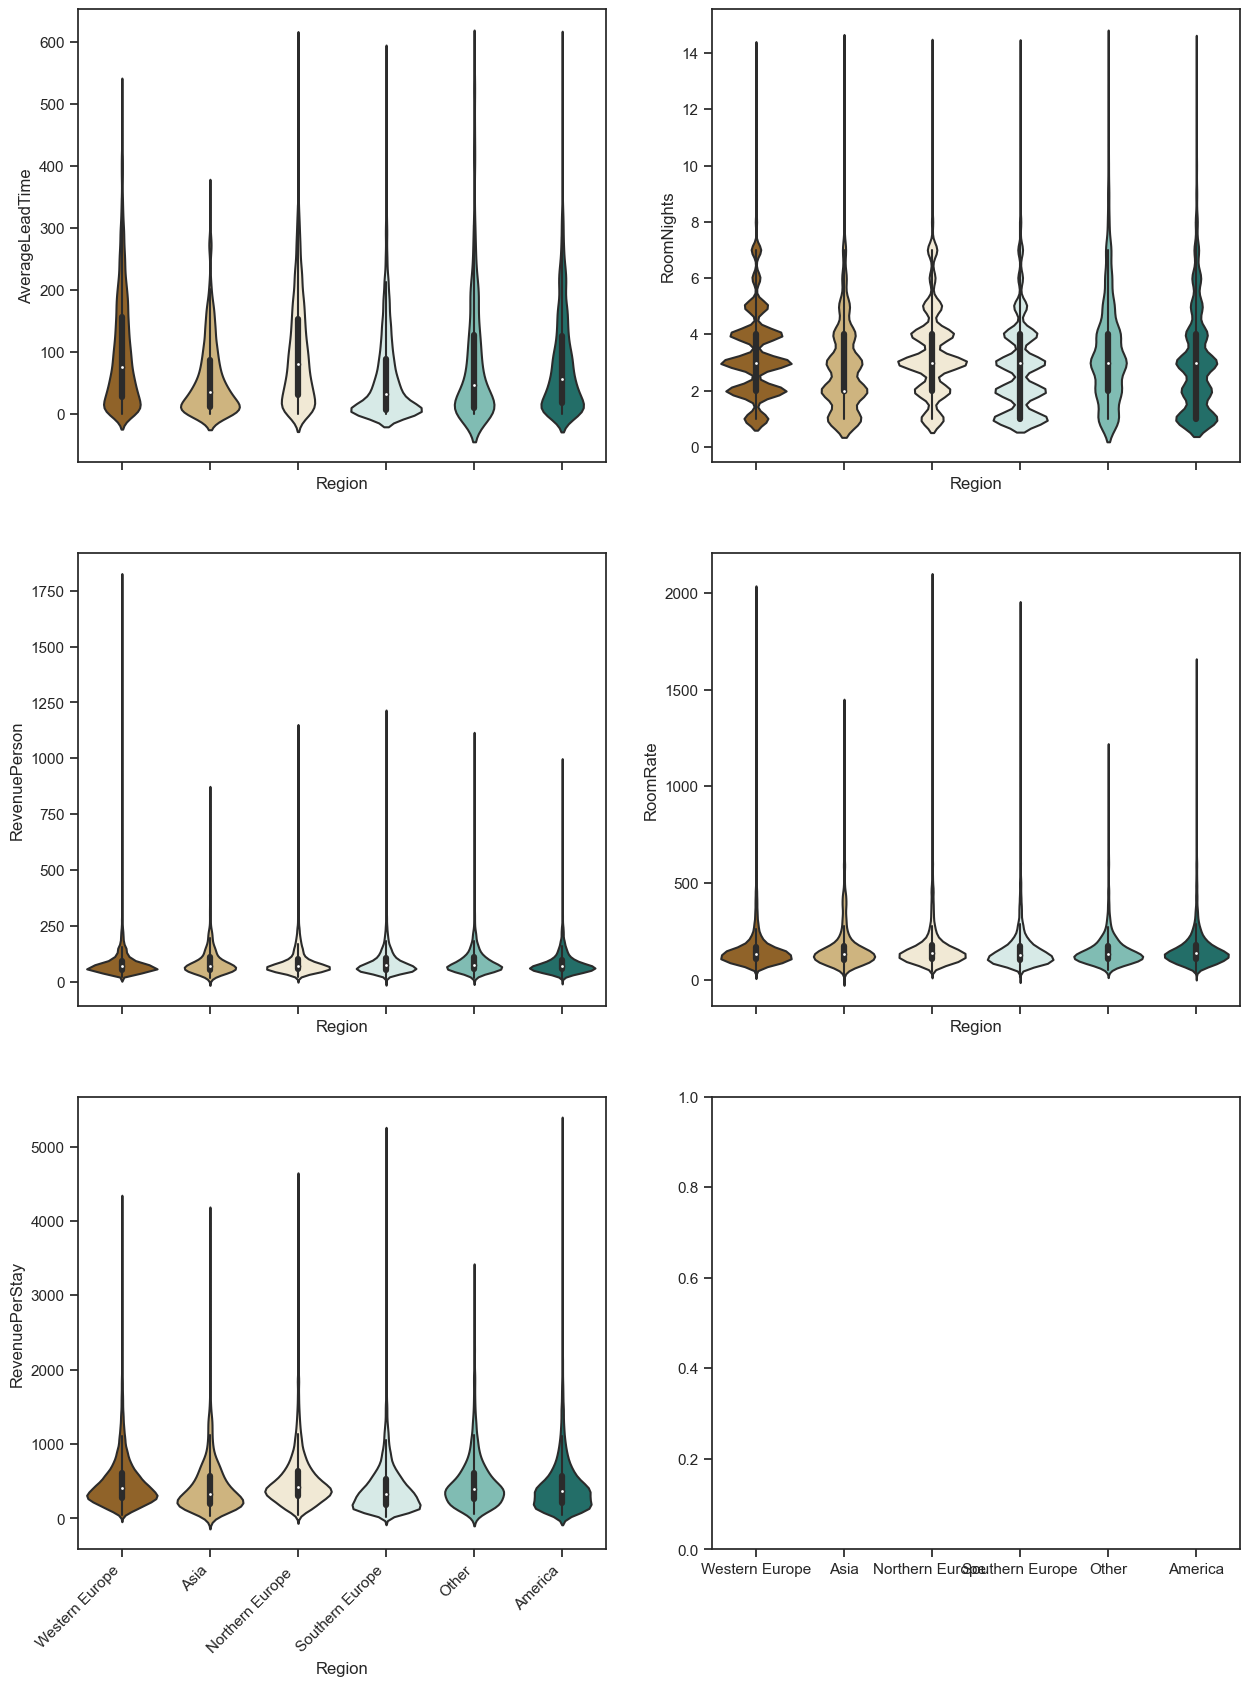

In [113]:
violinplot_categ_num (df_feature_selection, 'Region')

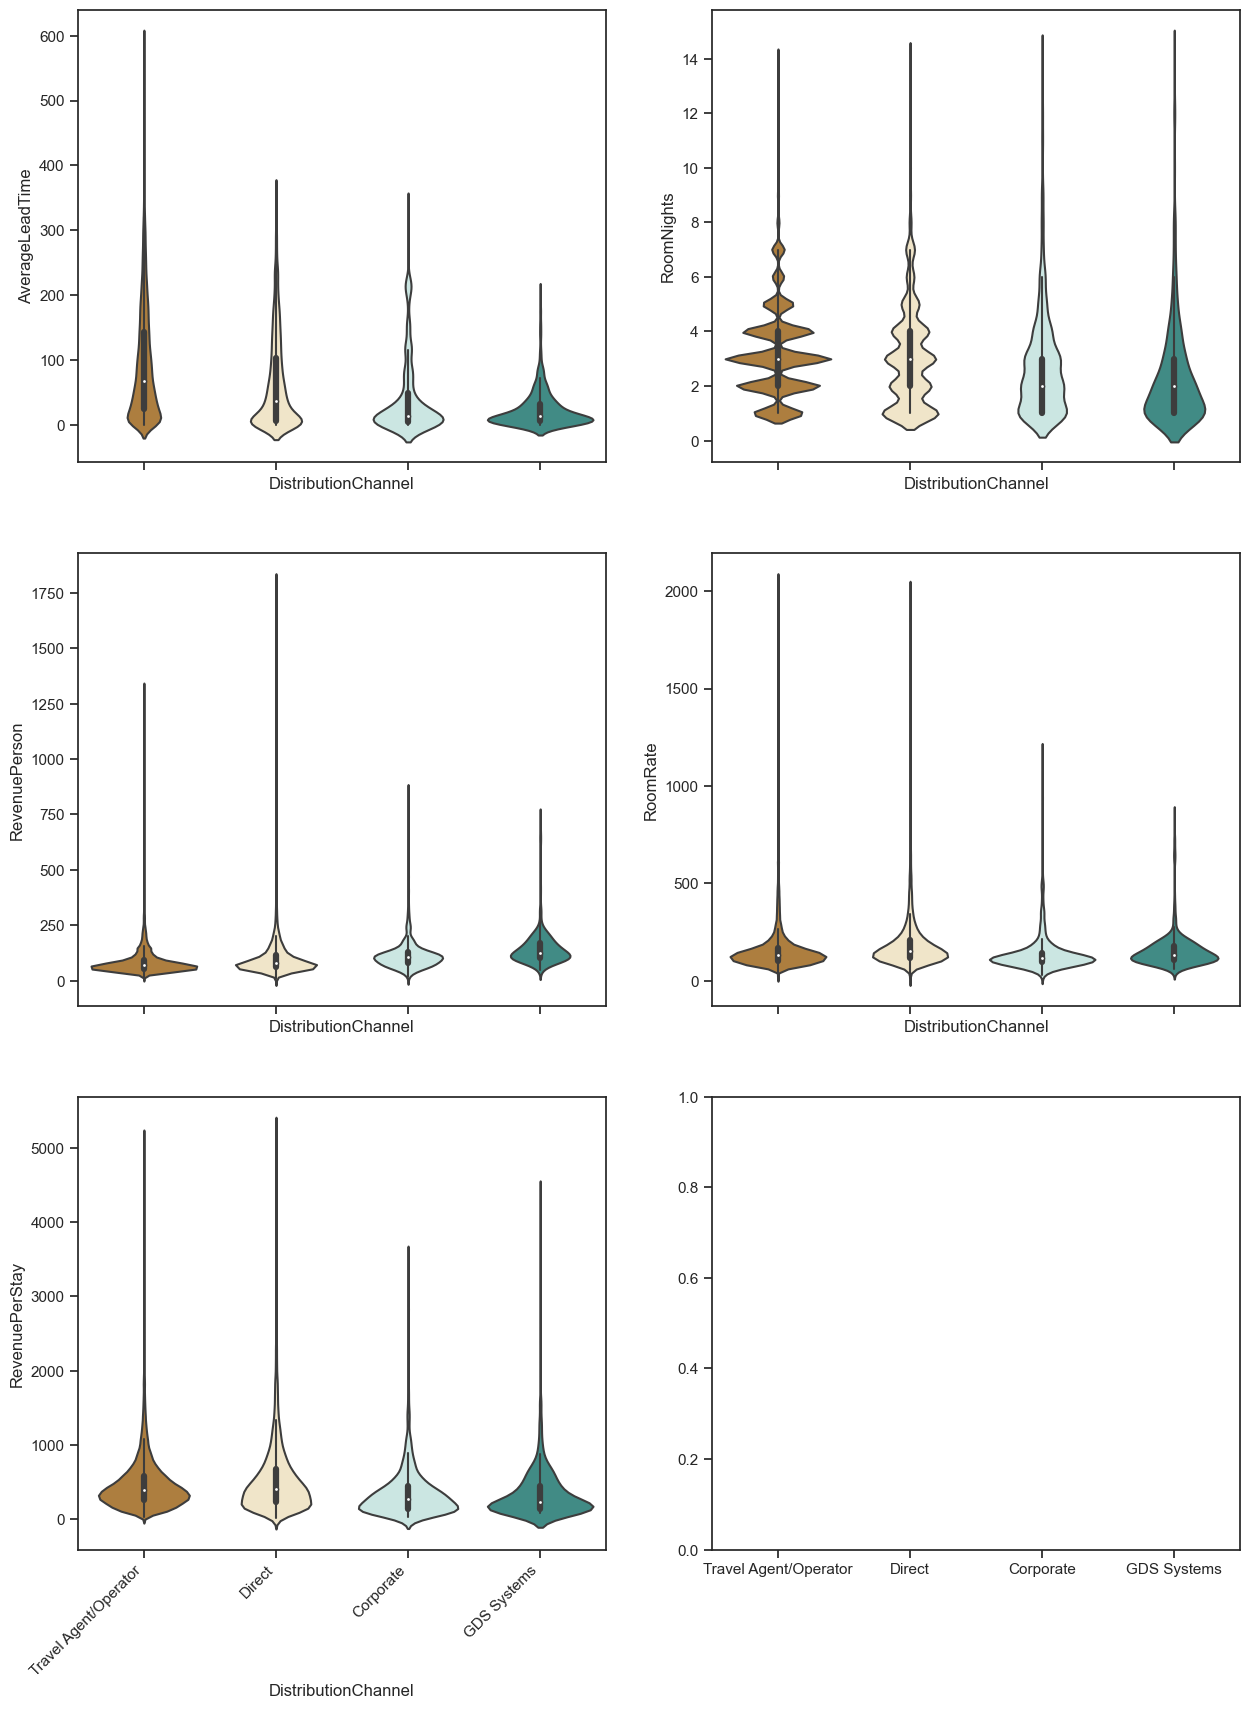

In [114]:
violinplot_categ_num (df_feat, 'DistributionChannel')

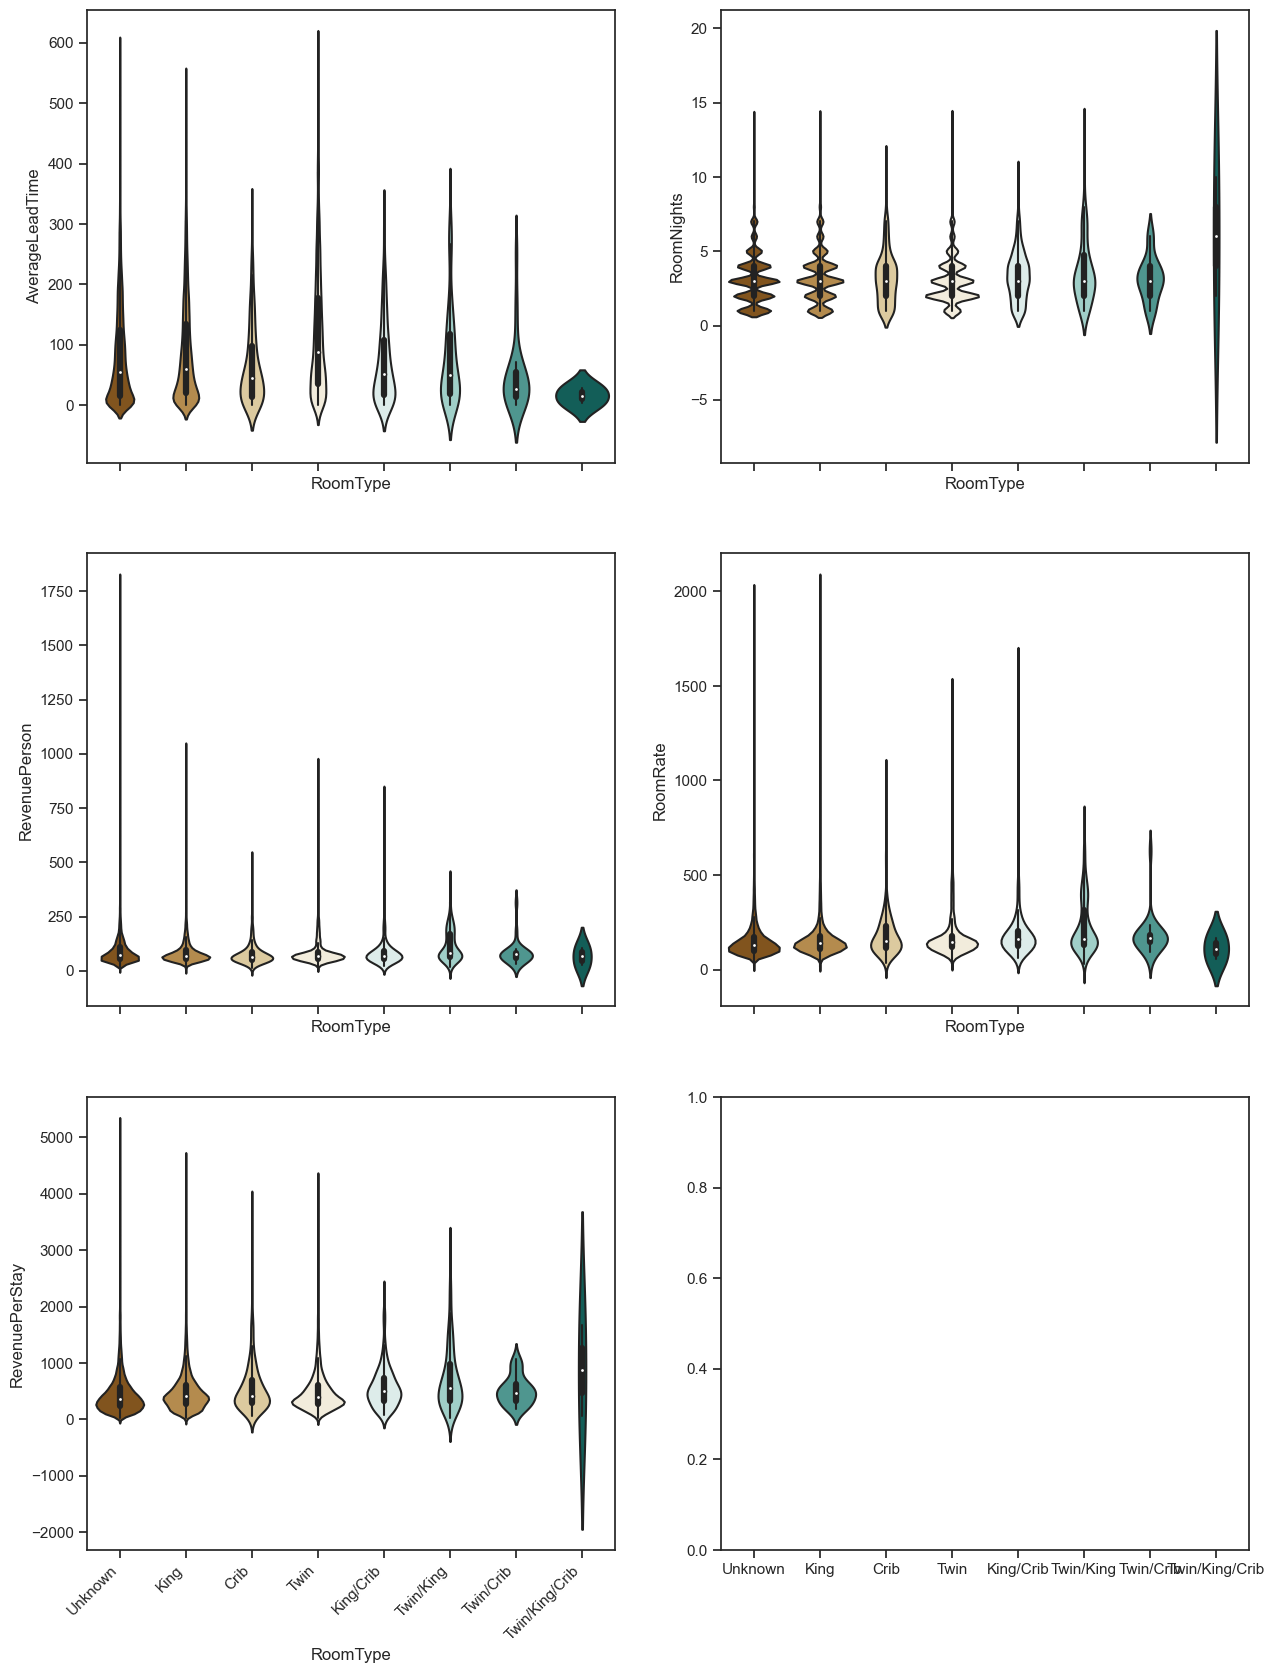

In [115]:
violinplot_categ_num (df_feature_selection, 'RoomType')

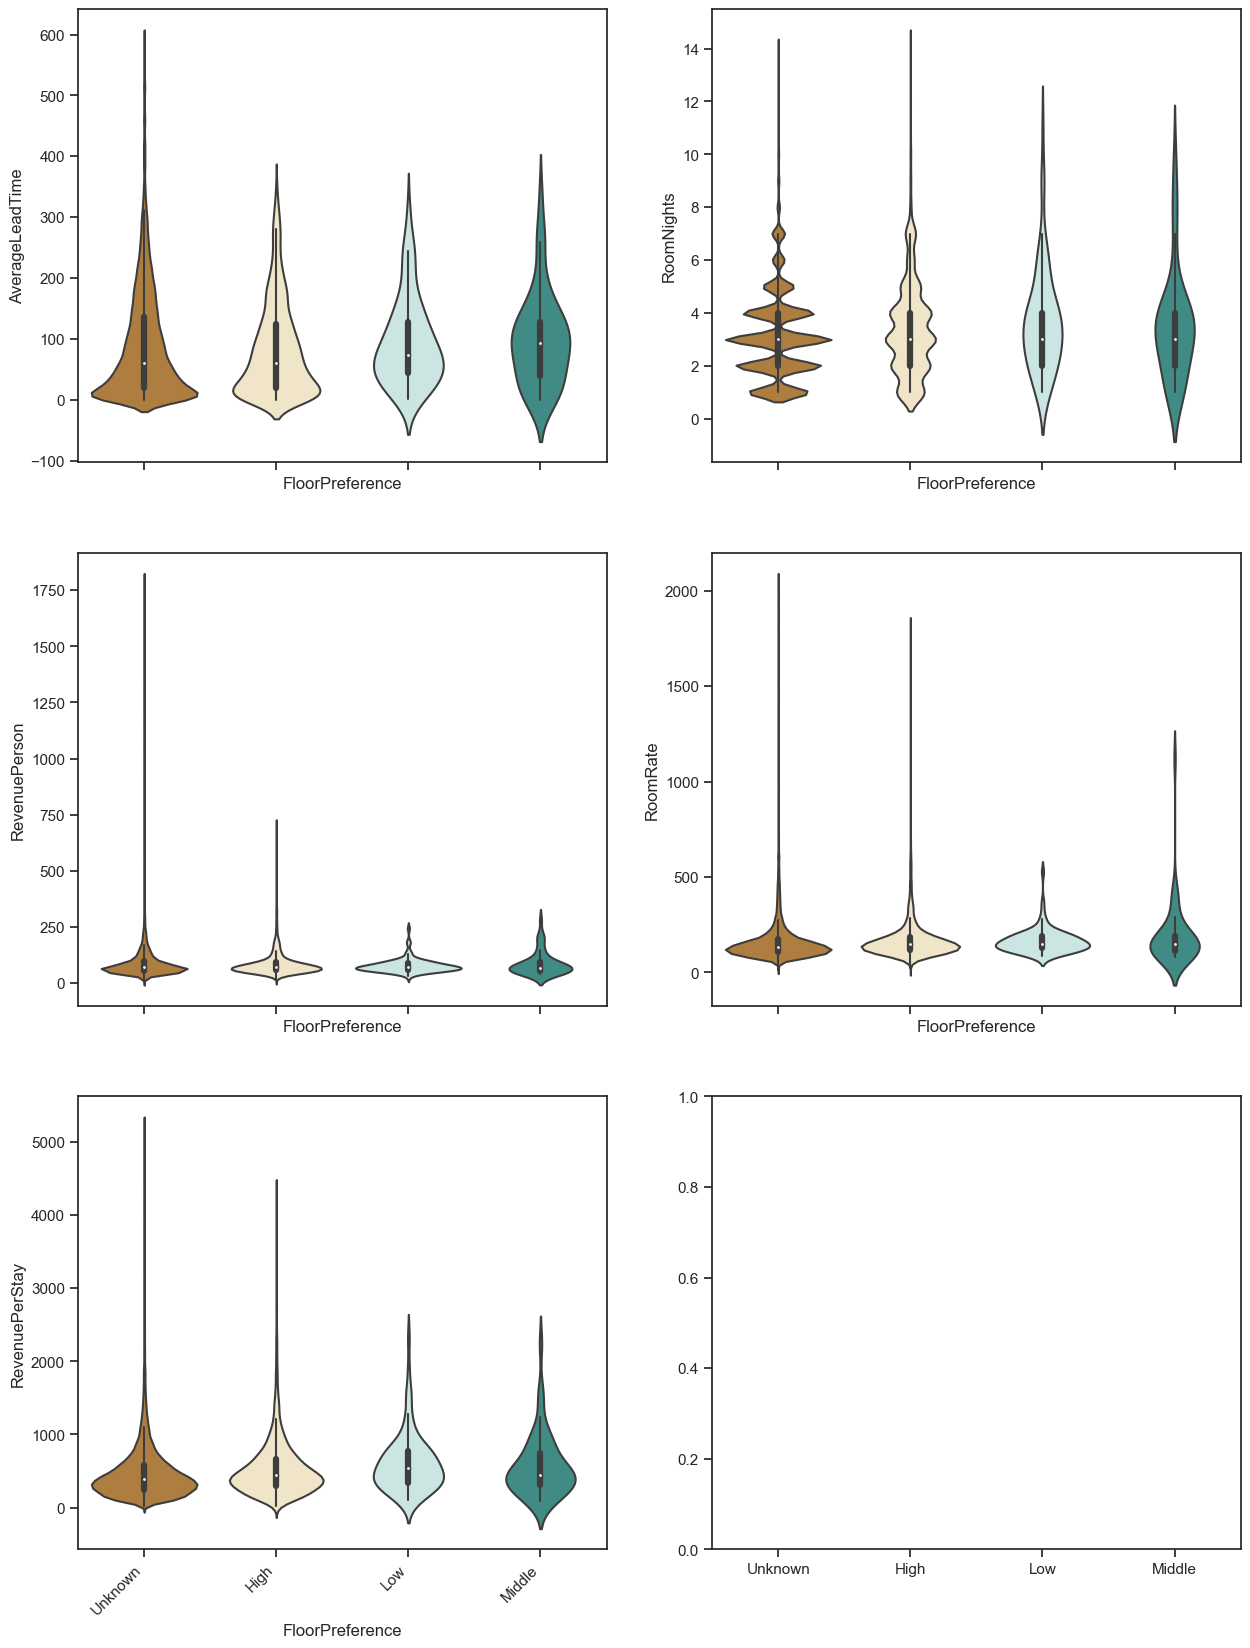

In [116]:
violinplot_categ_num (df_feature_selection, 'FloorPreference')

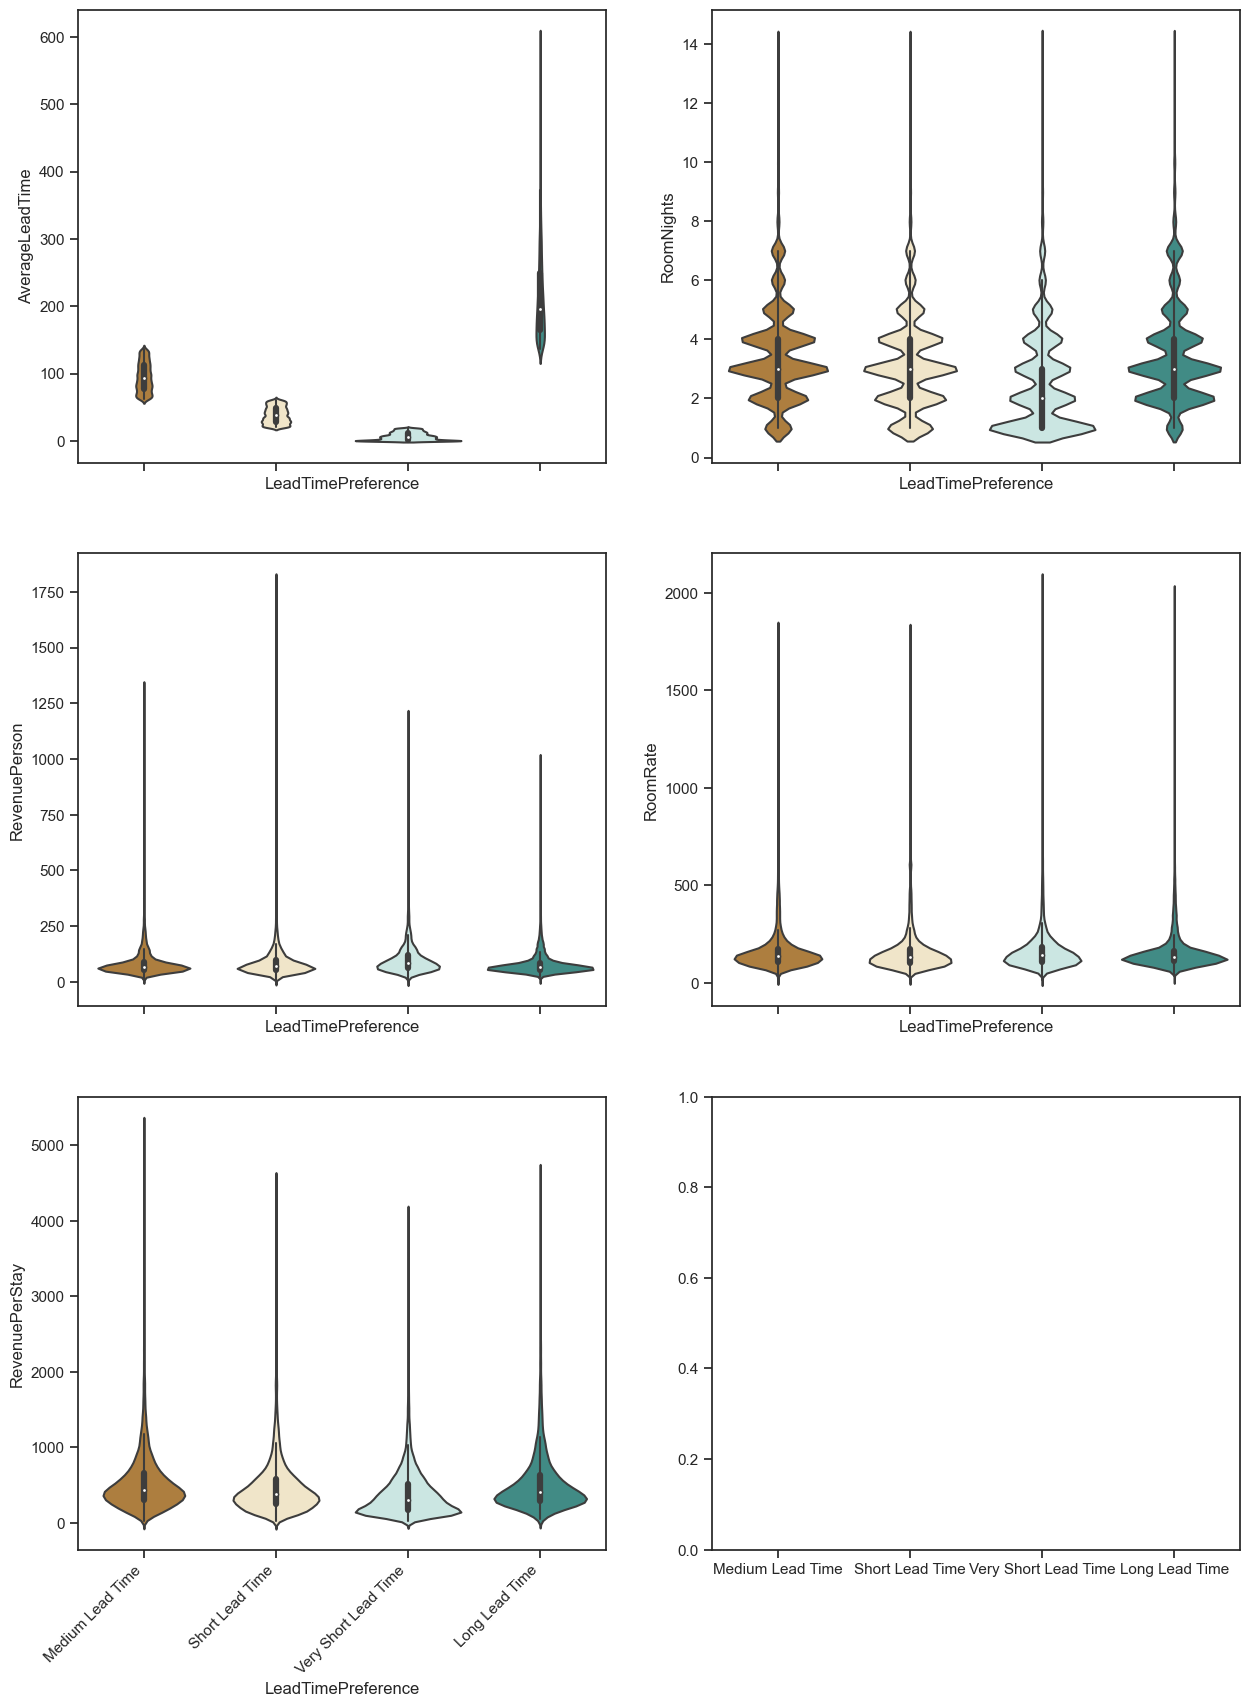

In [117]:
violinplot_categ_num (df_feature_selection,'LeadTimePreference')

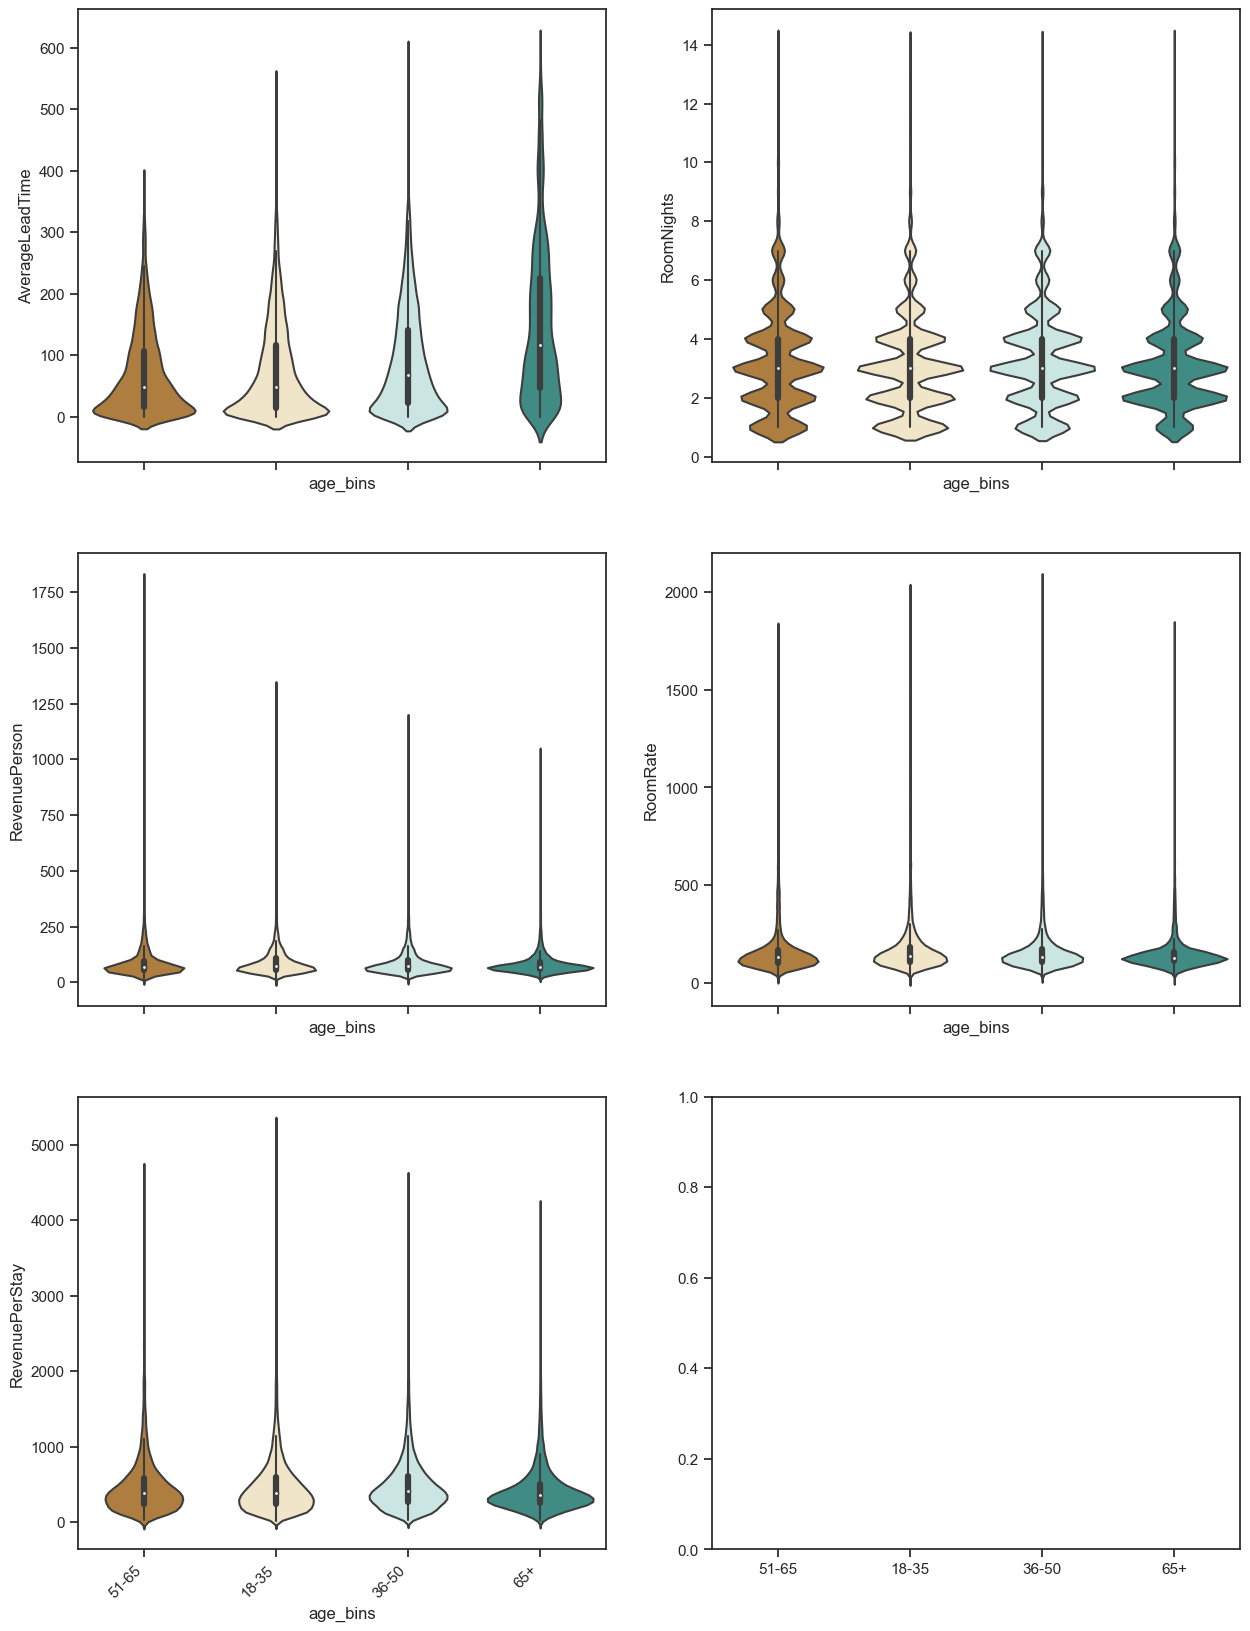

In [118]:
violinplot_categ_num (df_feature_selection,'age_bins')

In [119]:
table1 = pd.crosstab(index=df_feature_selection['FloorPreference'], columns=df_feature_selection['RoomPreferences'])
table1

RoomPreferences  Away From Elevator  Away From Elevator/Quiet Room  Bathtub  \
FloorPreference                                                               
High                             65                             45       26   
Low                               1                              0        1   
Middle                            2                              2        1   
Unknown                          88                             57      147   

RoomPreferences  Bathtub/Away From Elevator  Bathtub/Quiet Room  \
FloorPreference                                                   
High                                      2                   6   
Low                                       0                   0   
Middle                                    0                   0   
Unknown                                   1                  28   

RoomPreferences  Near Elevator  Near Elevator/Quiet Room  \
FloorPreference                                            
High                         4                         0   
Low                          0                         0   
Middle                       1                         0   
Unknown                     17                         3   

RoomPreferences  No Alcohol in MiniBar  No Alcohol in MiniBar/Quiet Room  \
FloorPreference                                                            
High                                 0                                 0   
Low                                  0                                 0   
Middle                               0                                 0   
Unknown                              6                                 4   

RoomPreferences  Quiet Room  Shower  Shower/Away From Elevator  \
FloorPreference                                                  
High                    486      16                          1   
Low                      18       0                          0   
Middle                   12       0                          0   
Unknown                5604      79                          1   

RoomPreferences  Shower/Quiet Room  Unknown  
FloorPreference                              
High                             0     2344  
Low                              0       69  
Middle                           0       33  
Unknown                         22    61535

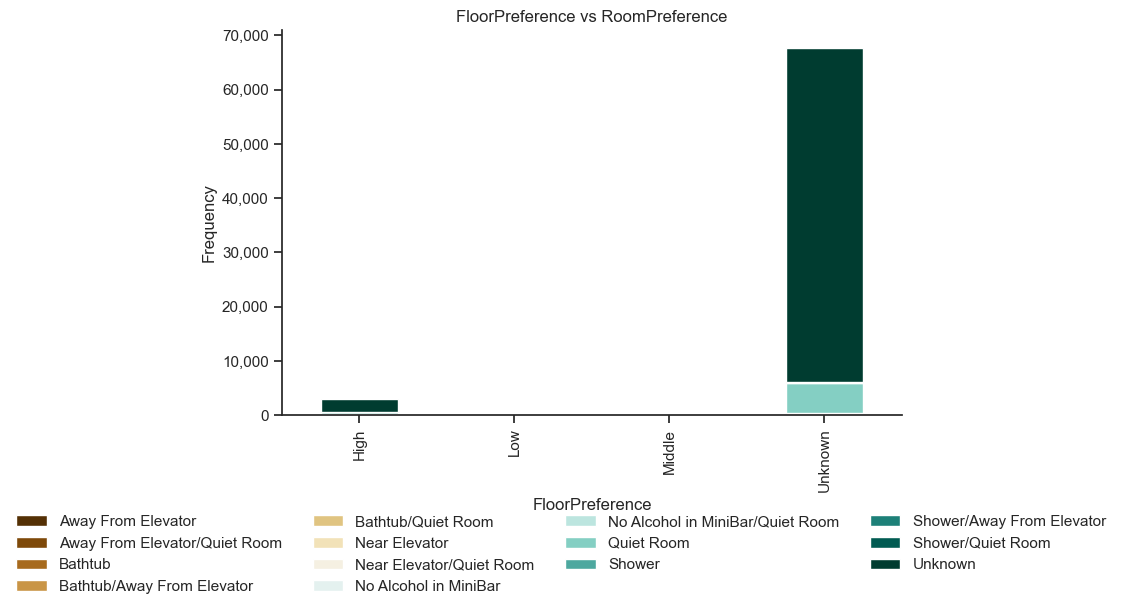

In [120]:
# Draw
fig, ax = plt.subplots(figsize=(8,5))
table1.plot(kind="bar", 
            ax=ax,
            stacked=True,
            colormap= palette)

# Decoration
fmt = "{x:,.0f}"
tick = ticker.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
sns.despine()
plt.title("FloorPreference vs RoomPreference", fontsize=12)
plt.xlabel("FloorPreference")
plt.ylabel("Frequency")
plt.rc('axes', labelsize=10)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, loc='lower center', 
          ncol=4, bbox_to_anchor=(0.45, -0.5), frameon=False)

>The variables FloorPreference, RoomType, RoomPreferences,  Region/Nationality, and Age_bins do not have discriminative power, therefore, might not be included in the clustering.
>
>Regarding LeadTimePreference it is possible to understand that it some degree of discriminative power. Nevertheless, It is better to maintain AverageLeadTime insteadf since it is numerical variable.
>
>The variable DistributionChannel will be maintained.

In [121]:
preferences_remove_list= ['Nationality','RoomType','FloorPreference','RoomPreferences',
                          'LeadTimePreference','Region','age_bins']

df_feature_selection.drop(columns=preferences_remove_list,inplace=True)

for i in preferences_remove_list:
    non_metric_features.remove(i)

In [122]:
#Update the original dataframe 

df_selected=df_feature_selection

### 4.6 Data Enconding

In [123]:
df_encoded=df_selected.copy()

In [124]:
# one-hot encode categorical features 
df_encoded = pd.get_dummies(df_selected, columns=["DistributionChannel"])

In [125]:
#Update original dataframe 
df_selected=df_encoded

### 4.7 Data Normalization

In [126]:
df_scaled=df_selected.copy()

Metric features are scaled through the __MinMaxScaler__ method because the data does not a follow normal distribution.

In [127]:
scaler = MinMaxScaler()
df_scaled[metric_features] = scaler.fit_transform(df_scaled[metric_features])

### 4.8 Exploration of the Final Data

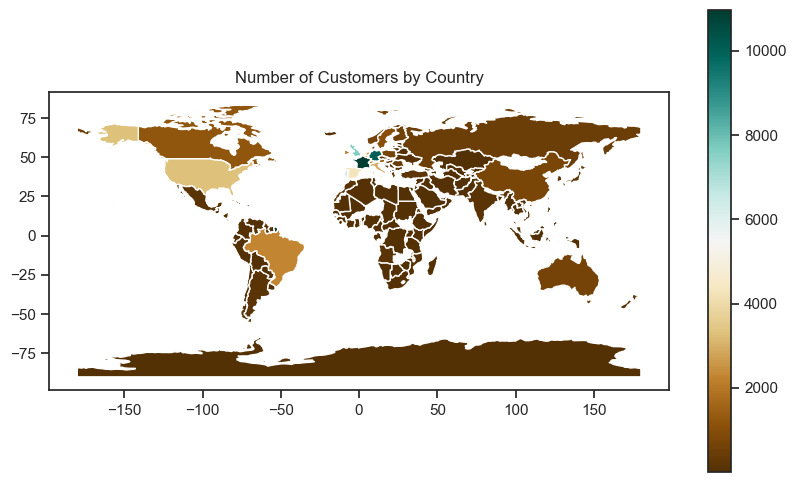

In [128]:
# load the world map shapefile
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# group the data by country and count the number of customers per country
country_counts = df_all_variables.groupby('Nationality').size().reset_index(name='counts')

# merge the customer counts with the world map
world = world.merge(country_counts, left_on='iso_a3', right_on='Nationality')

# plot the choropleth map
fig, ax = plt.subplots(figsize=(10, 6))
world.plot(column='counts', ax=ax, legend=True,cmap=palette)
ax.set_title('Number of Customers by Country')
plt.show()

### 4.9 Analysize Principal Components

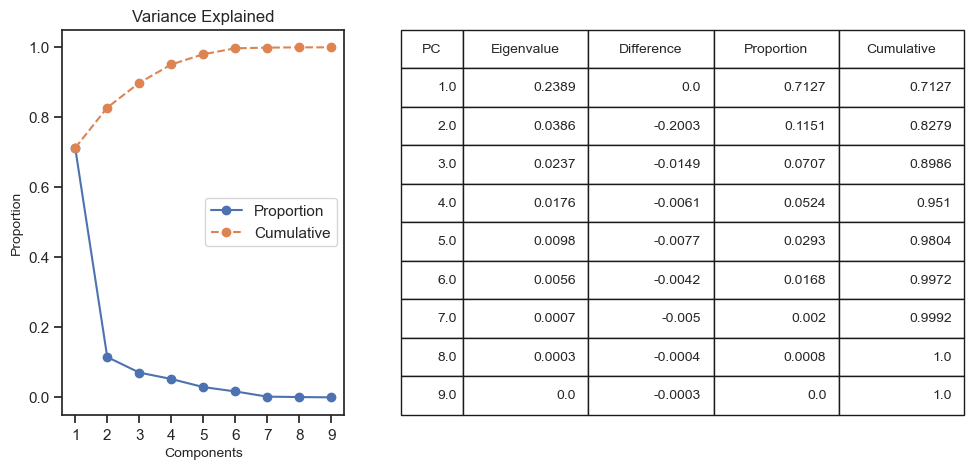

In [129]:
pca_feat=pca_analysis(df_scaled)

In [130]:
#4 principal components, since accumulate more than 95% of variance
pca_features = ['PC0', 'PC1', 'PC2', 'PC3']
df_pca = pd.DataFrame(pca_feat[:, :4], index=df.index, columns=pca_features)

# 5. Modelling

### 5.1.1. K-Means Clustering with PCA 

In [131]:
df_pca_kmeans=df_pca.copy()

**Find the number of clusters**

- Elbow Method: Inertia 
- Silhouette 
- Dendogram- Hierarchical Clustering

For n_clusters = 1, the inertia is : 22547.554897992693
For n_clusters = 2, the inertia is : 6250.509509306396
For n_clusters = 3, the inertia is : 3142.191093173743
For n_clusters = 4, the inertia is : 2146.5495570792755
For n_clusters = 5, the inertia is : 1631.4899322245476
For n_clusters = 6, the inertia is : 1421.5818165036642
For n_clusters = 7, the inertia is : 1215.8489465106422
For n_clusters = 8, the inertia is : 1029.5110341202512
For n_clusters = 9, the inertia is : 861.2458548290897
For n_clusters = 10, the inertia is : 780.3223198576782
For n_clusters = 11, the inertia is : 709.1130029203803
For n_clusters = 12, the inertia is : 644.6746037814125


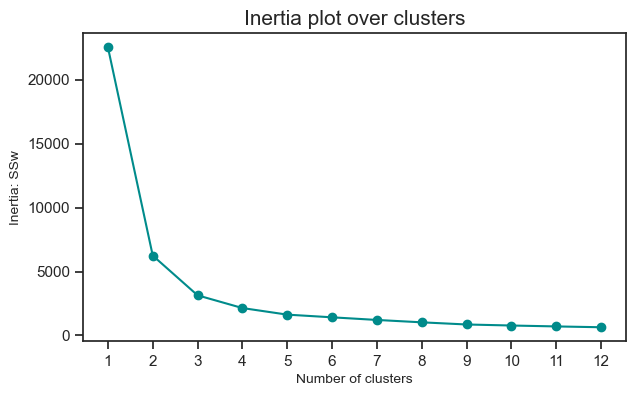

In [132]:
plot_inertia(df_pca_kmeans, 12)

For n_clusters = 2, the average silhouette_score is : 0.7855494827163332
For n_clusters = 3, the average silhouette_score is : 0.8118250129296793
For n_clusters = 4, the average silhouette_score is : 0.497599699316621
For n_clusters = 5, the average silhouette_score is : 0.4683536404045693
For n_clusters = 6, the average silhouette_score is : 0.46081113984388256


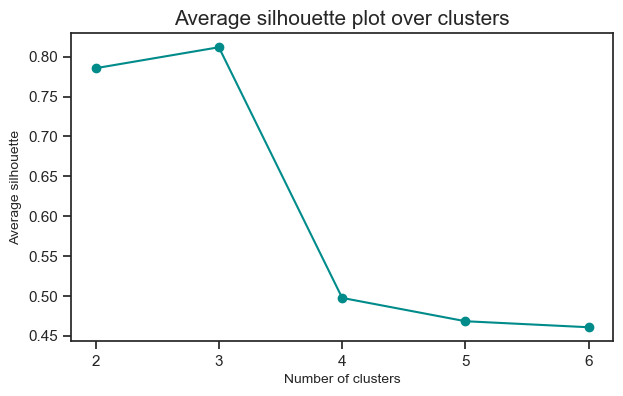

In [133]:
plot_silhouette(df_pca_kmeans, 7)

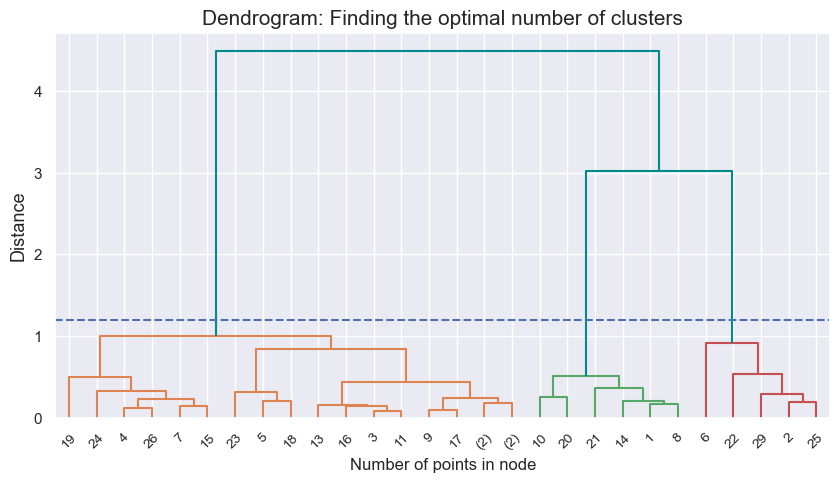

In [134]:
# 1. Compute k-means with a large number of clusters 
clusters = KMeans(
    n_clusters = 30, 
    init = "k-means++", 
    n_init=15, 
    random_state = 5
    ). fit (df_pca_kmeans)
    
aux_km_labels= clusters.labels_
aux_km_centroids = clusters.cluster_centers_

df_aux= df_pca_kmeans.copy()
df_aux["aux_labels"] = aux_km_labels

#2. Plot the dendrogram and find the number of clusters
plot_dendrogram(pd.DataFrame(aux_km_centroids, columns = pca_features), 1.2,'ward')

> It has been determined that the optimal number of clusters is **3**, as suggested by the **Elbow method, Dendogram**,and **Silhouette method** . 
>
> It is important to note that having too many clusters may not be beneficial for marketing purposes. 

**Final Solution**

In [135]:
#Obtain labels and centroids 

clusters = KMeans(
    n_clusters = 3, 
    init = "k-means++", 
    n_init=50, 
    random_state = 5
    ). fit (df_pca_kmeans)
    
kmeans_labels= clusters.labels_
kmeans_centroids = clusters.cluster_centers_

#Add a column with the labels to the dataframe
df_pca_kmeans['kmeans_labels']=kmeans_labels

In [136]:
cluster_overview (df_pca_kmeans['kmeans_labels'])

Number of Obs  % of Obs
0          58983      83.4
1           9341      13.2
2           2403       3.4

In [137]:
cluster_scores (df_pca_kmeans,'kmeans_labels')

Silhouette score: 0.81
Davies-Bouldin score: 0.37
Calinski-Harabasz score: 218386.61
R2 score: 0.86


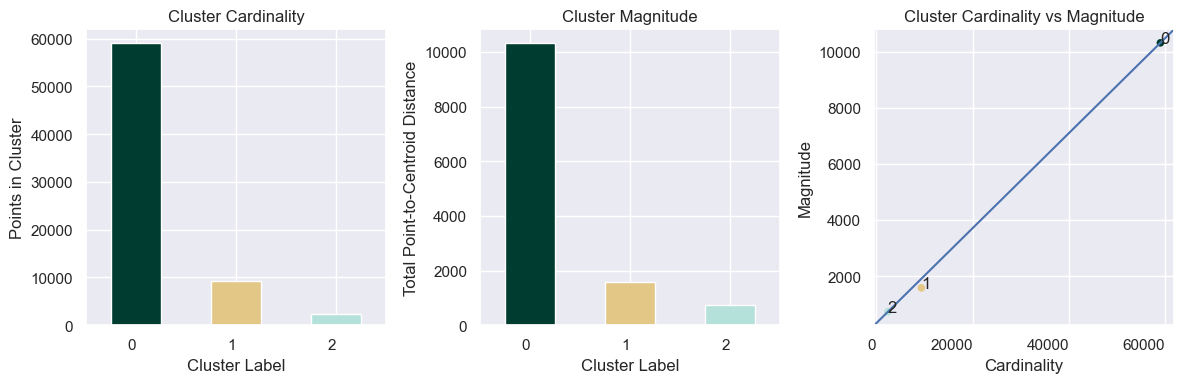

In [138]:
cluster_diagnosis (df_pca_kmeans, 'kmeans_labels', kmeans_labels, kmeans_centroids)

In [139]:
#evaluate final cluster solution
df_selected["kmeans_labels"] = kmeans_labels
df_selected.groupby('kmeans_labels').mean().T

kmeans_labels                                       0           1           2
AverageLeadTime                             95.274729   63.797162   36.811176
RoomNights                                   3.173982    3.021625    2.656679
RevenuePerson                               87.234310  103.590365  124.443212
RoomRate                                   155.886448  186.524352  145.790251
RevenuePerStay                             477.811581  539.152379  355.180572
DistributionChannel_Corporate                0.000000    0.000000    0.771536
DistributionChannel_Direct                   0.000000    1.000000    0.000000
DistributionChannel_GDS Systems              0.000000    0.000000    0.228464
DistributionChannel_Travel Agent/Operator    1.000000    0.000000    0.000000

### 5.1.2. K-Means Clustering with Metric Features  

In [140]:
df_kmeans= df_scaled[metric_features].copy()

**Find the number of clusters**

- Elbow Method: Inertia 
- Silhouette 
- Dendogram- Hierarchical Clustering

For n_clusters = 1, the inertia is : 3457.0743407731184
For n_clusters = 2, the inertia is : 2295.097540719129
For n_clusters = 3, the inertia is : 1641.36620091749
For n_clusters = 4, the inertia is : 1369.634320240872
For n_clusters = 5, the inertia is : 1163.6243656216461
For n_clusters = 6, the inertia is : 995.0706106747577


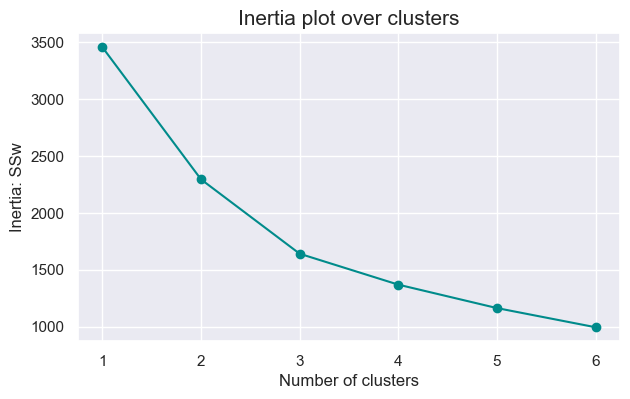

In [141]:
plot_inertia(df_kmeans, 6)

For n_clusters = 2, the average silhouette_score is : 0.3885699274554612
For n_clusters = 3, the average silhouette_score is : 0.35965690992031274
For n_clusters = 4, the average silhouette_score is : 0.3283542063525648
For n_clusters = 5, the average silhouette_score is : 0.328414660411589


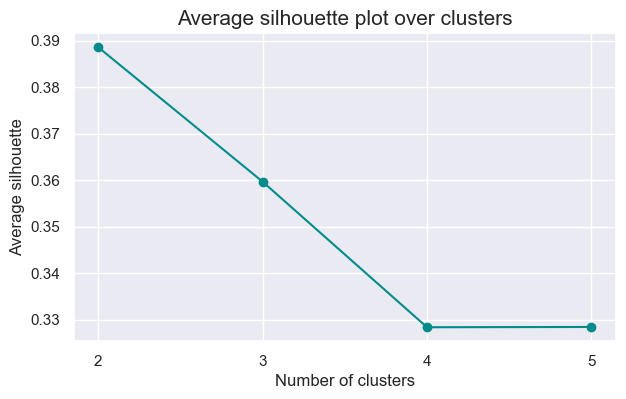

In [142]:
plot_silhouette(df_kmeans, 6)

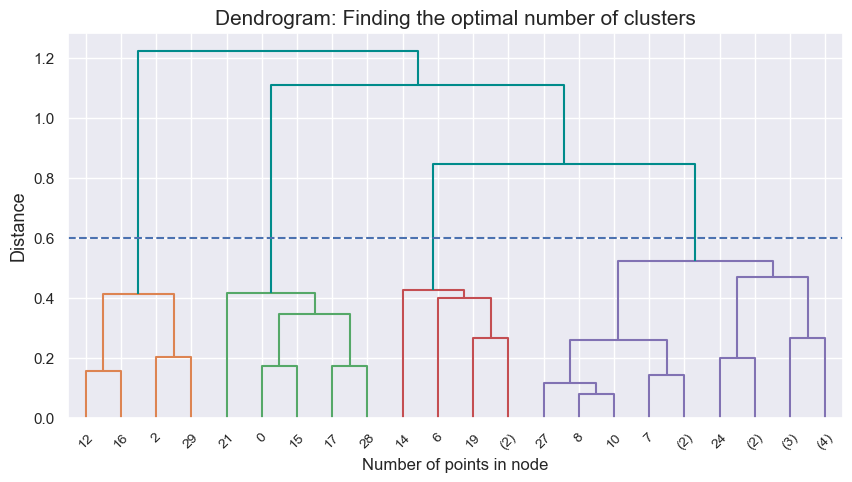

In [143]:
# 1. Compute k-means with a large number of clusters 
clusters = KMeans(
    n_clusters = 30, 
    init = "k-means++", 
    n_init=15, 
    random_state = 5
    ). fit (df_kmeans)
    
aux_km_labels= clusters.labels_
aux_km_centroids = clusters.cluster_centers_

df_aux= df_kmeans.copy()
df_aux["aux_labels"] = aux_km_labels

#2. Plot the dendrogram and find the number of clusters
plot_dendrogram(pd.DataFrame(aux_km_centroids, columns = metric_features), 0.6,'ward')

> It has been determined that the optimal number of clusters is **3**, as suggested by the **Elbow method and Silhouette method**. 
>
> The **Dendogram** indicates that **4** clusters, such as, may be appropriate.
>
> It is important to note that having too many clusters may not be beneficial for marketing purposes. 

In [144]:
#Obtain labels and centroids 

clusters = KMeans(
    n_clusters = 3, 
    init = "k-means++", 
    n_init=50, 
    random_state = 5
    ). fit (df_kmeans)
    
kmeans_metric_labels= clusters.labels_
kmeans_metric_centroids = clusters.cluster_centers_

#Add a column with the labels to the dataframe
df_kmeans['kmeans_metric_labels']=kmeans_metric_labels

In [145]:
cluster_overview (df_kmeans['kmeans_metric_labels'])

Number of Obs  % of Obs
0          34508      48.8
1          14956      21.1
2          21263      30.1

In [146]:
cluster_scores (df_kmeans,'kmeans_metric_labels')

Silhouette score: 0.36
Davies-Bouldin score: 1.04
Calinski-Harabasz score: 39118.08
R2 score: 0.53


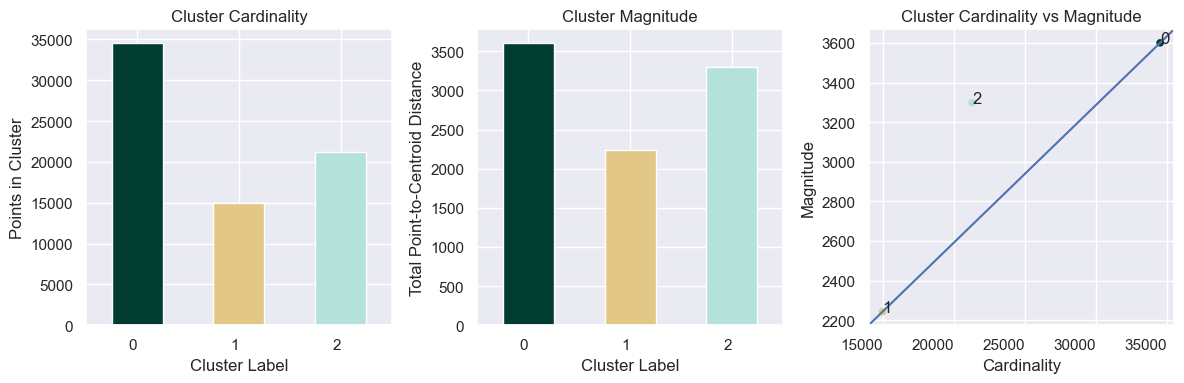

In [147]:
cluster_diagnosis (df_kmeans, 'kmeans_metric_labels', kmeans_metric_labels, kmeans_metric_centroids)

In [148]:
#evaluate final cluster solution
df_selected["kmeans_metric_labels"] = kmeans_metric_labels
df_selected.groupby('kmeans_metric_labels').mean().T

kmeans_metric_labels                                0           1           2
AverageLeadTime                             41.506544  226.895984   69.520375
RoomNights                                   2.084966    2.981011    4.951700
RevenuePerson                               95.383140   79.815526   90.618141
RoomRate                                   158.974773  152.138155  165.829309
RevenuePerStay                             317.319717  445.037865  774.416906
DistributionChannel_Corporate                0.036108    0.010230    0.021399
DistributionChannel_Direct                   0.154979    0.078096    0.132860
DistributionChannel_GDS Systems              0.013011    0.000267    0.004515
DistributionChannel_Travel Agent/Operator    0.795902    0.911407    0.841227
kmeans_labels                                0.253217    0.099091    0.184687

### 5.1.3. K-Prototypes with All Features

In [149]:
df_kp= df_scaled.copy();

In [150]:
categorical_cols = []
for feature in df_kp.columns.tolist():
    if feature not in metric_features:
        categorical_cols.append(df_kp.columns.get_loc(feature))

In [151]:
df_kp= df_scaled.copy();

kpclust = KPrototypes(n_clusters=3, random_state=1,n_jobs=-1)
df_kp['kp_labels']=kpclust.fit_predict(df_kp,categorical=categorical_cols)

In [152]:
#Obtain the labels
kp_labels= kpclust.labels_

#Obtain the centroids 
kp_centroids= df_kp.groupby('kp_labels').mean().to_numpy()

In [153]:
cluster_overview (df_kp['kp_labels'])

Number of Obs  % of Obs
0          43146      61.0
1          10312      14.6
2          17269      24.4

In [154]:
cluster_scores (df_kp,'kp_labels')

Silhouette score: 0.4
Davies-Bouldin score: 1.06
Calinski-Harabasz score: 73742.07
R2 score: 0.68


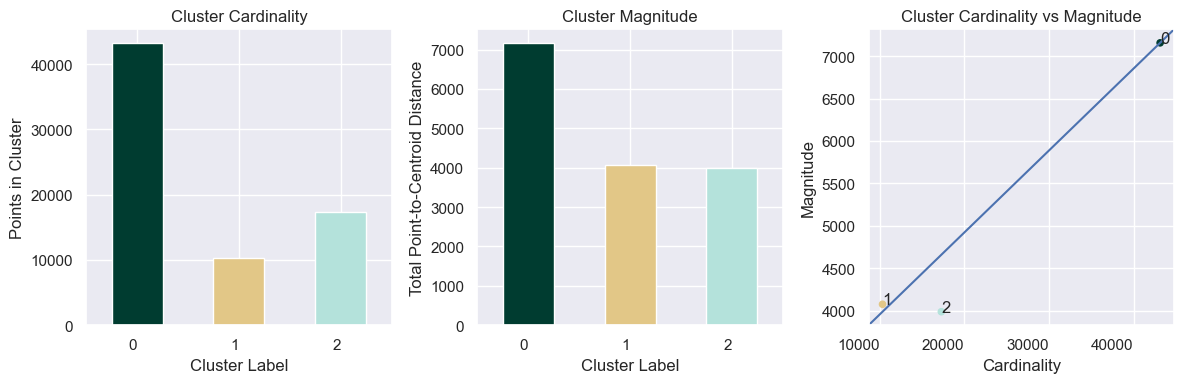

In [155]:
cluster_diagnosis (df_kp, 'kp_labels', kp_labels, kp_centroids)

In [156]:
#evaluate final cluster solution
df_selected["kp_labels"] = kp_labels
df_selected.groupby('kp_labels').mean().T

kp_labels                                           0           1           2
AverageLeadTime                             47.602310   49.515496  216.545419
RoomNights                                   3.052218    2.739527    3.583242
RevenuePerson                               90.519121  107.944640   80.685204
RoomRate                                   155.976146  181.780982  155.367190
RevenuePerStay                             454.562224  481.518152  549.801659
DistributionChannel_Corporate                0.015853    0.098526    0.008918
DistributionChannel_Direct                   0.000000    0.861811    0.026290
DistributionChannel_GDS Systems              0.003083    0.039663    0.000405
DistributionChannel_Travel Agent/Operator    0.981064    0.000000    0.964387
kmeans_labels                                0.037871    1.138189    0.044936
kmeans_metric_labels                         0.706253    0.614139    1.197348

### 5.1.4. Clustering Assessment

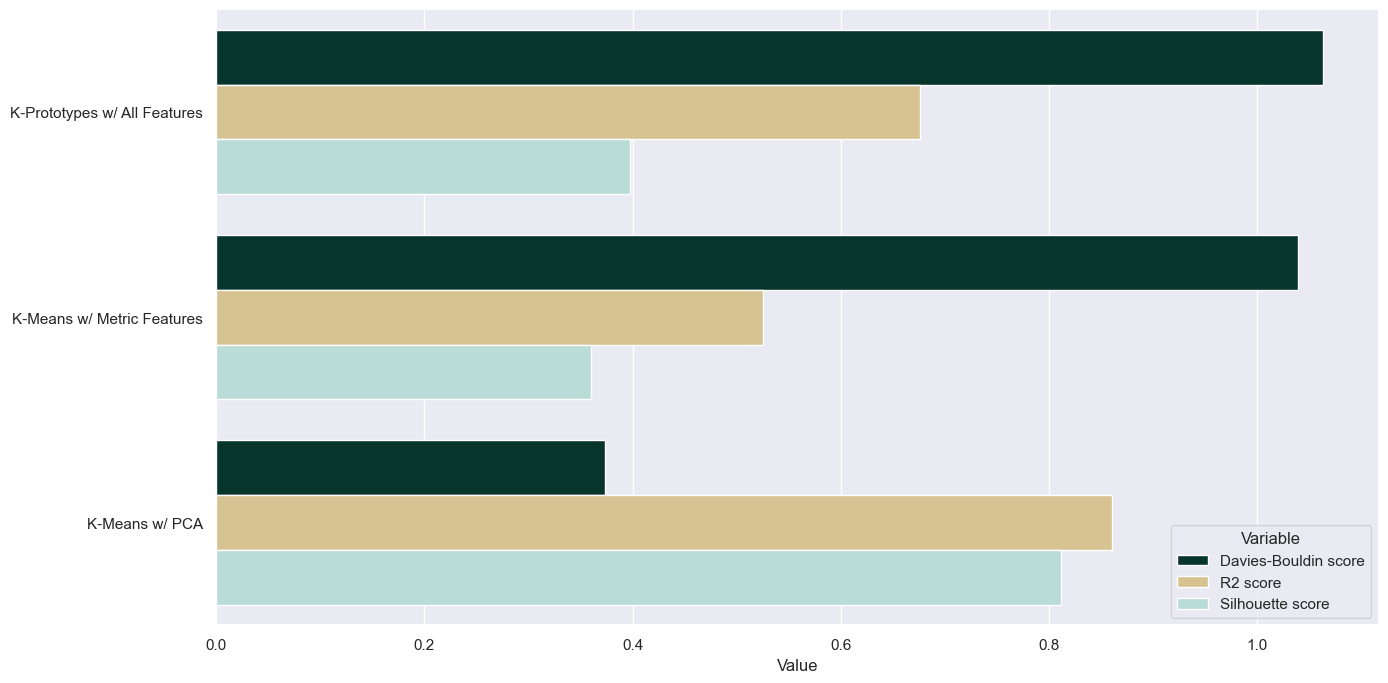

In [157]:
#get the scores for all the algorithms used to perform clustering
silhouette_scores = []
ch_scores=[]
db_scores=[]
r2_scores =[]
for df in ([df_pca_kmeans, df_kmeans, df_kp]):
    
    label = df.iloc[:,-1:]
    r2_scores.append(R2(df, label.columns.tolist()[0]))
    df=df.drop(label, axis=1)
    
    silhouette_scores.append(metrics.silhouette_score(df, label))
    ch_scores.append(metrics.calinski_harabasz_score(df, label))
    db_scores.append(metrics.davies_bouldin_score(df, label))
    
    
    
# plotting the results of the clustering algorithms 

zippy = pd.DataFrame(zip(silhouette_scores, db_scores, r2_scores), 
                     columns = ['Silhouette score', 'Davies-Bouldin score', 'R2 score'])

zippy['col'] = ['K-Means w/ PCA','K-Means w/ Metric Features', 'K-Prototypes w/ All Features']

tidy = zippy.melt(id_vars = 'col').rename(columns = str.title)
tidy.sort_values(['Value'], ascending = False, inplace = True)

plt.figure(figsize = (15, 8))
plot = sns.barplot(y = 'Col', x = 'Value', hue = 'Variable', data = tidy, palette = ['#003c30','#e2c787','#b4e2db'])
plot.set(ylabel = None)
plt.show()

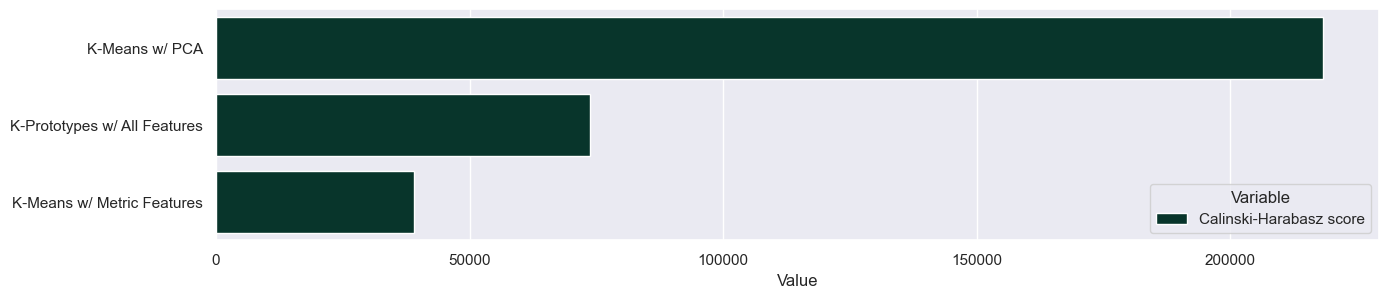

In [158]:
zippy = pd.DataFrame(zip(ch_scores), 
                     columns = ['Calinski-Harabasz score'])

zippy['col'] = ['K-Means w/ PCA','K-Means w/ Metric Features', 'K-Prototypes w/ All Features']
tidy = zippy.melt(id_vars = 'col').rename(columns = str.title)
tidy.sort_values(['Value'], ascending = False, inplace = True)

plt.figure(figsize = (15, 3))
plot = sns.barplot(y = 'Col', x = 'Value', hue = 'Variable', data = tidy,palette = ['#003c30','#e2c787','#b4e2db'])
plot.set(ylabel = None)
plt.show()

> The final clustering chosen was the **K-Means with PCA**, because it has the highest R2, lowestSilhouette and Calinski-Harabasz score and the Davies-Bouldin score.

### 5.1.5. Final Clustering Solution Analysis 

In [159]:
#Add a column with the cluster labels 

df_all_variables['Cluster_Labels']= kmeans_metric_labels

In [160]:
metric_features_to_analyse= ['AverageLeadTime', 'LodgingRevenue', 'OtherRevenue','BookingsCheckedIn',
                             'PersonsNights', 'RoomNights','YearsSinceCreation',
                             'TotalRevenue', 'RevenuePerson', 'RoomRate',
                             'RevenuePerStay','LeadTimePreference']

non_metric_features_to_analyse= ['DistributionChannel','RoomType','FloorPreference','RoomPreferences','Region', 'age_bins']

In [161]:
df_all_variables.groupby('Cluster_Labels')[metric_features_to_analyse].mean().T

Cluster_Labels               0           1           2
AverageLeadTime      41.506544  226.895984   69.520375
LodgingRevenue      267.234282  351.750066  651.617174
OtherRevenue         53.839084   96.952965  143.007300
BookingsCheckedIn     1.016025    1.013573    1.038424
PersonsNights         3.949374    6.091535    9.975168
RoomNights            2.084966    2.981011    4.951700
YearsSinceCreation    1.938086    1.771597    1.824121
TotalRevenue        321.073366  448.703030  794.624473
RevenuePerson        95.383140   79.815526   90.618141
RoomRate            158.974773  152.138155  165.829309
RevenuePerStay      317.319717  445.037865  774.416906

In [162]:
df_all_variables.groupby('Cluster_Labels')[non_metric_features_to_analyse].agg(pd.Series.mode).T

Cluster_Labels                           0                      1  \
DistributionChannel  Travel Agent/Operator  Travel Agent/Operator   
RoomType                           Unknown                Unknown   
FloorPreference                    Unknown                Unknown   
RoomPreferences                    Unknown                Unknown   
Region                      Western Europe         Western Europe   
age_bins                             36-50                  51-65   

Cluster_Labels                           2  
DistributionChannel  Travel Agent/Operator  
RoomType                           Unknown  
FloorPreference                    Unknown  
RoomPreferences                    Unknown  
Region                      Western Europe  
age_bins                             51-65

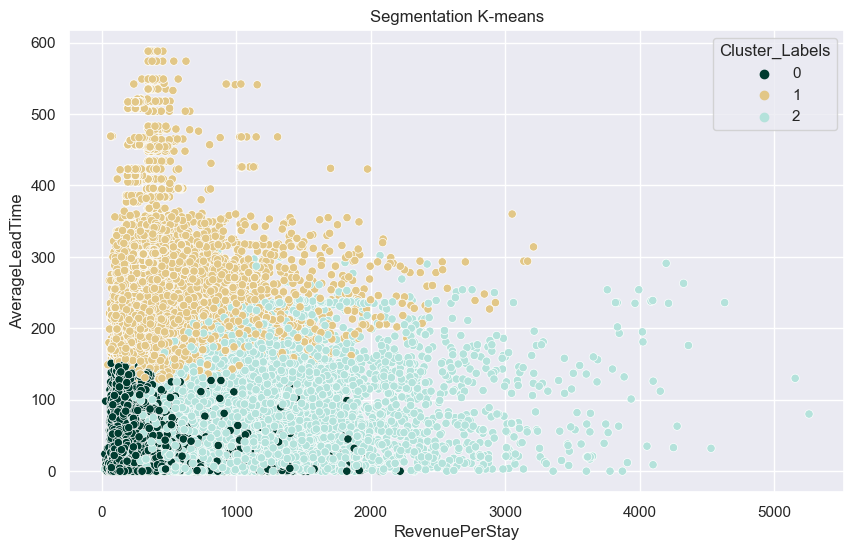

In [163]:
# plotting the results from the K-means algorithm. 
x_axis = df_all_variables['RevenuePerStay']
y_axis = df_all_variables['AverageLeadTime']
plt.figure(figsize = (10, 6))
sns.scatterplot(x_axis, y_axis, hue = df_all_variables['Cluster_Labels'], palette = ['#003c30','#e2c787','#b4e2db'])
plt.title('Segmentation K-means')
plt.show()

In [164]:
#Code in the cells below adapted from:
#https://towardsdatascience.com/best-practices-for-visualizing-your-cluster-results-20a3baac7426

**Barplots: Comparing each feature mean with the overall population mean**

In [165]:
#First, compute the mean for each feature per cluster 
df_mean= pd.concat([pd.DataFrame(df_all_variables[metric_features_to_analyse].mean(), columns=['mean']), 
                   df_all_variables[metric_features_to_analyse+['Cluster_Labels']].groupby('Cluster_Labels').mean().T], axis=1)

#Second, compute the relative differences in percentage of each feature per cluster to the overall average of the data set
df_dif= df_mean.apply (lambda x: round((x-x['mean'])/x['mean']*100,2), axis=1)
df_dif.drop(columns=['mean'], inplace=True)
df_mean.drop(columns=['mean'], inplace=True)

In [166]:
def cluster_comparison_bar(df_comparison, colors, deviation=True ,title="Cluster results"):
    
    features = df_comparison.index
    ncols = 3
    # calculate number of rows
    nrows = len(features) // ncols + (len(features) % ncols > 0)
    # set figure size
    fig = plt.figure(figsize=(15,15), dpi=200)
    #interate through every feature
    for n, feature in enumerate(features):
        # create chart
        ax = plt.subplot(nrows, ncols, n + 1)
        df_comparison[df_comparison.index==feature].plot(kind='bar', ax=ax, title=feature, 
                                                             color=colors,
                                                             legend=False
                                                            )
        plt.axhline(y=0)
        x_axis = ax.axes.get_xaxis()
        x_axis.set_visible(False)

    c_labels = df_comparison.columns.to_list()
    c_colors = colors
    mpats = [mpatches.Patch(color=c, label=l) for c,l in list(zip(colors,
                                                                  df_comparison.columns.to_list()))]

    fig.legend(handles=mpats,
               ncol=ncols,
               loc="upper center",
               fancybox=True,
               bbox_to_anchor=(0.5, 1.015)
              )
    axes = fig.get_axes()
    
    fig.suptitle(title, fontsize=18, y=1.05)
    fig.supylabel('Deviation from overall mean in %')
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()

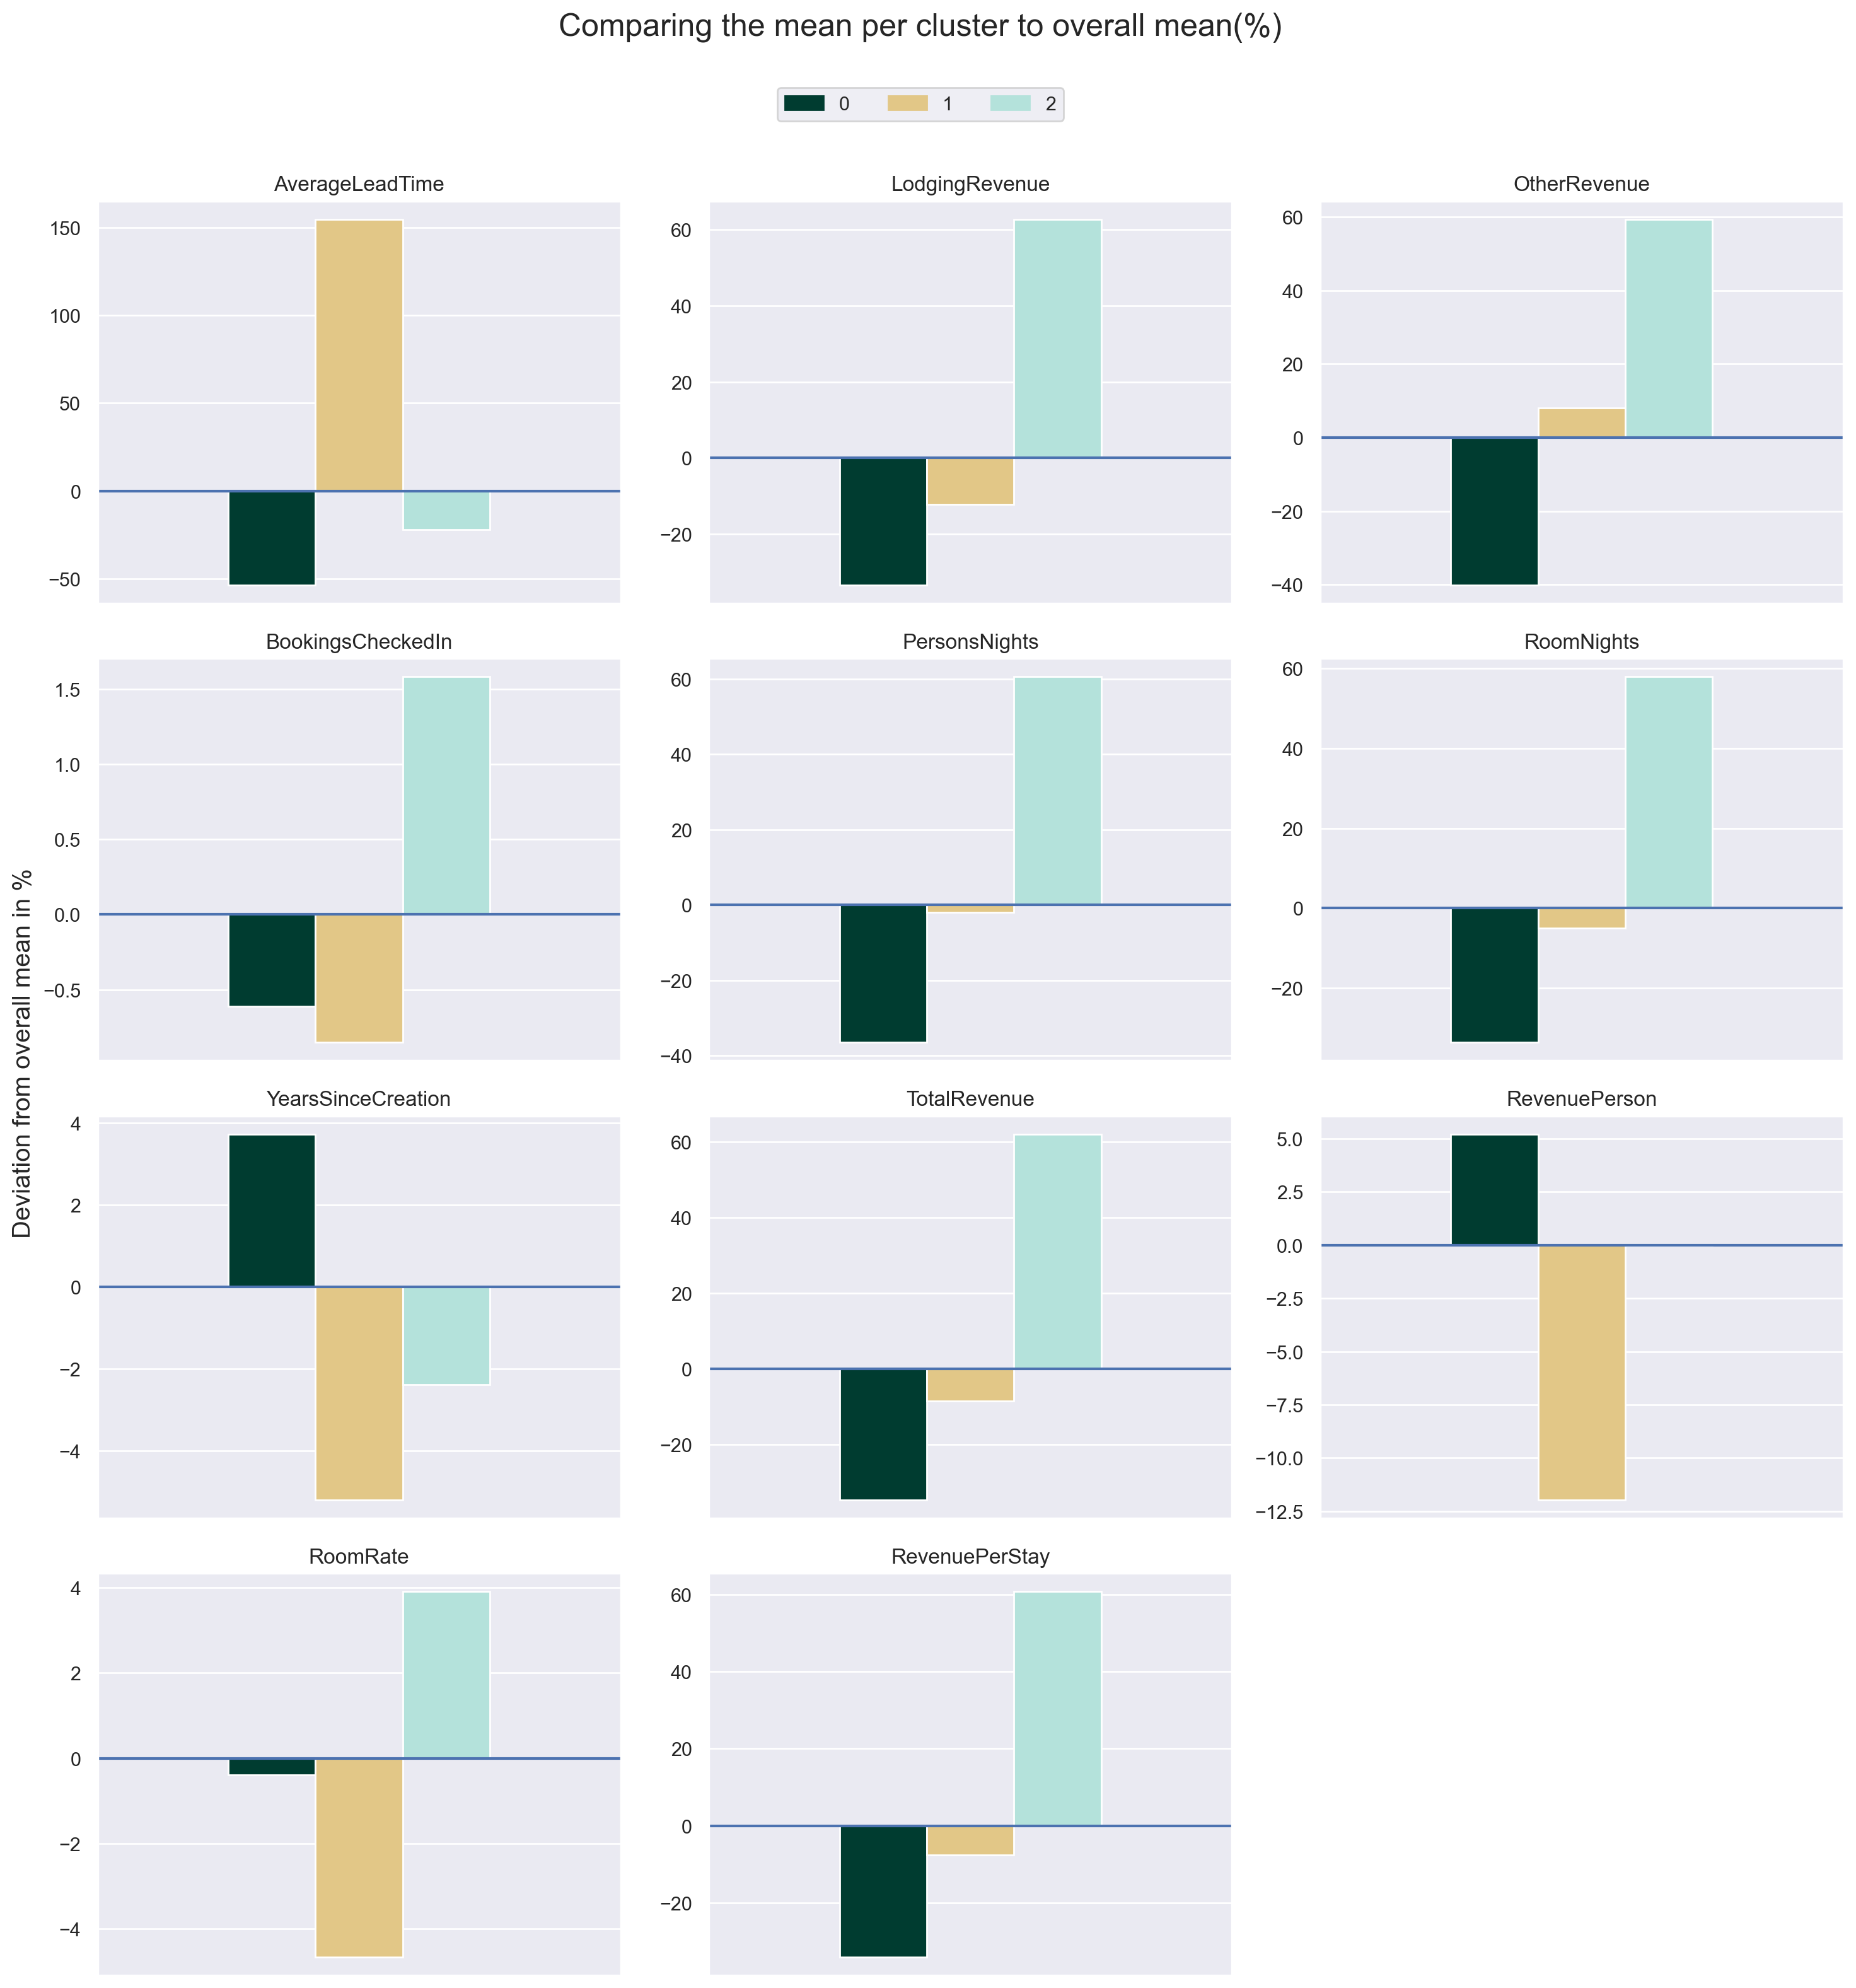

In [167]:
cluster_comparison_bar(df_dif, cluster_colors, deviation=True ,title="Comparing the mean per cluster to overall mean(%)")

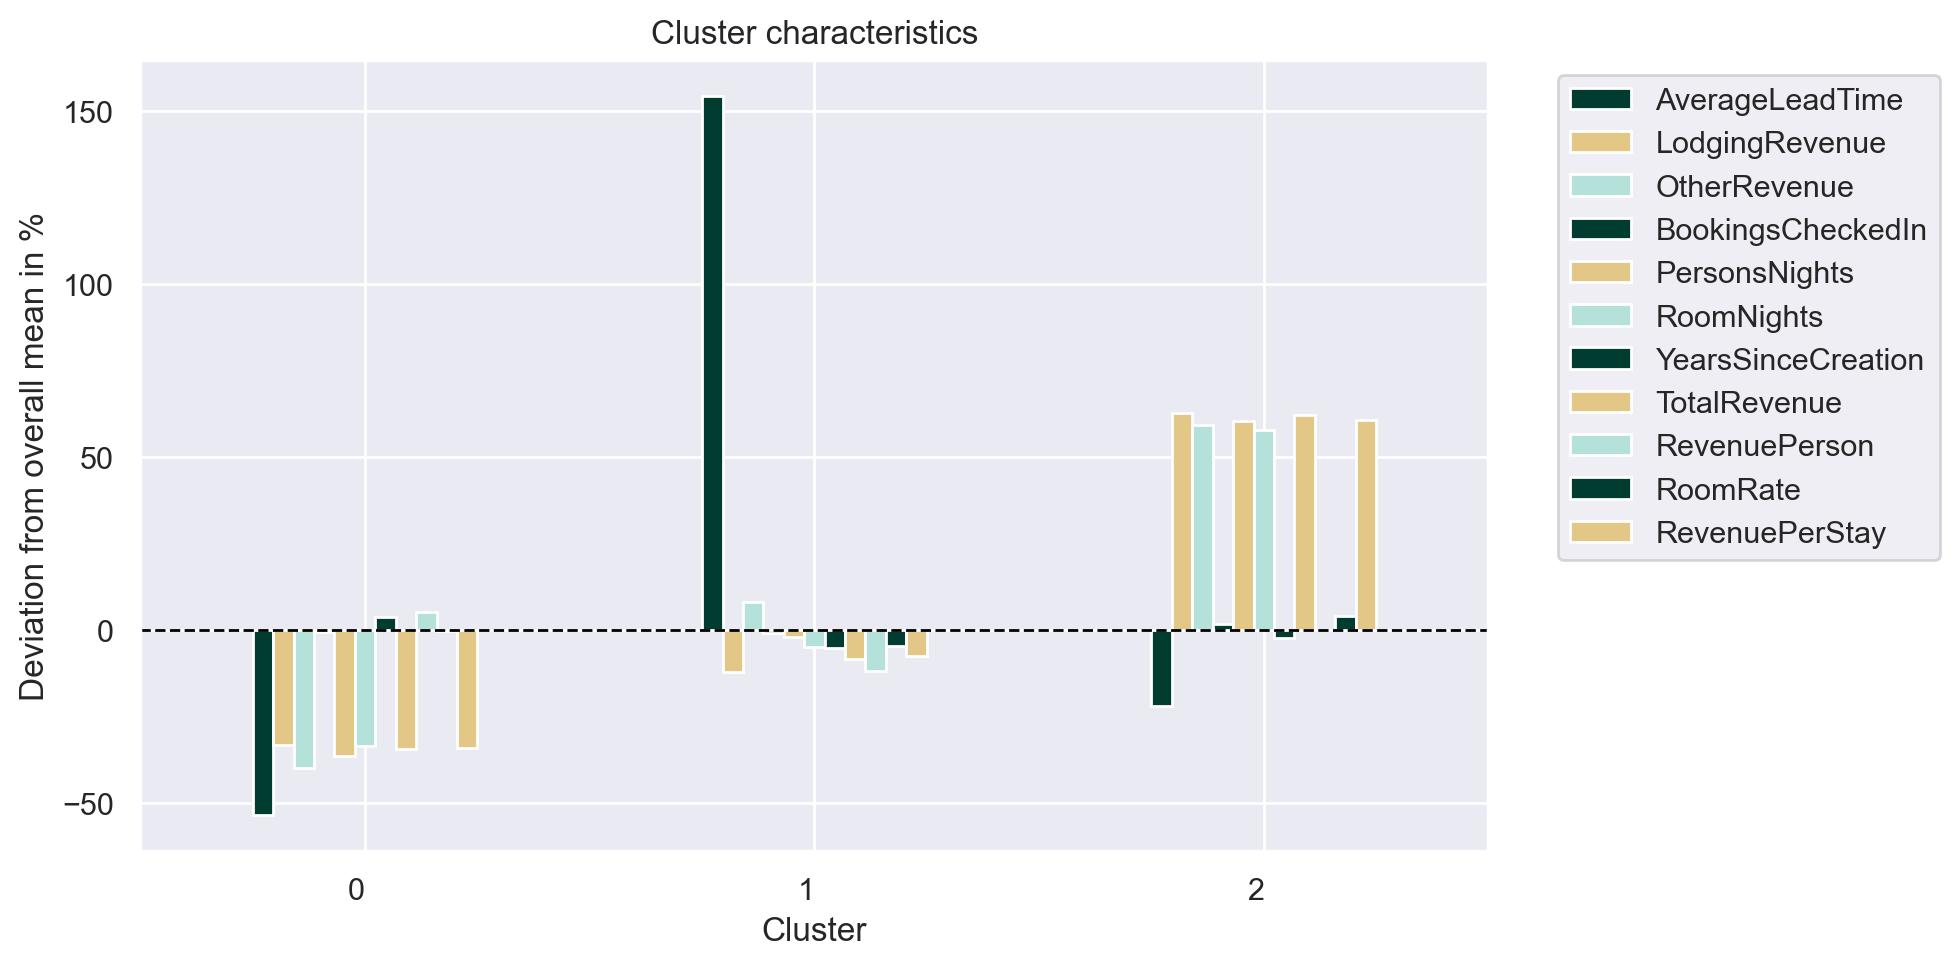

In [168]:
#Summarise relevant results in one chart

fig = plt.figure(figsize=(10,5), dpi=200)
df_dif.T.plot(kind='bar', 
                       ax=fig.add_subplot(), 
                       title="Cluster characteristics", 
                       color=cluster_colors,
                       xlabel="Cluster",
                       ylabel="Deviation from overall mean in %"
                      )
plt.axhline(y=0, linewidth=1, ls='--', color='black')
plt.legend(bbox_to_anchor=(1.04,1))
fig.autofmt_xdate(rotation=0)
plt.tight_layout()
plt.show()